# Training machine learning algorithm to detect showers

The goal of the method is to classify events into two categories - **shower**, **noise**

Main motivation behind the method was difficulty to formulate selection conditions by hand, although this was an initial plan behind applying feature extraction procedure on flight data. Defining simple manual rules and using them might still not be impossible. This is also motivation to use feature elimination methods to aid in formulating selection rules. Using decision tree-based methods for classification follows this line of thought. These methods include determining a feature importance and decision trees can be visualized to understand how is the decision being made.

This procedure consists of the following parts:
1. [Data selection](#Data-selection)
    - Visible simulated events (simu signal above the background, track recognized in simulated shower signal).
    - Noisy simulated events (triggered well outside of track injection GTU). However, the background noise is from the flight data.
    - Flight noise events (triggered well outside of GTU 40).
    - Flight classified events - classified by the manual classification.
    
    
2. [Preparation of the testing and training datasets](#Preparation-of-the-testing-and-training-datasets)
    - Limitation: only subset of all extracted features is used to decrease computational demands of feature selection. However, the subset should be large enough to contain most of the features that are expected to have some property allowing to distinguish between a shower track and noise. This procedure should be selecting around 1000 event features from the database.
    - All visible simulated events should be included.
    - Datasets should be balanced (same size of each class).
    - Noise datased should be constructed by following priority: classified noise, unclassified flight, unclassified simu.
    
    
3. [Feature selection and classification](#Feature-selection-and-classification)
    - *(This is part that might be changed in the later machine learning procedures)*
    - Variance thresholding to remove features without any variance.
    - Univariate feature selection to select smaller but still large enough subset of features (mainly to limit the computational demands). This particular procedure selects 400 features.
    - Recursive feature elimination with cross-validation - Training and validating *Extremely Randomized Trees model (ExtraTreesClassifier)* on multiple combinations of features aimed to select set of features that provide the best classification accuracy.
    
    
4. [T-SNE visualization of the dataset](#T-SNE-RFECV-features)
    - *Currently not finished (TODO)*
    - Using manifold learning approach to reduce dimensionality of the data (unsupervised) into two dimensions.
    - There should be possibility to observe clusters in the reduced-dimensionality data and cluster should correlate with known classes of the data.
    
    
5. [Evaluation of the recognition efficiency](#Recognition-efficiency-RFECV-model)
    - Accuracy of classification on the whole dataset.
    - Accuracy (specificity) of classification on the labeled dataset of noise events.
    - Dependence of sensitivity to true energy, azimuth, and zenith angles.
    - Dependence of sensitivity to background intensity. *NOT DONE YET (TODO)*.

## Imports
(section not in the report)

In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
# import supervised_classification as supc    
from utility_funtions import key_vals2val_keys

Welcome to JupyROOT 6.13/02


In [3]:
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.ensemble 
# import sklearn.neural_network
import sklearn.discriminant_analysis
import sklearn.model_selection
import sklearn.metrics
import sklearn.pipeline
from sklearn.externals import joblib

## Data selection

In [4]:
data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_20190217'
os.makedirs(data_snippets_dir, exist_ok=True)
os.makedirs(os.path.join(data_snippets_dir, 'figures'), exist_ok=True)

In [5]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_simu = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_simu_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_simu = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_simu)

In [6]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

### Selected columns

Unlinke machine learning approach, that would be trained directly on pixels and learn to identify important features as a part of a learning (for example convolutional neural network), this approach depends on a set of preselected features. Its possible advantage is that there is no need to discover identified features and after the feature extraction, the training is faster.

One of the sources of possible bias in the analysis might be initial selection of features that are analyzed by feature elimination methods.

For this experiment selected features include:
- number of triggered pixels (`trg_count_nonzero`),
- some properties describing the background frames and background frames projection,
- similarly for all frames of an event
- informations about line orientations in projections of a shower
- informations about precision of estimation the orientation of a shower
- ...

In [7]:
common_included_columns_re_list = [
  ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
  ('^trg(_box_per_gtu|_pmt_per_gtu|_ec_per_gtu)?$', '^(count_nonzero|min|max|sum|mean)$'),
    
  ('^bg(_x_y)?$','^(mean_gz|mean|max|min|count_nonzero|sum|size)$'),
    
  ('^orig(_x_y)?$','^(count_nonzero|max|mean|mean_gz|sum|size)$'),

  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_max_clu_major_line_(phi|rho)',
  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_major_line_(phi|rho)',
  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_line_clusters_((max_(peak|size|sum|area)_clu_(height|width|size))|count|sizes_max|clu_(widths|heights|areas)_max)',

  ('(proc\d|trg|alt\d)_(gtu|x)_[yx]_clusters',('^(count|sizes_max|sizes_min|clu_areas_max|max_(size|peak)_clu_(width|height|size))$')),  
  ('^proc\d_(x|gtu)_[yx]_hough_peak_thr3','major_line_coord_.*'),
    
]

#### List of columns of simu data tables used for analysis

In [8]:
common_columns_for_analysis_dict = query_functions_simu.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(common_columns_for_analysis_dict)

spb_processing_v4_simu_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_simu_flatmap.event_trg_box_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_simu_flatmap.event_trg_pmt_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_simu_flatmap.event_trg_ec_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_simu_flatmap.event_trg_x_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_simu_flatmap.event_trg_gtu_x_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_simu_flatmap.event_trg_gtu_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_a

In [9]:
common_df_columns = query_functions_simu.get_dataframe_columns_from_dict(common_columns_for_analysis_dict)

#### List of columns of flight data tables used for analysis

In [10]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_trg_box_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_pmt_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_ec_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_x_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_x_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- m

### Data selection queries

#### Simu visible events (base)

All positive samples for the training are simulated shower tracks with background from the flight data (see notebook ver4_flatmap_visible_events). Events considered as positive samples have to contain track signal (see ver4_test_selection_visualization__simu_signal notebook) and has to be considered as visible (see ver4_flatmap_simu_visible_events notebook). 

Visibility of the event is decided by a rule that **there should be at least two frames of the event which  contain a signal pixel that is greater or equal to maximum background intensity in the frame**.

Additionally there is rule that the first trigger of a visible event should be in GTU $42\pm10$.

In [11]:
# not in the report

current_columns_for_analysis_dict = common_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

simu_where_clauses_str, simu_tables_list = \
    query_functions_simu.get_query_clauses__where_simu(
        gtu_in_packet_distacne=(40, 10), 
        num_frames_signals_ge_bg__ge=2, num_frames_signals_ge_bg__le=999
    )

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z',
        'etruth_trueshowermaxpos_x', 'etruth_trueshowermaxpos_y', 'etruth_trueshowermaxpos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + simu_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)

source_data_type_num = 3001

simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, 
    limit=350000,
    base_select='')

print(simu_events_selection_query)


    SELECT 
        
        spb_processing_v4_simu_flatmap.event.event_id, spb_processing_v4_simu_flatmap.event.source_file_acquisition_full, spb_processing_v4_simu_flatmap.event.source_file_trigger_full, spb_processing_v4_simu_flatmap.event.source_file_acquisition, spb_processing_v4_simu_flatmap.event.source_file_trigger, spb_processing_v4_simu_flatmap.event.global_gtu, spb_processing_v4_simu_flatmap.event.packet_id, spb_processing_v4_simu_flatmap.event.gtu_in_packet, spb_processing_v4_simu_flatmap.event.num_gtu, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.min AS trg_box_per_gtu_min, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_simu_flatmap.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4_simu_flatmap.event_trg_pmt_per_gtu.min AS trg_pmt_per

In [12]:
simu_df = psql.read_sql(simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [13]:
simu_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,etruth_trueshowermaxpos_x,etruth_trueshowermaxpos_y,etruth_trueshowermaxpos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11464,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,17.0,...,1.000000e+13,1.311530,2.02739,27000000.0,-174947.0,4109870.0,11689800.0,3.0,3.0,3.0
1,11465,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,163,1,35,24,17.0,...,1.000000e+13,0.696797,4.65066,27000000.0,977005.0,1573110.0,4239100.0,16.0,16.0,16.0
2,11486,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,22.0,...,1.000000e+13,1.311530,2.02739,27000000.0,-174947.0,4109870.0,11689800.0,2.0,2.0,2.0
3,11487,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,20.0,...,1.000000e+13,1.311530,2.02739,27000000.0,-174947.0,4109870.0,11689800.0,3.0,3.0,3.0
4,11494,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,166,1,38,10,1.0,...,1.000000e+13,0.941292,5.61160,27000000.0,-5503800.0,3748850.0,5879780.0,5.0,5.0,5.0


#### Simu noise events

Simu noise events are events that are caused by a trigger well outside of GTU of shower injection into a packet. 

It is not ideal to use these these events as samples of the dataset because due the way the background of these events is added to the signal. Simply, if there is less packets providing the background than simualated signal tracks then same event might be repeated multiple times in the dataset. 
Besides repetition of a background packet, background of the simualted event is created by repeating sequence of background frames, thus this might cause multiple events in a same packet. How often this situation happens has not been tested. It is not expected to be very typical.

Better method of constructing these events would help validity of this analysis.

In [14]:
# not in the report

current_columns_for_analysis_dict = common_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

# simu_noise_where_clauses_str = ' AND abs(gtu_in_packet-42) >= 20 '

# OPTIMIZATION, ROWS WITH NULL SHOULD BE ALSO ANALYZED 
simu_noise_where_clauses_str = '''
    AND abs(gtu_in_packet-42) >= 20 
    AND {database_schema_name}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
'''

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z',
        'etruth_trueshowermaxpos_x', 'etruth_trueshowermaxpos_y', 'etruth_trueshowermaxpos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + simu_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)

source_data_type_num = 3001

noise_simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_noise_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, 
    limit=350000,
    base_select='')

print(noise_simu_events_selection_query)


    SELECT 
        
        spb_processing_v4_simu_flatmap.event.event_id, spb_processing_v4_simu_flatmap.event.source_file_acquisition_full, spb_processing_v4_simu_flatmap.event.source_file_trigger_full, spb_processing_v4_simu_flatmap.event.source_file_acquisition, spb_processing_v4_simu_flatmap.event.source_file_trigger, spb_processing_v4_simu_flatmap.event.global_gtu, spb_processing_v4_simu_flatmap.event.packet_id, spb_processing_v4_simu_flatmap.event.gtu_in_packet, spb_processing_v4_simu_flatmap.event.num_gtu, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.min AS trg_box_per_gtu_min, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_simu_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_simu_flatmap.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4_simu_flatmap.event_trg_pmt_per_gtu.min AS trg_pmt_per

In [15]:
noise_simu_df = psql.read_sql(noise_simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [16]:
noise_simu_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,etruth_trueshowermaxpos_x,etruth_trueshowermaxpos_y,etruth_trueshowermaxpos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11479,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,137,1,9,10,4.0,...,1.000000e+13,0.765393,2.473790,27000000.0,1581580.0,8197660.0,4933180.0,NaN,NaN,NaN
1,11500,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,201,1,73,10,4.0,...,1.000000e+13,0.765393,2.473790,27000000.0,1581580.0,8197660.0,4933180.0,NaN,NaN,NaN
2,11507,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,140,1,12,10,2.0,...,1.000000e+13,1.192790,0.311703,27000000.0,1942370.0,7455300.0,9588390.0,NaN,NaN,NaN
3,11516,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,233,1,105,10,4.0,...,1.000000e+13,0.765393,2.473790,27000000.0,1581580.0,8197660.0,4933180.0,NaN,NaN,NaN
4,11533,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,204,1,76,10,2.0,...,1.000000e+13,1.192790,0.311703,27000000.0,1942370.0,7455300.0,9588390.0,NaN,NaN,NaN


#### Flight improbable events

More preferred set of background noise events consists of events that triggered outside of expected range of GTU. Note that these events were triggered in a configuration with lowered thresholds (number selected bin is halved). However, using such events on its own is not sufficient because the actual flight events are those that were triggered in default configuration.

In [17]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_noise_flight_select_clause_str, unl_noise_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_noise_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_noise_flight_tables_list)

unl_noise_source_data_type_num = 1

unl_noise_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) > 20
    AND {database_schema_name}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
    AND {database_schema_name}.event_orig_x_y.count_nonzero > 256*6
''' 

unl_noise_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=unl_noise_source_data_type_num,
        select_additional=unl_noise_flight_select_clause_str, 
        join_additional=unl_noise_flight_clauses_str,
        where_additional=unl_noise_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
        limit=20000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
    #     limit=350000,
        base_select='')

print(unl_noise_flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_flatmap.event_trg_box_per_gtu.min AS trg_box_per_gtu_min, spb_processing_v4_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.min AS trg_pmt_per_gtu_min, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.sum AS trg_pmt_pe

In [18]:
unl_noise_flight_df = psql.read_sql(unl_noise_flight_events_selection_query, event_v3_storage_provider_flight.connection)
# flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [19]:
unl_noise_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size
0,63,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,94,0,94,12,1.0,...,3,9,3,9,3,9,3,5,5,5
1,65,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,131,1,3,12,2.0,...,9,15,9,15,9,15,9,18,18,18
2,94,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,479,3,95,10,2.0,...,4,11,4,11,4,11,4,7,7,7
3,97,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170502-061155...,trn_20170502-061155-001.001_C_inverse_flat_ave...,257,2,1,128,500.0,...,7,13,7,13,7,13,7,10,10,10
4,107,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170503-085415...,trn_20170503-085415-001.001_C_inverse_flat_ave...,119,0,119,13,2.0,...,6,20,6,20,6,2,1,6,2,6


#### Flight labeled events

Important part of the dataset is set of events that were triggered by the hardware. These events are expected to be the hardest to recognize. Previous classification experiments without this set of events significantly limited usefulness of the method because it classified 60% of the flight events sample as a track (see ver4_test_selection_visualization__simu_20181018 notebook).
Addition of a relatively small set of these events (around 1500) seems to help significantly (see ver4_machine_learning_flight_classification_tsne_cfg3 notebook).

The manually classified dataset has been created using web classification tool (script web_manual_classification.py). The tool is available at http://eusospb-data.michalvrabel.sk.

In [20]:
EVENT_CLASSES = {
    'dot': 2,
    'top_left_ec': 5,
    'blob': 12,
    'large_blob': 11,
    'short_single_gtu_track': 7,
    'single_gtu_track': 3,
    'noise': 1,
    'cartesian_line': 4,
    'strong_pmt_edge': 9,
    'few_dots': 6,
    'bg_increased_suddenly': 10,
    'persistent_dot': 14,
    'noise_unspecified': 0,
    'unspecified': 8,
    'shower': 13,
    '2pix_line': 15,
    'bright_blob': 16,
    'blob_and_dots': 17,
    'dot_w_blob_behind': 18,
    'storng_light': 19,
    'sparse_blobs': 20,
    'noise_with_week_dot': 21
}

EVENT_CLASS_NUMBER_UNLABELED = -1
EVENT_CLASS_NUMBER_UNLABELED_NOISE = -2
EVENT_CLASS_LABLELED_NOISE_FLIGHT = -3  # in case of reduced classification

classification_table_name = event_v3_storage_provider_flight.database_schema_name + '.event_manual_classification'
classification_table_cls_column_name_simple = 'class_number'
classification_table_note_column_name_simple = 'note'
classification_table_cls_column_name = classification_table_name + '.' + classification_table_cls_column_name_simple
classification_table_note_column_name = classification_table_name + '.' + classification_table_note_column_name_simple
classification_df_cls_column_name ='manual_classification_' + classification_table_cls_column_name_simple
classification_df_note_column_name ='manual_classification_' + classification_table_note_column_name_simple

In [21]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

lbl_noise_flight_select_clause_str, lbl_noise_flight_tables_list = \
    query_functions_flight.get_query_clauses__select({
        **current_columns_for_analysis_dict,
        classification_table_name: [classification_table_cls_column_name_simple]
    })

lbl_noise_flight_clauses_str = query_functions_flight.get_query_clauses__join(lbl_noise_flight_tables_list)

lbl_noise_source_data_type_num = 1

lbl_noise_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) <= 20
    AND {{database_schema_name}}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
    AND {{database_schema_name}}.event_orig_x_y.count_nonzero > 256*6
    AND {classification_table_cls_column_name} NOT IN ({event_class_shower}, {event_class_unspecified})
'''.format(
    classification_table_cls_column_name=classification_table_cls_column_name,
    event_class_shower=EVENT_CLASSES['shower'],
    event_class_unspecified=EVENT_CLASSES['unspecified']
)
#TODO
lbl_noise_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=lbl_noise_source_data_type_num,
        select_additional=lbl_noise_flight_select_clause_str, 
        join_additional=lbl_noise_flight_clauses_str,
        where_additional=lbl_noise_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
        limit=10000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
    #     limit=350000,
        base_select='')

print(lbl_noise_flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_flatmap.event_trg_box_per_gtu.min AS trg_box_per_gtu_min, spb_processing_v4_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.min AS trg_pmt_per_gtu_min, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.sum AS trg_pmt_pe

In [22]:
lbl_noise_flight_df = psql.read_sql(lbl_noise_flight_events_selection_query, event_v3_storage_provider_flight.connection)
# lbl_noise_flight_df[classification_df_cls_column_name] 

In [23]:
lbl_noise_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size,manual_classification_class_number
0,95,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,551,4,39,10,3.0,...,6,1,6,1,6,1,5,6,6,15
1,322,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170505-100211...,trn_20170505-100211-001.001_C_inverse_flat_ave...,547,4,35,10,9.0,...,3,3,3,3,3,3,4,4,4,3
2,520,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170505-100211...,trn_20170505-100211-001.001_C_inverse_flat_ave...,1576,12,40,10,15.0,...,8,3,8,3,8,3,8,8,8,12
3,548,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-004.001_C_inverse_flat_ave...,293,2,37,20,241.0,...,4,2,4,2,4,2,5,5,5,11
4,913,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055927...,trn_20170429-055927-001.001_C_inverse_flat_ave...,1959,15,39,20,141.0,...,18,2,18,2,18,2,16,16,16,19


#### Flight unclassified probable events

Small subset of flight unclassified events, that were caused by trigger around GTU 42, are selected to be used for basic check of the data reduction capability.

In [24]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_flight_select_clause_str, unl_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_flight_tables_list)

unl_flight_source_data_type_num = 1

unl_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) < 20
    AND {{database_schema_name}}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
    AND {{database_schema_name}}.event_orig_x_y.count_nonzero > 256*6
    AND NOT EXISTS(
        SELECT {classification_table}.{{data_table_pk}} 
        FROM {classification_table} 
        WHERE {classification_table}.{{data_table_pk}} = {{data_table_name}}.{{data_table_pk}} LIMIT 1
    )
'''.format(
    classification_table=classification_table_name,
)

unl_flight_events_selection_query = query_functions_flight.get_events_selection_query_plain(
    source_data_type_num=unl_flight_source_data_type_num,
    select_additional=unl_flight_select_clause_str, 
    join_additional=unl_flight_clauses_str,
    where_additional=unl_flight_where_clauses_str,
    order_by='{data_table_name}.event_id',  # 'RANDOM()', # it might be skewed
    offset=0, 
    limit=10000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
#     limit=350000,
    base_select='')

print(unl_flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_flatmap.event_trg_box_per_gtu.min AS trg_box_per_gtu_min, spb_processing_v4_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.min AS trg_pmt_per_gtu_min, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.sum AS trg_pmt_pe

In [25]:
unl_flight_df = psql.read_sql(unl_flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [26]:
unl_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size
0,61,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,39,0,39,11,7.0,...,2,6,2,6,2,6,2,5,5,5
1,67,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,166,1,38,11,7.0,...,3,8,3,8,3,8,3,8,8,8
2,73,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,39,0,39,22,7.0,...,7,4,2,4,2,4,2,3,4,4
3,75,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,162,1,34,15,526.0,...,3,3,3,3,3,3,3,4,4,4
4,77,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170430-072445...,trn_20170430-072445-001.001_C_inverse_flat_ave...,38,0,38,33,668.0,...,24,55,24,55,24,55,24,391,391,391


#### Classification column for unlabeled filght
(not in the report)

In [27]:
unl_flight_df[classification_df_cls_column_name] = EVENT_CLASS_NUMBER_UNLABELED
unl_noise_flight_df[classification_df_cls_column_name] = EVENT_CLASS_NUMBER_UNLABELED_NOISE

### Flight datasets in dict
(not in the report)

In [28]:
flight_df_dict = {
    'unl_noise_flight_df': unl_noise_flight_df, 
    'lbl_noise_flight_df': lbl_noise_flight_df, 
    'unl_flight_df': unl_flight_df
}

### Closing connections
(not in the report)

In [29]:
event_v3_storage_provider_simu.connection.close()
event_v3_storage_provider_flight.connection.close()

### Combined simulations dataset

Simu dataframes are combined because they have same columns. 
Then within this dataset events are classified into four groups based on 
- **Query classification information** - Primary classification based on the original data selection query - original intention of the data selection.
- **Simu signal classification information** - Secondary classification is addition of labeled simu signal events. The events are loaded from tables prepared in ver4_test_selection_visualization__simu_signal notebook.

The groups are the following:
- **simu noise** - data selected by query intended to select visible events but simu signal is classified as noisy simu data
- **simu track** - data selected by query intended to select visible events and simu signal is classified as a signal - <br> *these events will be used as positive samples for machine learning algorithms*
- **noise track** - data selected by query intended to select noise events but simu signal is classified as a shower
- **noise noise** - data selected by query intended to select noise events and contains simu signal classified as noisy simu data (could be used as a part of negative samples dataset, although it is not ideal)
- **simu unclassified**, **noise unclassified** - data without any labelling for simu signal data, generaly should consist of short tracks or noisy tracks, in-between easily recognizable tracks and noise.
- **simu noise underflow**, **simu noise overflow**, **simu track underflow**, **simu track overflow** - data selected by query intended to select visible events but no simu signal is present (ideally should be empty)
- **noise noise underflow**, **noise noise overflow**, **noise track underflow**, **noise track overflow**   - data selected by query intended to select noise events and no simu signal is present - <br> *these events will be used as negative samples but with a low priority*

In [30]:
combined_simu_df = pd.concat([simu_df, noise_simu_df])

In [31]:
# flight_columns_list = list(lbl_noise_flight_df.columns.values)
# combined_flight_df = pd.concat([unl_noise_flight_df[flight_columns_list], lbl_noise_flight_df[flight_columns_list], unl_flight_df[flight_columns_list]])

In [32]:
print('len(simu_df) =', len(simu_df))
print('len(noise_simu_df) =', len(noise_simu_df))
print('len(combined_simu_df) =', len(combined_simu_df))

len(simu_df) = 35607
len(noise_simu_df) = 128793
len(combined_simu_df) = 164400


### $R_{max}$ property of simulated showers

In [33]:
# 'etruth_trueshowermaxpos_x', 'etruth_trueshowermaxpos_y', 'etruth_trueshowermaxpos_z'
combined_simu_df['calc_etruth_trueshower_rmax'] = np.hypot(combined_simu_df['etruth_trueshowermaxpos_x'], combined_simu_df['etruth_trueshowermaxpos_y'])

#### Query classification information
Primary classification based on the original data selection query - original intention of the data selection.

In [34]:
combined_simu_df['cond_selection_query'] = 'undefined'
combined_simu_df.loc[combined_simu_df['event_id'].isin(simu_df['event_id']), 'cond_selection_query'] = 'simu'
combined_simu_df.loc[combined_simu_df['event_id'].isin(noise_simu_df['event_id']), 'cond_selection_query'] = 'noise'

In [35]:
if('simu_df' in locals()): del simu_df
if('noise_simu_df' in locals()): del noise_simu_df
# if('unl_noise_flight_df' in locals()): del unl_noise_flight_df
# if('lbl_noise_flight_df' in locals()): del lbl_noise_flight_df
# if('unl_flight_df' in locals()): del unl_flight_df

#### Simu signal classification information
Secondary classification is addition of labeled simu signal events.
The events are loaded from tables prepared in ver4_test_selection_visualization__simu_signal notebook.

In [36]:
# [['event_id', 'source_file_acquisition', 'global_gtu', 'packet_id', 'gtu_in_packet', 'num_gtu', 'source_file_acquisition_full']]

simu_signal_data_snippets_dir = 'ver4_simu_signal_data_snippets'
simu_signal_visible_tracks_table_path = os.path.join(simu_signal_data_snippets_dir, 'visible_tracks_table.tsv')
simu_signal_noisy_events_table_path = os.path.join(simu_signal_data_snippets_dir, 'noisy_events_table.tsv')

combined_simu_df, unclassified_simu_df, \
track_simu_df, track_underflow_simu_df, track_overflow_simu_df, \
noise_simu_df, noise_underflow_simu_df, noise_overflow_simu_df, \
simu_signal_track_events_df, simu_signal_noisy_events_df = \
    add_classification_columns(
        combined_simu_df, 
        simu_signal_visible_tracks_table_path, simu_signal_noisy_events_table_path,
        ret_simu_signal=True, ret_under_over_track=True, ret_split_noise=True,
        simu_track_class='track', simu_noise_class='noise',
        simu_track_underflow_class='track_underflow', simu_track_overflow_class='track_overflow',
        simu_noise_underflow_class='noise_underflow', simu_noise_overflow_class='noise_overflow',
        simu_events_file_pathname_dir=data_snippets_dir)

##### Combined label - joining query and labeled simu class

In [37]:
combined_simu_df['cond_selection_combined'] = 'undefined'

for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            combined_simu_df.loc[
                (combined_simu_df['cond_selection_query'] == selection_query ) & 
                (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal), 
                'cond_selection_combined'] = selection_query + '_' + t_selection_simu_signal

##### Size of the  subsets

###### Simu signal labels

In [38]:
print('len(simu_signal_track_events_df)', len(simu_signal_track_events_df))
print('len(simu_signal_noisy_events_df)', len(simu_signal_noisy_events_df))
print('-'*50)
print('len(combined_simu_df)           ', len(combined_simu_df))
print('-'*50)
print('len(unclassified_simu_df)       ', len(unclassified_simu_df))
print('len(track_simu_df)              ', len(track_simu_df))
print('len(track_underflow_simu_df)    ', len(track_underflow_simu_df))
print('len(track_overflow_simu_df)     ', len(track_overflow_simu_df))
print('len(noise_simu_df)              ', len(noise_simu_df))
print('len(noise_underflow_simu_df)    ', len(noise_underflow_simu_df))
print('len(noise_overflow_simu_df)     ', len(noise_overflow_simu_df))
print('-'*50)
print('                                   ', 
      len(unclassified_simu_df) + \
      len(track_simu_df) + len(track_underflow_simu_df) + len(track_overflow_simu_df) + \
      len(noise_simu_df) + len(noise_underflow_simu_df) + len(noise_overflow_simu_df)
     )
print('-'*50)
print('len(track_simu_df)/len(combined_simu_df)        = ', len(track_simu_df)/len(combined_simu_df))
print('len(unclassified_simu_df)/len(combined_simu_df) = ', len(unclassified_simu_df)/len(combined_simu_df))
print('len(noise_simu_df)/len(combined_simu_df)        = ', len(noise_simu_df)/len(combined_simu_df))

len(simu_signal_track_events_df) 14866
len(simu_signal_noisy_events_df) 59279
--------------------------------------------------
len(combined_simu_df)            164400
--------------------------------------------------
len(unclassified_simu_df)        9288
len(track_simu_df)               35038
len(track_underflow_simu_df)     5983
len(track_overflow_simu_df)      16956
len(noise_simu_df)               1608
len(noise_underflow_simu_df)     24689
len(noise_overflow_simu_df)      70838
--------------------------------------------------
                                    164400
--------------------------------------------------
len(track_simu_df)/len(combined_simu_df)        =  0.2131265206812652
len(unclassified_simu_df)/len(combined_simu_df) =  0.056496350364963505
len(noise_simu_df)/len(combined_simu_df)        =  0.00978102189781022


###### Selection query and simu signal labels

In [39]:
for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            print('{:<30} {}'.format(
                '{} - {}'.format(selection_query, t_selection_simu_signal),
                np.count_nonzero(
                    (combined_simu_df['cond_selection_query'] == selection_query ) & \
                    (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal))
            ))                

simu - noise                   4
simu - noise_underflow         0
simu - noise_overflow          0
simu - track                   34521
simu - track_underflow         0
simu - track_overflow          0
noise - noise                  1604
noise - noise_underflow        24689
noise - noise_overflow         70838
noise - track                  517
noise - track_underflow        5983
noise - track_overflow         16956


##### Example of track underflow subset

In [40]:
track_underflow_simu_df.sort_values('gtu_in_packet', ascending=False).head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,etruth_trueshowermaxpos_y,etruth_trueshowermaxpos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg,calc_etruth_trueshower_rmax,cond_selection_query,simu2npy_signals_pathname,simu2npy_signals_pathname_short,cond_selection_simple
45187,2109098,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_21000000.00/energy_1.41e+12/thousnd21E3.2...,posz_21000000.00/energy_1.41e+12/thousnd21E3.2...,150,1,22,11,2.0,...,-178416.0,3117490.0,NaN,NaN,NaN,2.063983e+05,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_21000000.00/energy_1.41e+12/thousnd21E3.2...,track_underflow
25116,189885,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,150,1,22,10,2.0,...,100394.0,14797100.0,NaN,NaN,NaN,1.949476e+07,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,track_underflow
21799,154316,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,150,1,22,9,2.0,...,-12996500.0,9991460.0,NaN,NaN,NaN,1.308231e+07,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,track_underflow
3711,36818,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.26e+12/thousnd27E2/n...,posz_27000000.00/energy_1.26e+12/thousnd27E2/l...,150,1,22,10,4.0,...,3183280.0,5984590.0,NaN,NaN,NaN,5.740878e+06,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_27000000.00/energy_1.26e+12/thousnd27E2/s...,track_underflow
93171,2411359,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_18000000.00/energy_5.25e+12/simu.2017-07-...,posz_18000000.00/energy_5.25e+12/simu.2017-07-...,150,1,22,10,4.0,...,-1658690.0,2540990.0,NaN,NaN,NaN,2.049091e+06,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_18000000.00/energy_5.25e+12/simu.2017-07-...,track_underflow


##### Example of track overflow subset

In [41]:
track_overflow_simu_df.sort_values('gtu_in_packet', ascending=True).head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,etruth_trueshowermaxpos_y,etruth_trueshowermaxpos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg,calc_etruth_trueshower_rmax,cond_selection_query,simu2npy_signals_pathname,simu2npy_signals_pathname_short,cond_selection_simple
53058,2156392,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_30000000.00/energy_2.00e+12/thousnd30E6.2...,posz_30000000.00/energy_2.00e+12/thousnd30E6.2...,190,1,62,20,15.0,...,1284630.0,7757090.0,NaN,NaN,NaN,3.966318e+06,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_2.00e+12/thousnd30E6.2...,track_overflow
58199,2189735,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,190,1,62,10,2.0,...,10277400.0,9487000.0,NaN,NaN,NaN,1.061182e+07,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,track_overflow
58697,2192502,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,190,1,62,14,5.0,...,-1284790.0,6489800.0,NaN,NaN,NaN,1.363170e+06,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,track_overflow
59486,2196758,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_21000000.00/energy_3.94e+12/ter212.2017-0...,posz_21000000.00/energy_3.94e+12/ter212.2017-0...,190,1,62,12,1.0,...,9598280.0,13676100.0,NaN,NaN,NaN,9.784803e+06,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_21000000.00/energy_3.94e+12/ter212.2017-0...,track_overflow
110238,2510779,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_18000000.00/energy_8.50e+12/set18.2017-07...,posz_18000000.00/energy_8.50e+12/set18.2017-07...,190,1,62,14,5.0,...,-3969550.0,6312120.0,0.0,0.0,0.0,4.385232e+06,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_18000000.00/energy_8.50e+12/set18.2017-07...,track_overflow


##### Visualization of a few events

- Noise entries are sorted by number of simu signal pixles in x-y projection in descending order (`orig_x_y_count_nonzero`, sorted from the most potentially track-like),
- Track entries are sorted by num frames where maximum signal is greater equal maximum background in acsending order (`num_frames_signals_ge_bg`, from the least visible track events). Non-track-like simu signal might not be necessarly incorrectly labeled entries, just a small portion of a track in signal.
- Track underflow, track overflow should all contain empty simu signal data. Entries are sorted by GTU in packet in ascending or descending order, respectively.

noise (1608 entries)
--------------------------------------------------
#0	(0)
	event_id: 2261798
	packet_id: 1
	gtu_in_packet: 17
	num_gtu: 23
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_30000000.00/energy_6.31e+12/thousnd30E16.2017-07-25-13h05m21s/simu2npy/ev_34_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: noise


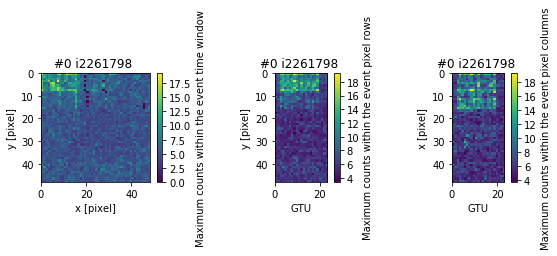

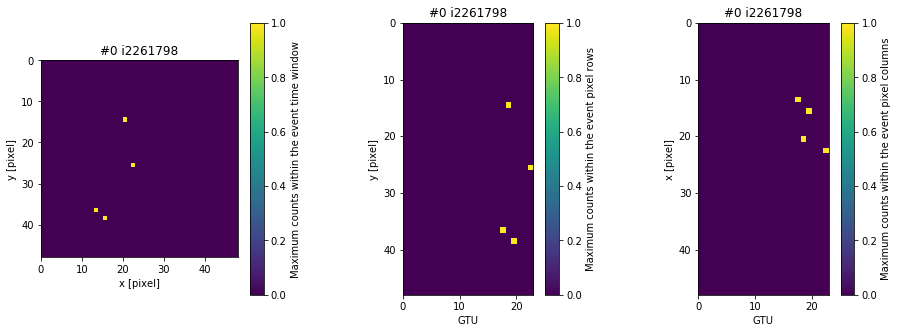

#1	(0)
	event_id: 2020798
	packet_id: 1
	gtu_in_packet: 17
	num_gtu: 23
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_18000000.00/energy_5.62e+12/thousnd18E15.2017-07-28-11h19m08s/simu2npy/ev_77_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: noise


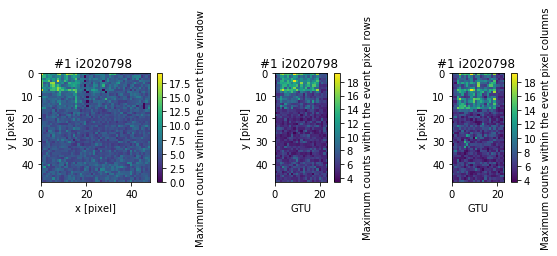

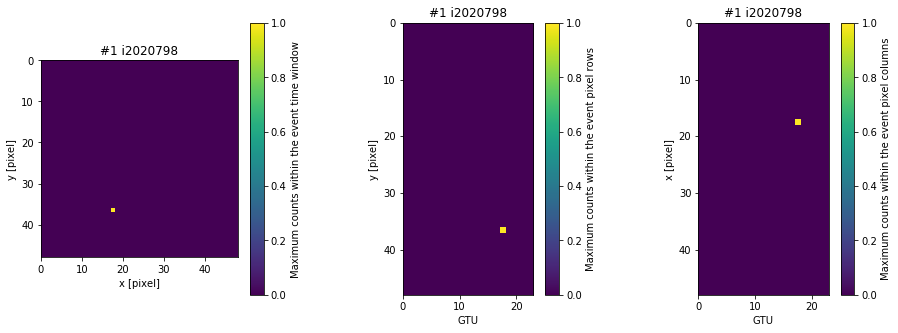

#2	(0)
	event_id: 2452180
	packet_id: 1
	gtu_in_packet: 21
	num_gtu: 20
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_18000000.00/energy_7.15e+12/simu.2017-07-24-06h44m34s/simu2npy/ev_50_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: noise


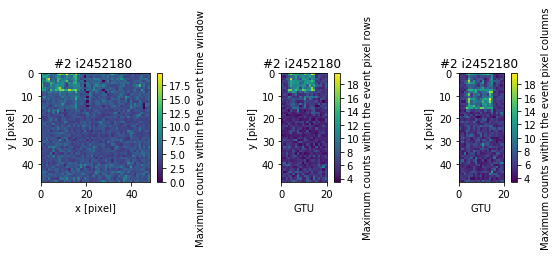

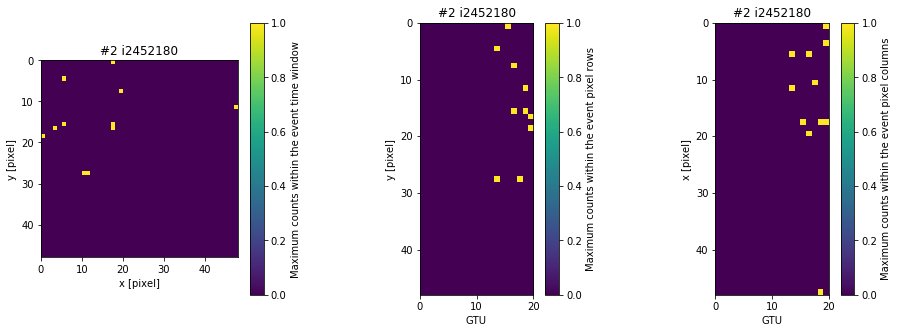

track (35038 entries)
--------------------------------------------------
#0	(0)
	event_id: 2626269
	packet_id: 1
	gtu_in_packet: 67
	num_gtu: 10
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_33000000.00/energy_8.91e+12/thousnd33E19/simu2npy/ev_97_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track


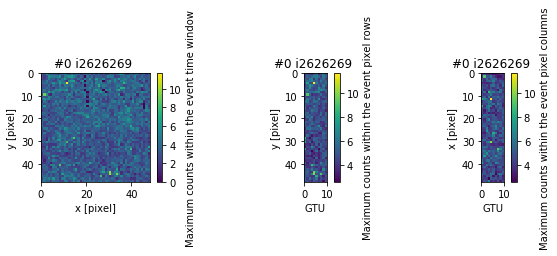

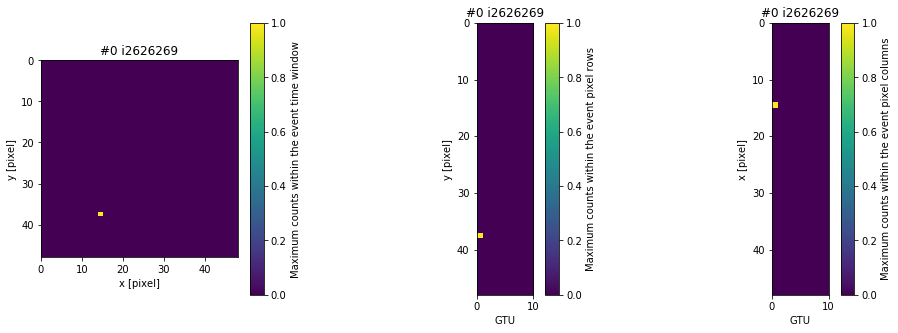

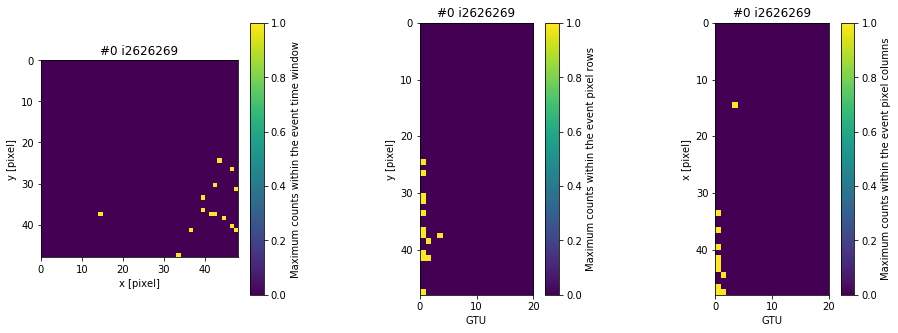

#1	(0)
	event_id: 2118783
	packet_id: 1
	gtu_in_packet: 65
	num_gtu: 12
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_30000000.00/energy_1.58e+12/thousnd30E4/simu2npy/ev_98_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track


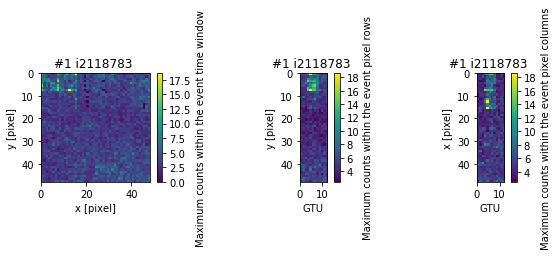

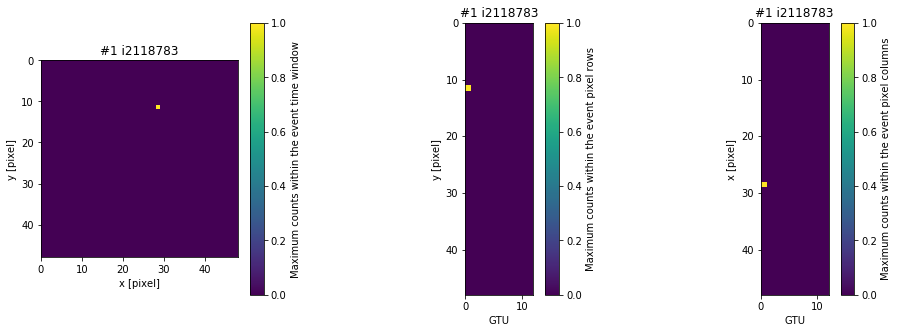

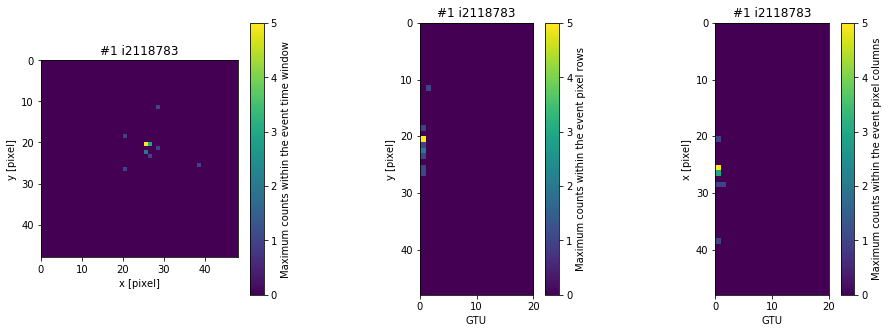

#2	(0)
	event_id: 2119602
	packet_id: 1
	gtu_in_packet: 64
	num_gtu: 16
	num_frames_signals_ge_bg: 0.0
	simu2npy_signals_pathname_short: posz_21000000.00/energy_1.58e+12/thousnd21E4.2017-07-26-21h24m15s/simu2npy/ev_20_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track


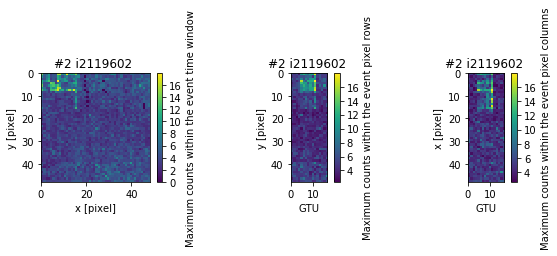

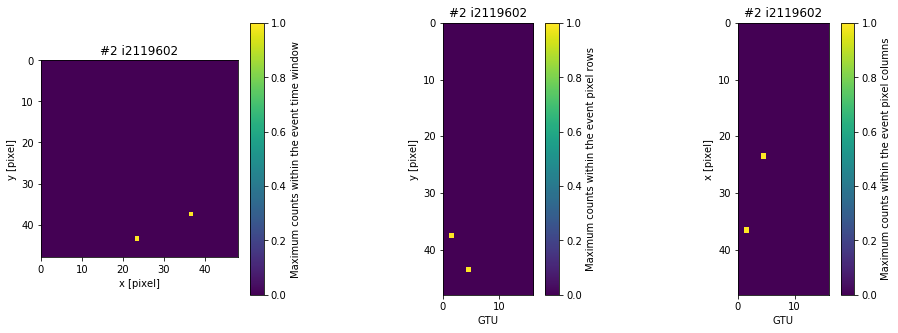

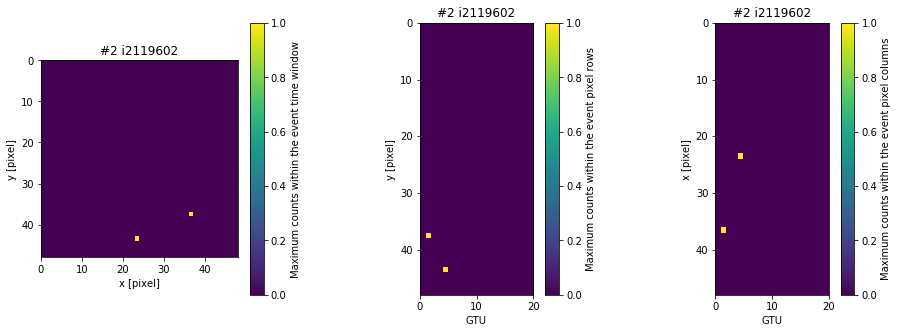

track_underflow (5983 entries)
--------------------------------------------------
#0	(0)
	event_id: 2109098
	packet_id: 1
	gtu_in_packet: 22
	num_gtu: 11
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_21000000.00/energy_1.41e+12/thousnd21E3.2017-07-26-20h13m39s/simu2npy/ev_79_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_underflow


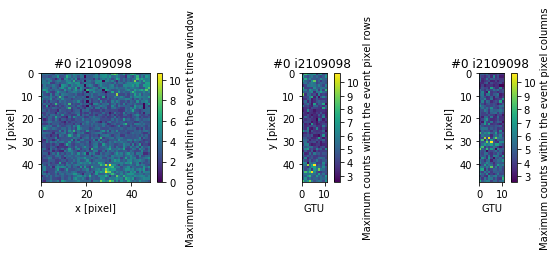

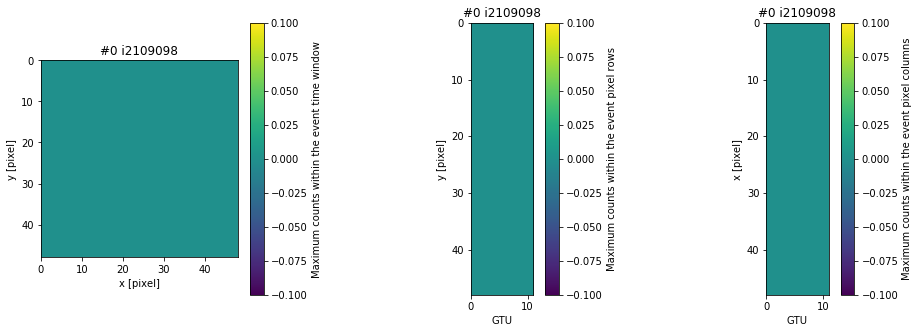

#1	(0)
	event_id: 189885
	packet_id: 1
	gtu_in_packet: 22
	num_gtu: 10
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_24000000.00/energy_5.95e+12/simu.2017-07-20-20h00m16s/simu2npy/ev_16_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_underflow


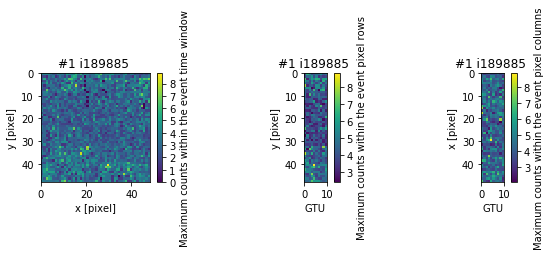

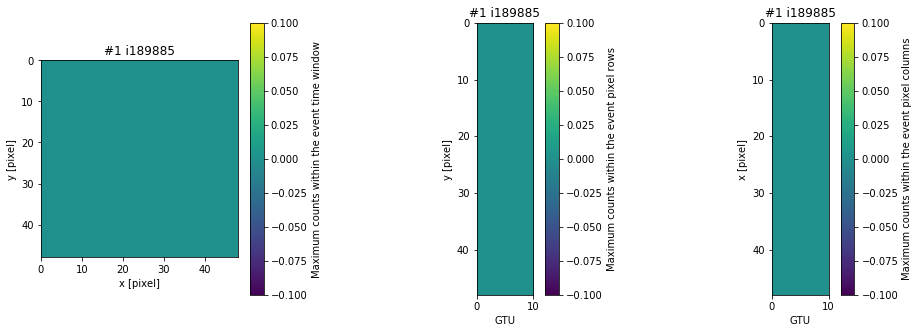

#2	(0)
	event_id: 154316
	packet_id: 1
	gtu_in_packet: 22
	num_gtu: 9
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_24000000.00/energy_5.95e+12/simu.2017-07-21-05h30m38s/simu2npy/ev_59_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_underflow


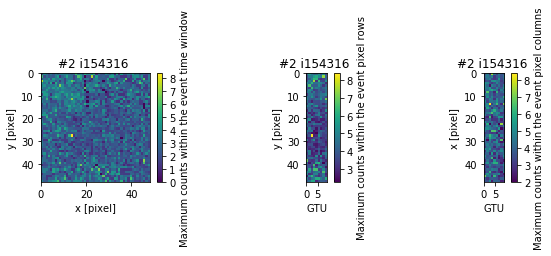

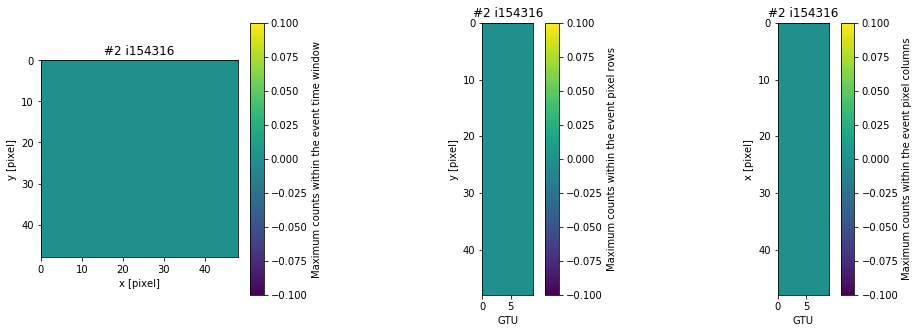

track_overflow (16956 entries)
--------------------------------------------------
#0	(0)
	event_id: 2156392
	packet_id: 1
	gtu_in_packet: 62
	num_gtu: 20
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_30000000.00/energy_2.00e+12/thousnd30E6.2017-07-24-22h56m23s/simu2npy/ev_61_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_overflow


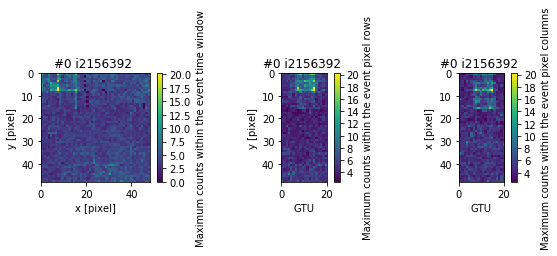

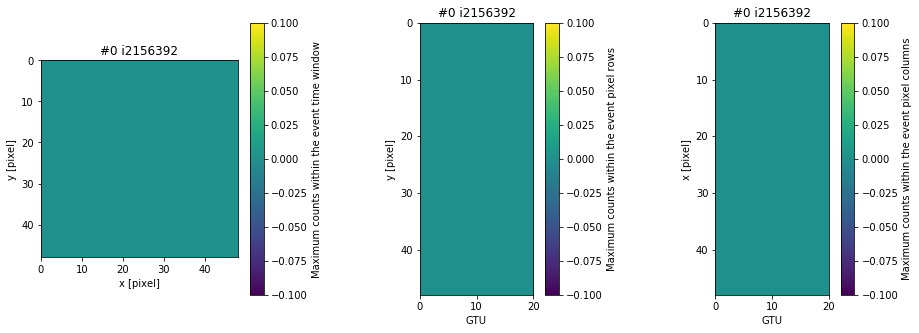

#1	(0)
	event_id: 2189735
	packet_id: 1
	gtu_in_packet: 62
	num_gtu: 10
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-21h02m30s/simu2npy/ev_62_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_overflow


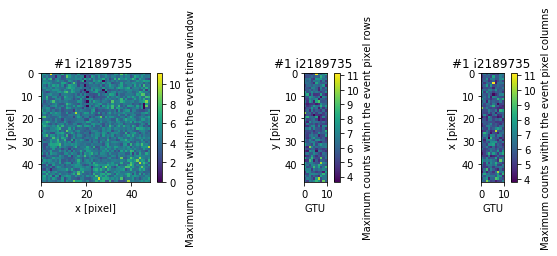

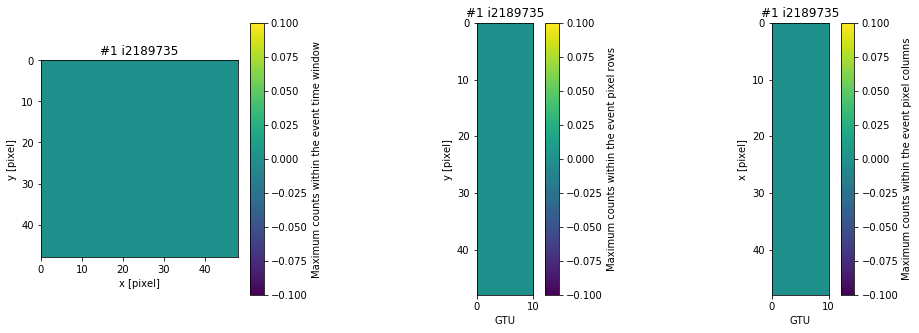

#2	(0)
	event_id: 2192502
	packet_id: 1
	gtu_in_packet: 62
	num_gtu: 14
	num_frames_signals_ge_bg: nan
	simu2npy_signals_pathname_short: posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-21h10m14s/simu2npy/ev_47_mc_1__signals.npy
	cond_selection_query: noise
	cond_selection_simple: track_overflow


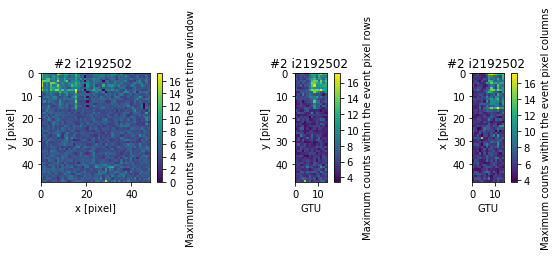

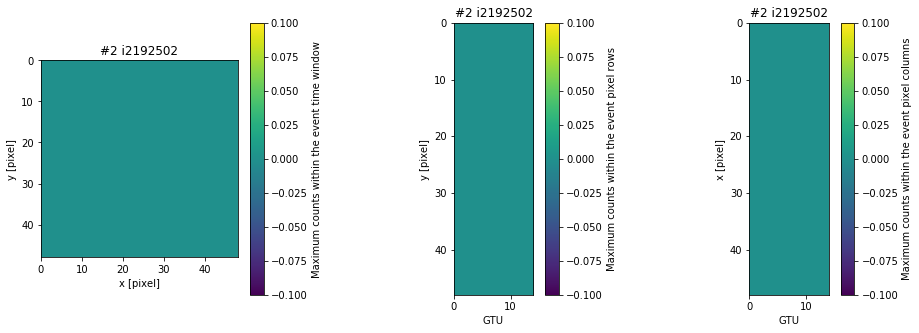

In [42]:
def vis_simu_signal_default(i, r, visualized_projections, fig, axs_flattened): 
    show_simu_event_row(i, r, 
        npy_pathname_column='simu2npy_signals_pathname', 
        single_proj_width=5, single_proj_height=5,
        print_info=False, warn_if_not_exact_simu=False)

def vis_simu_signal_with_original(i, r, visualized_projections, fig, axs_flattened):
    vis_simu_signal_default(i, r, visualized_projections, fig, axs_flattened)
    show_simu_event_row(i, r, 
        npy_pathname_column='simu2npy_signals_pathname', 
        single_proj_width=5, single_proj_height=5,
        print_info=False, warn_if_not_exact_simu=False,
        simu_gtu_override=(30,50))

for label, events_to_vis_df in [
        ('noise', noise_simu_df.sort_values('orig_x_y_count_nonzero', ascending=False)), 
        ('track', track_simu_df.sort_values('num_frames_signals_ge_bg', ascending=True)), 
        ('track_underflow', track_underflow_simu_df.sort_values('gtu_in_packet', ascending=False)), 
        ('track_overflow', track_overflow_simu_df.sort_values('gtu_in_packet', ascending=True))
]:
    print('{} ({} entries)'.format(label, len(events_to_vis_df)))
    print('-' * 50)
    vis_events_df(
        events_to_vis_df, 
        events_per_figure=3, max_figures=1, vis_gtux=True, vis_gtuy=True, 
        close_after_vis=False, show=True, 
        additional_printed_columns=[
            'num_frames_signals_ge_bg', 'simu2npy_signals_pathname_short', 
            'cond_selection_query', 'cond_selection_simple'],
        by_one=True,
        extension_func=vis_simu_signal_with_original if label == 'track' else vis_simu_signal_default,
        single_proj_width=3, single_proj_height=2
    )
    print('=' * 50)

### Adding new features

#### Rank column
The principle of a rank column is to combine values of features based on expected or calculated correlation of a column with likeliness of an event being a shower. The lowest value should correspond to the most probable shower track.

In this case, a short set of hand-picked list is utilized. More preferable way of doing this would be to use columns selected by a machine learning approach that calculates feature importance.

The provided features are normalized to 0-1 range, 
optionally, the values of the features are inverted (1-val) and weighted. 
Finally, the summed value is resulting rank of a record.

In [43]:
rank_columns = ['proc1_x_y_hough_peak_thr2_line_clusters_count', 'proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 
                 'proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width',
                 'trg_count_nonzero', 'num_gtu']

def add_rank_column_default(data_df):
    add_rank_column(data_df, 
                    rank_columns, 
                    ascending=[True, True, True, True, False, False], 
                    column_weights=[2,2,1,1,1,1],
                    print_max_vals=True, add_norm_columns=True, do_copy=False)

#### Difference columns
Expected property of air shower event is that at least in one of the shower projections in time should contain a line with a slope different than 0 or 90 degrees. 
In an ideal case an actual slope of a line is not important, only important information is slope difference to 0 or 90 degrees.

In [44]:
# not in the report
area_columns_prefix_list = ('proc1', 'proc2', 'proc3', 'trg')
area_columns_proj_list = ('x_y', 'gtu_x', 'gtu_y')
area_columns_thr_i_list = list(range(1,4))

area_columns_line_types = ['peak', 'sum', 'size']
area_columns_col_name_prefixes = ['{{prefix}}_{{proj}}_hough_peak_thr{{thr_i}}_line_clusters_max_{}_clu_'.format(t) for t in area_columns_line_types]

diff_columns_proc_range = (1,4)
diff_columns_alt_range = (1,1)
diff_columns_thr_range = (1,4)

diff_columns_prefixes = \
    ['proc{}'.format(i) for i in range(*diff_columns_proc_range)] + \
    ['alt{}'.format(i) for i in range(*diff_columns_alt_range)]

diff_columns_projs = ['gtu_x', 'gtu_y']
diff_columns_diff_types = ['pi_over_2', '0']

diff_columns_gtu_y_gtu_x_diff_format = '{prefix}_gtu_y_gtu_x_hough_peak_thr{thr_i}_major_line_phi_diff'
diff_columns_proj_diff_format = '{prefix}_{proj}_hough_peak_thr{thr_i}_major_line_phi_diff_{diff_type}'

#

common_extension_columns = ['event_id', 'rank']

for col in rank_columns:
    common_extension_columns.append('norm_' + col)

for prefix in area_columns_prefix_list:
    for proj in area_columns_proj_list:
        for thr_i in area_columns_thr_i_list:
            for col_name_prefix in area_columns_col_name_prefixes:
                common_extension_columns.append(col_name_prefix.format(prefix=prefix, proj=proj, thr_i=thr_i) + 'area')
    
for prefix in diff_columns_prefixes:
    for thr_i in range(*diff_columns_thr_range):
        common_extension_columns.append(diff_columns_gtu_y_gtu_x_diff_format.format(prefix=prefix, thr_i=thr_i))
        for proj in diff_columns_projs:
            for diff_type in diff_columns_diff_types:
                common_extension_columns.append(diff_columns_proj_diff_format.format(prefix=prefix, thr_i=thr_i, proj=proj, diff_type=diff_type))


simu_extension_columns = common_extension_columns
flight_extension_columns = common_extension_columns

# print(common_extension_columns)

#### Simu dataframe extension columns
(not in the report)

In [45]:
simu_event_ids_md5 = hashlib.md5(pickle.dumps(combined_simu_df['event_id'].values, protocol=0)).hexdigest()
simu_extension_columns_md5 = hashlib.md5(','.join(simu_extension_columns).encode()).hexdigest()
extension_columns_combined_simu_pathname = os.path.join(data_snippets_dir, 'extension_columns_simu_pathname_{}_{}.pkl.gz'.format(simu_event_ids_md5, simu_extension_columns_md5))
print(extension_columns_combined_simu_pathname)

ver4_machine_learning_w_labeled_flight_20190217/extension_columns_simu_pathname_771a6a452a651f419ec12b94ac5eb28d_51d1629013c22c624c6bcb50d5b214a0.pkl.gz


In [46]:
if not os.path.exists(extension_columns_combined_simu_pathname):
    print('Building calculating columns ...')
    print('num_frames_signals_ge_bg bin column ...')
    
    add_bin_column(combined_simu_df, 'num_frames_signals_ge_bg', 5)

    print('  area columns ...')
    
    for attr_prefix_format in area_columns_col_name_prefixes:    
        add_area_columns(combined_simu_df, prefix_list=area_columns_prefix_list, proj_list=area_columns_proj_list, thr_i_list=area_columns_thr_i_list,
                        attr_prefix_format=attr_prefix_format) 

    print('  diff columns ...')
    
    add_diff_columns(combined_simu_df, proc_range=diff_columns_proc_range, alt_range=diff_columns_alt_range, hough_peak_thr_range=diff_columns_thr_range)

    print('  rank column ...')
    
    add_rank_column_default(combined_simu_df)

    print('Saving pickle ...')
        
    combined_simu_df[simu_extension_columns].to_pickle(extension_columns_combined_simu_pathname, 'gzip')
    
else:
    print('Loading...')
    simu_extension_columns_df = pd.read_pickle(extension_columns_combined_simu_pathname, 'gzip')
    print('Merging ...')
    combined_simu_df = pd.merge(combined_simu_df, simu_extension_columns_df, on=['event_id'])
    del simu_extension_columns_df
    
combined_simu_df.head()

Loading...
Merging ...


,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,proc3_gtu_y_gtu_x_hough_peak_thr2_major_line_phi_diff,proc3_gtu_x_hough_peak_thr2_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr2_major_line_phi_diff_0,proc3_gtu_y_hough_peak_thr2_major_line_phi_diff_pi_over_2,proc3_gtu_y_hough_peak_thr2_major_line_phi_diff_0,proc3_gtu_y_gtu_x_hough_peak_thr3_major_line_phi_diff,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_0,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_0
0,11464,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,17.0,...,0.369017,1.271984,0.298812,1.500591,0.070205,0.386129,1.254872,0.315924,1.500591,0.070205
1,11465,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,163,1,35,24,17.0,...,1.226577,0.029304,1.541493,1.255881,0.314915,1.219437,0.052804,1.517993,1.272241,0.298555
2,11486,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,22.0,...,0.184444,1.210844,0.359952,1.395288,0.175508,0.184444,1.210844,0.359952,1.395288,0.175508
3,11487,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,20.0,...,0.182697,1.315778,0.255018,1.498476,0.072321,0.272988,1.255128,0.315668,1.528116,0.042680
4,11494,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,166,1,38,10,1.0,...,0.075040,1.338344,0.232453,1.263304,0.307493,0.090020,1.354184,0.216613,1.264164,0.306633


#### Flight dataframe extension columns
(not in the report)

In [47]:
# if('unl_noise_flight_df' in locals()): del unl_noise_flight_df
# if('lbl_noise_flight_df' in locals()): del lbl_noise_flight_df
# if('unl_flight_df' in locals()): del unl_flight_df

extension_columns_flight_pathnames = {}

for subset_label, subset_df in \
        flight_df_dict.items():
    flight_event_ids_md5 = hashlib.md5(pickle.dumps(subset_df['event_id'].values, protocol=0)).hexdigest()
    flight_extension_columns_md5 = hashlib.md5(','.join(flight_extension_columns).encode()).hexdigest()
    extension_columns_flight_pathnames[subset_label] = \
        os.path.join(data_snippets_dir, 
                     'extension_columns_{}_{}_{}.pkl.gz'.format(
                         subset_label,
                         flight_event_ids_md5, flight_extension_columns_md5))
    print(extension_columns_flight_pathnames[subset_label])  
    
# flight_event_ids_md5 = hashlib.md5(pickle.dumps(combined_flight_df['event_id'].values, protocol=0)).hexdigest()
# flight_extension_columns_md5 = hashlib.md5(','.join(flight_extension_columns).encode()).hexdigest()
# extension_columns_flight_pathname = os.path.join(data_snippets_dir, 'extension_columns_flight_pathname_{}_{}.pkl.gz'.format(flight_event_ids_md5, flight_extension_columns_md5))
# print(extension_columns_flight_pathname)

ver4_machine_learning_w_labeled_flight_20190217/extension_columns_unl_noise_flight_df_5c5e8cceb8fcfa9c5e4874b6127400ac_51d1629013c22c624c6bcb50d5b214a0.pkl.gz
ver4_machine_learning_w_labeled_flight_20190217/extension_columns_lbl_noise_flight_df_e2f3f928212d45ae6c6063bf71aeec0f_51d1629013c22c624c6bcb50d5b214a0.pkl.gz
ver4_machine_learning_w_labeled_flight_20190217/extension_columns_unl_flight_df_3b6a364256ef79211bd904397926b2af_51d1629013c22c624c6bcb50d5b214a0.pkl.gz


In [48]:
for subset_label, extension_columns_flight_pathname in extension_columns_flight_pathnames.items():
    if not os.path.exists(extension_columns_flight_pathname):
        subset_df = flight_df_dict[subset_label]
        
        print('  Building calculating columns ...')

        print('    area columns ...')

        for attr_prefix_format in area_columns_col_name_prefixes:    
            add_area_columns(subset_df, prefix_list=area_columns_prefix_list, proj_list=area_columns_proj_list, thr_i_list=area_columns_thr_i_list,
                            attr_prefix_format=attr_prefix_format) 

        print('    diff columns ...')

        add_diff_columns(subset_df, proc_range=diff_columns_proc_range, alt_range=diff_columns_alt_range, hough_peak_thr_range=diff_columns_thr_range)

        print('    rank column ...')

        add_rank_column_default(subset_df)

        print('  Saving pickle ...')

        subset_df[flight_extension_columns].to_pickle(extension_columns_flight_pathname, 'gzip')

    else:
        print('  Loading ...')
        flight_extension_columns_df = pd.read_pickle(extension_columns_flight_pathname, 'gzip')
        print('  Merging ...')
        flight_df_dict[subset_label] = pd.merge(flight_df_dict[subset_label], flight_extension_columns_df, on=['event_id'])
        del flight_extension_columns_df
    
#     flight_df_dict[subset_label].head()

  Loading ...
  Merging ...
  Loading ...
  Merging ...
  Loading ...
  Merging ...


### Number of NaN entries
Events with NaN values in are currently rejected from showers dataset. 
However, final decision about rejection is made considering only columns using in ML algorithm.
Therefore, these numbers are not exactly indicative of the the final number of rejected events - only simu_track and noise_track should be indicative. (TODO requires check)

#### Number of NaN entries by query and simu signal labels

In [49]:
print('{:<30} {:<10} {}'.format(' ', 'NaN', 'Others'))
for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            subset_df = combined_simu_df[
                (combined_simu_df['cond_selection_query'] == selection_query ) & 
                (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal)
            ]
            nan_row_count = np.count_nonzero(subset_df.isnull().any(axis=1))
            print('{:<30} {:<10} {}'.format(
                '{} - {}'.format(selection_query, t_selection_simu_signal),
                nan_row_count, len(subset_df) - nan_row_count
            ))

                               NaN        Others
simu - noise                   2          2
simu - noise_underflow         0          0
simu - noise_overflow          0          0
simu - track                   2699       31822
simu - track_underflow         0          0
simu - track_overflow          0          0
noise - noise                  4          1600
noise - noise_underflow        24401      288
noise - noise_overflow         69387      1451
noise - track                  1          516
noise - track_underflow        5911       72
noise - track_overflow         16514      442


Flight data were already selected excluding entries with NaN values (actually NULL in PostgreSQL table).

In [50]:
for subset_label, subset_df in flight_df_dict.items():
    print('{:50}: {:d}'.format(subset_label, np.count_nonzero(subset_df.isnull().any(axis=1))))

unl_noise_flight_df                               : 0
lbl_noise_flight_df                               : 0
unl_flight_df                                     : 0


#### NaN columns
Columns with a NaN value are either data from Hough transform on projections of triggered pixels - issue is a single pixel in a projection, thus it is impossible to determine orientation of a line. This impacts usable size of the dataset.
Other source of NaN values are additional information calculated for simulated shower - it is number of frames where number of signal pixels satisfies certain condition. The NaN value is present when there are no signal present in an identified event.

In [51]:
# nan_columns = {}

# for i, r in combined_simu_df[combined_simu_df.isnull().any(axis=1)].iterrows():
#     for col, val in r.iteritems():
#         if isinstance(val, numbers_Number) and math.isnan(val):
#             if col not in nan_columns:
#                 nan_columns[col] = 0
#             nan_columns[col] += 1

# for col, val in nan_columns.items():
#     print("{:<120} : {:<d}".format(col, val))

# del nan_columns

```
trg_gtu_y_hough_peak_thr1_major_line_phi                                                                                 : 2207
trg_gtu_y_hough_peak_thr1_major_line_rho                                                                                 : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_count                                                                            : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_sizes_max                                                                        : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_clu_widths_max                                                                   : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_clu_heights_max                                                                  : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_clu_areas_max                                                                    : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_width                                                               : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_height                                                              : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_width                                                               : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_height                                                              : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width                                                                : 2207
...
trg_gtu_x_hough_peak_thr1_major_line_phi                                                                                 : 2209
trg_gtu_x_hough_peak_thr1_major_line_rho                                                                                 : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_count                                                                            : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_sizes_max                                                                        : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_clu_widths_max                                                                   : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_clu_heights_max                                                                  : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_clu_areas_max                                                                    : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_width                                                               : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_height                                                              : 2209
trg_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_width                                                               : 2209
...
trg_x_y_hough_peak_thr1_major_line_phi                                                                                   : 1776
trg_x_y_hough_peak_thr1_major_line_rho                                                                                   : 1776
trg_x_y_hough_peak_thr1_line_clusters_count                                                                              : 1776
trg_x_y_hough_peak_thr1_line_clusters_sizes_max                                                                          : 1776
trg_x_y_hough_peak_thr1_line_clusters_clu_widths_max                                                                     : 1776
trg_x_y_hough_peak_thr1_line_clusters_clu_heights_max                                                                    : 1776
trg_x_y_hough_peak_thr1_line_clusters_clu_areas_max                                                                      : 1776
trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_width                                                                 : 1776
trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_height                                                                : 1776
...

num_frames_counts_gt_bg                                                                                                  : 123329
num_frames_signals_gt_bg                                                                                                 : 123329
num_frames_signals_ge_bg                                                                                                 : 123329
```

### Free memory
(not in the report)

In [52]:
if 'unclassified_simu_df' in locals(): del unclassified_simu_df
if 'track_simu_df' in locals(): del track_simu_df
if 'noisy_simu_df' in locals(): del noisy_simu_df
if 'simu_signal_track_events_df' in locals(): del simu_signal_track_events_df
if 'simu_signal_noisy_events_df' in locals(): del simu_signal_noisy_events_df

In [53]:
# unclassified_simu_df, \
# track_simu_df, track_underflow_simu_df, track_overflow_simu_df, \
# noise_simu_df, noise_underflow_simu_df, noise_overflow_simu_df, \
# simu_signal_track_events_df, simu_signal_noisy_events_df

## Preparation of the testing and training datasets

Selected datasets are used in training and testing of a machine learning algorithm. 
Because of different inital number of noise and shower events, sizes of the datasets need to be balanced. This is done by decreasing a size of a smaller dataset.

Another potential solution would be to change class weights in the configuration of a machine learning algorithm.

### Column names
(not in the report)

In [54]:
analyzed_common_df_columns = list(common_df_columns)
for col in [  
        'event_id',
        'source_file_acquisition_full',
        'source_file_trigger_full',
        'source_file_acquisition',
        'source_file_trigger',
        'global_gtu',
        'packet_id',
        'gtu_in_packet',
]:
    analyzed_common_df_columns.remove(col)

simu_class_column = 'cond_selection_combined'
flight_class_column = classification_df_cls_column_name
    
analyzed_common_df_columns_w_event_id = list(analyzed_common_df_columns) + ['event_id']
analyzed_common_df_columns_w_event_id_simu_class = list(analyzed_common_df_columns_w_event_id) + [simu_class_column]
analyzed_common_df_columns_w_event_id_flight_class = list(analyzed_common_df_columns_w_event_id) + [flight_class_column]

### Showers dataset
Showers dataset consists of processed simulated showers that belong to the **"simu track"** class and potentially flight events classified as an air shower.

Another potential source in the future might consist set of laser shots from Utah tests.

In [55]:
def query_simu_track(df):
    return df.query('cond_selection_combined == "simu_track"')

def query_event_class_shower(df):
    return df.query(
        '{classification_df_cls_column_name} == {event_class_shower}'.format(
            classification_df_cls_column_name=classification_df_cls_column_name,
            event_class_shower=EVENT_CLASSES['shower']
        )
    )

In [56]:
EVENT_CLASS_LABELED_SHOWER_FLIGHT = 2
EVENT_CLASS_SIMU_TRACK = 1

In [57]:
shower_subset_class_numbers_dict = {
    'lbl_shower_flight_df': EVENT_CLASS_LABELED_SHOWER_FLIGHT,
    'combined_simu_df_shower_track': EVENT_CLASS_SIMU_TRACK
}
shower_subset_priority_order = ['lbl_shower_flight_df', 'combined_simu_df_shower_track']
shower_subsets_list = [
    
    # intentionally doing query first,
    #  unsuitable name of the dict item
    #  expected to be empty
    query_event_class_shower(flight_df_dict['lbl_noise_flight_df']) \
        [analyzed_common_df_columns_w_event_id_flight_class] \
        .dropna(),
    
    query_simu_track(combined_simu_df) \
        [analyzed_common_df_columns_w_event_id] \
        .dropna()
]

In [58]:
showers_nonan_w_event_id_df = pd.concat(shower_subsets_list)

Total size of the simualated showers dataset:

In [59]:
print('len(showers_nonan_w_event_id_df)', len(showers_nonan_w_event_id_df))

len(showers_nonan_w_event_id_df) 31822


### Non-showers dataset
Noise dataset is presently constructed from three subsets, in the follwing priority
1. **Classified noise** - *Flight labeled events* excluding classes `shower` and `unspecified`.
2. **Unclassified flight** - Dataset of noise of that triggered using configuration with decreased thresholds (bgf=0.5) outside of window of expected cause of the hardware trigger in GTU 40 (Dataset *Flight improbable events* - 20 GTU before or after GTU 42). 
3. **Overflow simu** - In principle same as **unclassified flight** but on simu simulation - frames consist of a repeating sequence. The entries should be slightly more different form the **unclassified flight** than **underflow simu**. That's set events should be generally shorter than than the repeated sequence length, on the other hand, **overflow simu** contains some events of containing repetition of the frames sequence (should be verified).
3. **Unclassified simu** - In principle same as **unclassified flight** but on simu simulation - **overflow** and **noise noise"** classified events.

In [60]:
EVENT_CLASS_NUMBER_SIMU_OVERFLOW = 0
EVENT_CLASS_NUMBER_SIMU_NOISE_NOISE = -4
EVENT_CLASS_NUMBER_SIMU_UNDERFLOW = -5

In [61]:
def query_labeled_flight_noise(df):
    return df.query(
        '{classification_df_cls_column_name} >= {min_class_number:d} ' \
        'and {classification_df_cls_column_name} not in ({event_class_shower}, {event_class_unspecified})'.format(
            classification_df_cls_column_name=classification_df_cls_column_name,
            min_class_number=min(EVENT_CLASSES.values()),
            event_class_shower=EVENT_CLASSES['shower'],
            event_class_unspecified=EVENT_CLASSES['unspecified']
    ))

def query_unlabeled_flight_noise(df):
    return df.query('{classification_df_cls_column_name} == {EVENT_CLASS_NUMBER_UNLABELED_NOISE:d}'.format(
        classification_df_cls_column_name=classification_df_cls_column_name, 
        EVENT_CLASS_NUMBER_UNLABELED_NOISE=EVENT_CLASS_NUMBER_UNLABELED_NOISE,
    ))
    
def query_simu_noise_noise(df):
    return df.query('cond_selection_combined == "noise_noise"')

def query_simu_overflow(df):
    return df[df['cond_selection_simple'].isin(['noise_overflow', 'track_overflow'])]

def query_simu_underflow(df):
    return df[df['cond_selection_simple'].isin(['noise_underflow', 'track_underflow'])]

def concatenate_balanced(df_list):
    min_len = min([len(t_df) for t_df in df_list])
    df_shortened = [(t_df.iloc[np.random.randint(0, len(t_df), min_len)] if len(t_df) > min_len else t_df) \
                    for t_df in df_list]
    return pd.concat(df_shortened)

def get_labeled_flight_noise():
    return query_labeled_flight_noise(flight_df_dict['lbl_noise_flight_df']) \
        [analyzed_common_df_columns_w_event_id_flight_class] \
        .dropna()

def get_unlabeled_flight_noise():
    return query_unlabeled_flight_noise(flight_df_dict['unl_noise_flight_df']) \
        [analyzed_common_df_columns_w_event_id_flight_class] \
        .dropna()

def get_simu_noise_noise():
    return query_simu_noise_noise(combined_simu_df) \
        [analyzed_common_df_columns_w_event_id_simu_class] \
        .dropna()

def get_simu_overflow():
    return query_simu_overflow(combined_simu_df) \
        [analyzed_common_df_columns_w_event_id_simu_class] \
        .dropna()

def get_simu_underflow():
    return query_simu_underflow(combined_simu_df) \
        [analyzed_common_df_columns_w_event_id_simu_class] \
        .dropna()

Size of the dataset in progressively extended by non-shower data until it as large as shower data dataset. 
If required number of events is lower than size of a subset, events are randomly sampled from the subset.

In [62]:
noise_subset_df_funcs_dict = {
    'lbl_noise_flight_df': get_labeled_flight_noise, 
    'unl_noise_flight_df': get_unlabeled_flight_noise,
    'combined_simu_df_overflow': get_simu_overflow,
    'combined_simu_df_noise_noise': get_simu_noise_noise,
    'combined_simu_df_underflow': get_simu_underflow,
}

noise_subset_class_numbers_dict = {
    'lbl_noise_flight_df': EVENT_CLASS_LABLELED_NOISE_FLIGHT, 
    'unl_noise_flight_df': EVENT_CLASS_NUMBER_UNLABELED_NOISE, 
    'combined_simu_df_overflow': EVENT_CLASS_NUMBER_SIMU_OVERFLOW,
    'combined_simu_df_noise_noise': EVENT_CLASS_NUMBER_SIMU_NOISE_NOISE,
    'combined_simu_df_underflow': EVENT_CLASS_NUMBER_SIMU_UNDERFLOW
}

noise_subset_priority_order = [
    'lbl_noise_flight_df', 'unl_noise_flight_df', 'combined_simu_df_overflow', 'combined_simu_df_noise_noise', 'combined_simu_df_underflow'
]

np.random.seed(123)

# -----------------------------------------------------------

non_shower_subsets_list = []
non_shower_subsets_tot_len = 0
for noise_subset_label in noise_subset_priority_order:
    get_non_shower_events_func = noise_subset_df_funcs_dict[noise_subset_label]
    non_shower_subset_df = get_non_shower_events_func()
    new_len = len(non_shower_subset_df) + non_shower_subsets_tot_len
    
    print('Current subset size: {:<7} ; Added {:<30} subset size: {:<7} ; ' \
          'Potentional new dataset size: {:<7} ; Required size: {:<7}'.format(
        non_shower_subsets_tot_len, noise_subset_label, len(non_shower_subset_df),
        new_len, len(showers_nonan_w_event_id_df)
    ))
    
    if new_len > len(showers_nonan_w_event_id_df):
        non_shower_subset_df = \
            non_shower_subset_df.iloc[
                np.random.randint(0, len(non_shower_subset_df), 
                                  len(showers_nonan_w_event_id_df) - non_shower_subsets_tot_len)
        ]
        
    non_shower_subsets_list.append(non_shower_subset_df)
    non_shower_subsets_tot_len += len(non_shower_subset_df)
    
    if new_len >= len(showers_nonan_w_event_id_df):
        break

Current subset size: 0       ; Added lbl_noise_flight_df            subset size: 1800    ; Potentional new dataset size: 1800    ; Required size: 31822  
Current subset size: 1800    ; Added unl_noise_flight_df            subset size: 12751   ; Potentional new dataset size: 14551   ; Required size: 31822  
Current subset size: 14551   ; Added combined_simu_df_overflow      subset size: 87794   ; Potentional new dataset size: 102345  ; Required size: 31822  


In [63]:
non_showers_nonan_w_event_id_df = pd.concat(non_shower_subsets_list)

Total number of noise subset required:

In [64]:
len(non_shower_subsets_list)

3

Concatenated noise subsets total size:

In [65]:
print(len(non_showers_nonan_w_event_id_df))

31822


### Export of the datasets into tsv

Datasets are saved to be usable externally with different algorithms but reproducing these results.

In [66]:
overwrite_tsv_dump_files = False

In [67]:
tsv_dump_dir = os.path.join(data_snippets_dir, 'events')
os.makedirs(tsv_dump_dir, exist_ok=True)

# labeled_flight_shower_tsv = os.path.join(tsv_dump_dir, 'labeled_flight_shower.tsv.gz')
simu_track_tsv = os.path.join(tsv_dump_dir, 'simu_track.tsv.gz')
labeled_flight_noise_tsv = os.path.join(tsv_dump_dir, 'labeled_flight_noise.tsv.gz')
unlabeled_flight_noise_tsv = os.path.join(tsv_dump_dir, 'unlabeled_flight_noise.tsv.gz')

simu_overflow_tsv = os.path.join(tsv_dump_dir, 'simu_overflow.tsv.gz')
simu_noise_noise_tsv = os.path.join(tsv_dump_dir, 'simu_noise_noise.tsv.gz')
simu_underflow_tsv = os.path.join(tsv_dump_dir, 'simu_underflow.tsv.gz')

# print(labeled_flight_shower_tsv)
print(simu_track_tsv)
print(labeled_flight_noise_tsv)
print(unlabeled_flight_noise_tsv)

print(simu_overflow_tsv)
print(simu_noise_noise_tsv)
print(simu_underflow_tsv)

# query_event_class_shower(flight_df_dict['lbl_noise_flight_df']).to_csv(labeled_flight_shower_tsv, sep='\t', compression='gzip')
if overwrite_tsv_dump_files or not os.path.exists(simu_track_tsv):
    query_simu_track(combined_simu_df).to_csv(simu_track_tsv, sep='\t', compression='gzip')
if overwrite_tsv_dump_files or not os.path.exists(labeled_flight_noise_tsv):    
    query_labeled_flight_noise(flight_df_dict['lbl_noise_flight_df']).to_csv(labeled_flight_noise_tsv, sep='\t', compression='gzip')
if overwrite_tsv_dump_files or not os.path.exists(unlabeled_flight_noise_tsv):    
    query_unlabeled_flight_noise(flight_df_dict['unl_noise_flight_df']).to_csv(unlabeled_flight_noise_tsv, sep='\t', compression='gzip')

if overwrite_tsv_dump_files or not os.path.exists(simu_underflow_tsv):    
    query_simu_underflow(combined_simu_df).to_csv(simu_underflow_tsv, sep='\t', compression='gzip')
if overwrite_tsv_dump_files or not os.path.exists(simu_overflow_tsv):    
    query_simu_overflow(combined_simu_df).to_csv(simu_overflow_tsv, sep='\t', compression='gzip')
if overwrite_tsv_dump_files or not os.path.exists(simu_noise_noise_tsv):    
    query_simu_noise_noise(combined_simu_df).to_csv(simu_noise_noise_tsv, sep='\t', compression='gzip')

ver4_machine_learning_w_labeled_flight_20190217/events/simu_track.tsv.gz
ver4_machine_learning_w_labeled_flight_20190217/events/labeled_flight_noise.tsv.gz
ver4_machine_learning_w_labeled_flight_20190217/events/unlabeled_flight_noise.tsv.gz
ver4_machine_learning_w_labeled_flight_20190217/events/simu_overflow.tsv.gz
ver4_machine_learning_w_labeled_flight_20190217/events/simu_noise_noise.tsv.gz
ver4_machine_learning_w_labeled_flight_20190217/events/simu_underflow.tsv.gz


#### Additional checks
(not in the report)

In [68]:
print(np.count_nonzero(combined_simu_df['num_frames_signals_ge_bg'] == combined_simu_df['num_frames_signals_gt_bg']))
print(np.count_nonzero(combined_simu_df['num_frames_signals_ge_bg'] != combined_simu_df['num_frames_signals_gt_bg']))

41071
123329


In [69]:
combined_simu_df[combined_simu_df['num_frames_signals_ge_bg'].isnull()][['event_id', 'cond_selection_combined', 'num_frames_counts_gt_bg']].head()

,event_id,cond_selection_combined,num_frames_counts_gt_bg
35607,11479,noise_noise_underflow,NaN
35608,11500,noise_noise_overflow,NaN
35609,11507,noise_noise_underflow,NaN
35610,11516,noise_noise_overflow,NaN
35611,11533,noise_noise_overflow,NaN


### Concatenated arrays (np.ndarray)
(not in the report)

Transformation of multiple `pandas.DataFrame` objects into concatenated `numpy.ndarray`. 
Following arrays are created:
- `learning_data__X` - training data for an algorithm - data
- `learning_data__y` - training data for an algorithm - labels
- `learning_data__event_id` - event id of the data in the dataset - important after `test_train_split()`, used to associate predictions with the original events
- `learning_data__source_class` - source class of the data in the dataset - important after `test_train_split()`, used to associate predictions with the original events, especially to be able to expres accuracy of predictions for a specific source class of data - e.g. label flight noise events

In [70]:
learning_data__X = np.concatenate([
    showers_nonan_w_event_id_df[analyzed_common_df_columns].values, 
    non_showers_nonan_w_event_id_df[analyzed_common_df_columns].values
])
learning_data__y = np.concatenate([
    np.ones(len(showers_nonan_w_event_id_df)), 
    np.zeros(len(non_showers_nonan_w_event_id_df))
])
learning_data__event_id = np.concatenate([
    showers_nonan_w_event_id_df['event_id'].values, 
    non_showers_nonan_w_event_id_df['event_id'].values
])
learning_data__source_class = np.concatenate([
#     np.ones(len(showers_nonan_w_event_id_df)),
    *[np.ones(len(shower_subset_df)) * shower_subset_class_numbers_dict[shower_subset_label] \
      for shower_subset_df, shower_subset_label in zip(shower_subsets_list, shower_subset_priority_order)],
    *[np.ones(len(non_shower_subset_df)) * noise_subset_class_numbers_dict[noise_subset_label] \
      for non_shower_subset_df, noise_subset_label in zip(non_shower_subsets_list, noise_subset_priority_order)]
])

### Labeled concatenated dataset (pd.DataFrame)
(not in the report)

In [71]:
labeled_data_nonan_w_event_id_w_cls_df = pd.concat([showers_nonan_w_event_id_df, non_showers_nonan_w_event_id_df])
labeled_data_nonan_w_event_id_w_cls_df['bin_class'] = learning_data__y
labeled_data_nonan_w_event_id_w_cls_df['class'] = learning_data__source_class

# noise_subset_class_numbers

In [72]:
labeled_data_nonan_w_event_id_w_cls_df['class'].unique()

array([ 1., -3., -2.,  0.])

In [73]:
labeled_data_nonan_w_event_id_w_cls_df.head()

,alt1_gtu_x_clusters_clu_areas_max,alt1_gtu_x_clusters_count,alt1_gtu_x_clusters_max_peak_clu_height,alt1_gtu_x_clusters_max_peak_clu_size,alt1_gtu_x_clusters_max_peak_clu_width,alt1_gtu_x_clusters_max_size_clu_height,alt1_gtu_x_clusters_max_size_clu_width,alt1_gtu_x_clusters_sizes_max,alt1_gtu_x_clusters_sizes_min,alt1_gtu_x_hough_peak_thr1_line_clusters_clu_areas_max,...,trg_x_y_hough_peak_thr3_line_clusters_max_size_clu_height,trg_x_y_hough_peak_thr3_line_clusters_max_size_clu_width,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_height,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_size,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr3_line_clusters_sizes_max,trg_x_y_hough_peak_thr3_major_line_phi,trg_x_y_hough_peak_thr3_major_line_rho,bin_class,class
0,423,1,47,29,9,47,9,29,29,108,...,25.0,21.0,25.0,19.0,21.0,19.0,2.743600,12.07390,1.0,1.0
1,400,2,15,24,22,15,22,24,14,100,...,4.0,4.0,4.0,8.0,4.0,8.0,0.017751,13.58780,1.0,1.0
2,528,1,48,51,11,48,11,51,51,81,...,16.0,12.0,16.0,14.0,12.0,14.0,2.808440,9.90164,1.0,1.0
3,517,1,47,43,11,47,11,43,43,93,...,11.0,8.0,11.0,9.0,8.0,9.0,2.731220,12.74620,1.0,1.0
4,480,1,48,131,10,48,10,131,131,510,...,100.0,82.0,100.0,49.0,82.0,49.0,5.894000,28.08540,1.0,1.0


### Train-test split
The data are split into training and testing subsets in **60:40** ratio. The data are shuffled before splitting, thus there should not be a significat difference in ratios of source clases of the data within the testing and training sets.

In [74]:
learning_data__X_train, learning_data__X_test, \
learning_data__y_train, learning_data__y_test, \
learning_data__event_id_train, learning_data__event_id_test, \
learning_data__source_class_train, learning_data__source_class_test = \
    sklearn.model_selection.train_test_split(
        learning_data__X, 
        learning_data__y, 
        learning_data__event_id,
        learning_data__source_class,
        test_size=.4, 
        random_state=123, 
        shuffle=True)

#### Number of entries in training and testing datasets

In [75]:
print('learning_data__X       ', len(learning_data__X_train), len(learning_data__X_test))
print('learning_data__y       ', len(learning_data__y_train), len(learning_data__y_test))
print('learning_data__event_id', len(learning_data__event_id_train), len(learning_data__event_id_test))

learning_data__X        38186 25458
learning_data__y        38186 25458
learning_data__event_id 38186 25458


#### Number of entries in training and testing datasets by a class (shower, non-shower)

In [76]:
print('Num. non-shower entries in train', np.count_nonzero(learning_data__y_train == 0))
print('Num. shower entries in train    ', np.count_nonzero(learning_data__y_train == 1))
print('Num. non-shower entries in test ', np.count_nonzero(learning_data__y_test == 0))
print('Num. shower entries in test     ', np.count_nonzero(learning_data__y_test == 1))

Num. non-shower entries in train 19052
Num. shower entries in train     19134
Num. non-shower entries in test  12770
Num. shower entries in test      12688


In [77]:
learning_data__simu_shower_track_mask_arr_all = \
    learning_data__source_class == shower_subset_class_numbers_dict['combined_simu_df_shower_track']
learning_data__simu_shower_track_mask_arr_test = \
    learning_data__source_class_test == shower_subset_class_numbers_dict['combined_simu_df_shower_track']

learning_data__lbl_noise_flight_mask_arr_all = \
    learning_data__source_class == noise_subset_class_numbers_dict['lbl_noise_flight_df']
learning_data__lbl_noise_flight_mask_arr_train = \
    learning_data__source_class_train == noise_subset_class_numbers_dict['lbl_noise_flight_df']
learning_data__lbl_noise_flight_mask_arr_test = \
    learning_data__source_class_test == noise_subset_class_numbers_dict['lbl_noise_flight_df']

#### Number of entries in training and testing datasets considering only labeled noise

In [78]:
print('lbl_noise_flight_df in train', np.count_nonzero(learning_data__lbl_noise_flight_mask_arr_train))
print('lbl_noise_flight_df in test ', np.count_nonzero(learning_data__lbl_noise_flight_mask_arr_test))

lbl_noise_flight_df in train 1085
lbl_noise_flight_df in test  715


### Scaling
Values of the features are scaled using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) provided by scikit-learn library.
The scaler in the applied configuration (default) centers values by subtracting a mean value and then scales data to unit standard deviation.

In this case a new value of a feature is calculated by the equation: $z=(x - u) / s$, where $x$ is an original value, $u$ is a mean value of particular feature values (column of a table), and $s$ is standard deviation of the feature values (column of a table). 

The training set is used to determine the mean and the standard variation.

Scaling might not be necessary for all machine learning approaches.

In [79]:
standard_scaler_on_train = sklearn.preprocessing.StandardScaler()

learning_data__scaled_X_train = standard_scaler_on_train.fit_transform(learning_data__X_train)
learning_data__scaled_X_test = standard_scaler_on_train.transform(learning_data__X_test)

# minmax_scaler_on_train = sklearn.preprocessing.MinMaxScaler()

# learning_data__minmax_scaled_X_train = minmax_scaler_on_train.fit_transform(learning_data__X_train)
# learning_data__minmax_scaled_X_test = minmax_scaler_on_train.transform(learning_data__X_test)

## Feature selection and classification

(This is part that might be changed in the later machine learning procedures)
1. Variance thresholding to remove features without any variance.
2. Univariate feature selection to select smaller but still large enough subset of features (mainly to limit the computational demands). This particular procedure selects 400 features.
3. Recursive feature elimination with cross-validation - Training and validating Extremely Randomized Trees model (ExtraTreesClassifier) on multiple combinations of features aimed to select set of features that provide the best classification accuracy.

### Features at the start of the feature selection

Number of features before the feature selection:

In [80]:
len(analyzed_common_df_columns)

1025

In [81]:
analyzed_common_df_columns

['num_gtu',
 'trg_box_per_gtu_max',
 'trg_box_per_gtu_min',
 'trg_box_per_gtu_sum',
 'trg_box_per_gtu_mean',
 'trg_pmt_per_gtu_max',
 'trg_pmt_per_gtu_min',
 'trg_pmt_per_gtu_sum',
 'trg_pmt_per_gtu_mean',
 'trg_ec_per_gtu_max',
 'trg_ec_per_gtu_min',
 'trg_ec_per_gtu_sum',
 'trg_ec_per_gtu_mean',
 'trg_x_y_clusters_count',
 'trg_x_y_clusters_sizes_min',
 'trg_x_y_clusters_sizes_max',
 'trg_x_y_clusters_clu_areas_max',
 'trg_x_y_clusters_max_size_clu_width',
 'trg_x_y_clusters_max_size_clu_height',
 'trg_x_y_clusters_max_peak_clu_width',
 'trg_x_y_clusters_max_peak_clu_height',
 'trg_x_y_clusters_max_peak_clu_size',
 'trg_gtu_x_clusters_count',
 'trg_gtu_x_clusters_sizes_min',
 'trg_gtu_x_clusters_sizes_max',
 'trg_gtu_x_clusters_clu_areas_max',
 'trg_gtu_x_clusters_max_size_clu_width',
 'trg_gtu_x_clusters_max_size_clu_height',
 'trg_gtu_x_clusters_max_peak_clu_width',
 'trg_gtu_x_clusters_max_peak_clu_height',
 'trg_gtu_x_clusters_max_peak_clu_size',
 'trg_gtu_y_clusters_count',
 'tr

### Variance thresholding
Goal of the variance thresholding applied in this work to remove features without any variance, low variance features are preserved.

#### Application of the variance thresholding

In [82]:
var_th_selector_on_scaled_train = sklearn.feature_selection.VarianceThreshold(.0)

# learning_data__var_th_scaled_X_train = var_th_selector_on_scaled_train.fit_transform(learning_data__scaled_X_train)
# learning_data__var_th_scaled_X_test = var_th_selector_on_scaled_train.transform(learning_data__scaled_X_test)

In [83]:
learning_data__var_th_X_train = var_th_selector_on_scaled_train.fit_transform(learning_data__X_train)
learning_data__var_th_X_test = var_th_selector_on_scaled_train.transform(learning_data__X_test)

In [84]:
learning_data__var_th_scaled_columns = [n for n, b in \
                                        zip(analyzed_common_df_columns, var_th_selector_on_scaled_train.get_support()) \
                                        if b]

#### Result of the variance thresholding

In [85]:
print('exclued features\t{}'.format(len(analyzed_common_df_columns)-np.count_nonzero(var_th_selector_on_scaled_train.get_support())))

for n, m in zip(analyzed_common_df_columns, var_th_selector_on_scaled_train.get_support()):
    if not m:
        col_values_scaled = learning_data__scaled_X_train[:, analyzed_common_df_columns.index(n)]
        col_values = learning_data__X_train[:, analyzed_common_df_columns.index(n)]

        if len(col_values) > 0:
            print("{:70} var={:5.3f} first value={}".format(
                  n, np.var(col_values_scaled),
                  col_values[0]))

print('-'*100)

print('included features\t{}'.format(np.count_nonzero(var_th_selector_on_scaled_train.get_support())))

for n, m in zip(analyzed_common_df_columns, var_th_selector_on_scaled_train.get_support()):
    if m:
        print("{:70} var={:5.3f}".format(n, np.var(learning_data__scaled_X_train[:, analyzed_common_df_columns.index(n)])))
        

exclued features	7
trg_box_per_gtu_min                                                    var=0.000 first value=0.0
trg_pmt_per_gtu_min                                                    var=0.000 first value=0.0
trg_ec_per_gtu_min                                                     var=0.000 first value=0.0
orig_x_y_size                                                          var=0.000 first value=48.0
bg_x_y_size                                                            var=0.000 first value=48.0
trg_min                                                                var=0.000 first value=0.0
bg_min                                                                 var=0.000 first value=0.0
----------------------------------------------------------------------------------------------------
included features	1018
num_gtu                                                                var=1.000
trg_box_per_gtu_max                                                    var=1.000
trg_box_per_gt

proc3_x_y_hough_peak_thr1_line_clusters_sizes_max                      var=1.000
proc3_x_y_hough_peak_thr1_line_clusters_clu_widths_max                 var=1.000
proc3_x_y_hough_peak_thr1_line_clusters_clu_heights_max                var=1.000
proc3_x_y_hough_peak_thr1_line_clusters_clu_areas_max                  var=1.000
proc3_x_y_hough_peak_thr1_line_clusters_max_area_clu_width             var=1.000
proc3_x_y_hough_peak_thr1_line_clusters_max_area_clu_height            var=1.000
proc3_x_y_hough_peak_thr1_line_clusters_max_size_clu_width             var=1.000
proc3_x_y_hough_peak_thr1_line_clusters_max_size_clu_height            var=1.000
proc3_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width              var=1.000
proc3_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height             var=1.000
proc3_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width             var=1.000
proc3_x_y_hough_peak_thr1_line_clusters_max_peak_clu_height            var=1.000
proc3_x_y_hough_peak_thr1_li

alt1_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_height           var=1.000
alt1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_width            var=1.000
alt1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_height           var=1.000
alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width             var=1.000
alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_height            var=1.000
alt1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width            var=1.000
alt1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_height           var=1.000
alt1_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_size             var=1.000
alt1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_size             var=1.000
alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_size              var=1.000
alt1_gtu_y_hough_peak_thr2_major_line_phi                              var=1.000
alt1_gtu_y_hough_peak_thr2_major_line_rho                              var=1.000
alt1_gtu_y_hough_peak_thr2_l

##### Removed features

- `orig_x_y_size`, `bg_x_y_size` - both size features are actually not useful and are just a “side-effect” of the implementation of the feature extraction procedure. Those matrices are always 48x48 cells thus size of the first dimension is always 48.
- `bg_min` - minimal value of the background pixels is always 0

### Univariate (k-best) feature selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. ([Original description - Scikit-learn manual](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection))


<font color="red">TODO: UPDATE DESCRIPTION</font>

Main motivation to use univariate feature selection in this analysis is to lower computational requirements of later applied algorithms. This could be potentially removed in the next analysis / training.

Method in this analysis uses **f_classif** scoring function, older tests have shown simiar results between **f_classif** and **chi2** method, was deemed better but more thorough analysis is needed. Scoring function  **mutual_info_classif** have not been tested. 
(https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)

Notebook that visualizes radvis plot for different scoring functions is ver4_test_selection_visualization__simu_20181018.ipynb 

part of ver4_machine_learning_w_labeled_flight_20190217.ipynb notebook

In [86]:
del standard_scaler_on_train

### Model evaluation functions

#### Confusion matrix based metrics

Models are evaluated by same set of basic metrics. Postive entries are considered air shower events and negative entries are noise events.
- confusion matrix - number of correctly and incorrectly classified entries for each class (function `print_confusion_matrix`)
- accuracy - ratio of correctly classified entries count to all entries count (function `print_accuracy_cls_report`).
\begin{equation}
ACC = \frac{TP + TN}{P + N}
\end{equation}
- precision (positive predictive value) - ratio of correctly classified positive entries count to a sum of correctly and incorrectly entries counts (function `print_accuracy_cls_report`).
\begin{equation}
PPV = \frac{TP}{TP + FP}
\end{equation}
- sensitivity (recall, true positive rate) - ratio of correctly classified positive entries count to all positive entries count (function `print_accuracy_cls_report`).
\begin{equation}
TPR = \frac{TP}{P}
\end{equation}
- specificity (true negative rate) - ratio of correctly classified negative entries count to all negative entries count. This metric is expressed for classified noise events, because the ratio is related to the dataset of flight events (in an ideal case int would very be descriptive of air shower-classified flight events ratio); (function `print_labeled_data_cls_stats` using mask `test=learning_data__lbl_noise_flight_mask_arr_test`). 
\begin{equation}
TNR = \frac{TN}{N}
\end{equation}

More generalized (*TODO check the word*) model evaluation is to test a model on different data of a same type. Because of limited dataset size, the cross-validation is a possible approach. The aim to check a model for overfitting but not impact size of the training datasets by introducing another disjoint subset - the validation set. 

Confusion matrix and related metrics are well described on [Wikipedia - Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

#### Sensitivity as a function of a simulated attribute

Purpose of plotting sensitivity as a function of a simulated attribute is useful to understand an impact of that particular attribute of simulated event. This can be evaluated only for simulated air shower events, because naturally for instance there is no primary energy for a noise event.

Following attributes are *(or at least should be)* reviewed:
- primary particle energy - the increase of the primary energy should increase the sensitivity
- background intensity *(presently not implemented)* - the increase of the background should increase the sensitivity 
- number of frames with signal pixel intensity greater than maximum background *(presently not implemented)* - the increase of the attribute value should increase the sensitivity
- zenith angle - the increase of the zenith angle should increase the sensitivity because tracks should be longer, on the other hand tracks with a large zenith angle might be more incomplete and might be a more typical type of edge event (TODO verify)
- azimuth angle - the increase of the azimuth angle should not have any impact on the sensitivity because the method should not prefer particular arrival direction

This functionality is implemented by the following functions:
- `score_by_column(...)` - constructs dictionary mapping x->y, where x is a simulation attribute, y is confusion matrix related value
- `cross_val_score_meta_scored(...)` - cross-validates a model, returns list of results, score function can be provided, mask of samples for scoring can be provided (typically labeled noise events)
- `plot_efficiency_stat(...)` - creates plot from output of `score_by_column(...)` or `cross_val_score_meta_scored(...)`

#### Sensitivity  error

Descriptive power of model classification sensitivity is affected by a size of a used dataset. 
Presently this number is not expressed for whole dataset estimations. 
For sensitivity plots it is expressed using a function: 

\begin{equation}
\sigma_R = \sqrt{ \frac{1 - \frac{TP}{P} }{TP} + \frac{1}{P} } * \frac{TP}{P}
\end{equation}

*(This is the original function as provided by Mario Bertaina (and understood by me), actually it should be possible to transform the equation into a simpler form; the following equation should be checked)*

\begin{equation}
\sigma_R = \frac{\sqrt{TP}}{P}
\end{equation}

However, as soon as possible, it is planned to use a well documented [binomial proportion confidence interval (link to wikipedia)](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) instead. The wikipedia page describes several possibilities. All of the approaches seem to be easy to implement.

Expressing the error gets a little bit more complicated when considering cross-validation, one options are either to sum up number samples in all folds and then calculate the error, or possibly more correct way, calculate the error for each validation and then reduce multiple results into one. The reduction in later presented plots happen either by averaging values or by taking maximal value. *(Or maybe each error bar should have its own error bars?)*

#### Feature importance

Feature importance is useful for understanding what is learned by a model - feature importance should support expectations behind the design of the feature extraction procedure. 
Some of the expectations are:
- visible tracks should usually have small number of clusters in all projections - *..._clusters_count* columns
- visible tracks should have precisely defined single line, thus width and height of the most significant cluster in a hough space should be low - *..._clu_width*, *..._clu_height*, *..._clu_area*, *..._clu_size* attributes
- air shower tracks should appear as a sloped line in GTU-X or GTU-Y projection - *_line_phi* attributes

In [87]:
from data_analysis_utils_performance import *

In [88]:
score_masked_using_indices_simu_shower_track_mask_arr_all = get_func_score_masked_using_indices(learning_data__simu_shower_track_mask_arr_all)
score_masked_using_indices_simu_shower_track_mask_arr_test = get_func_score_masked_using_indices(learning_data__simu_shower_track_mask_arr_test)

score_masked_using_indices_lbl_noise_flight_mask_arr_all = get_func_score_masked_using_indices(learning_data__lbl_noise_flight_mask_arr_all)

# learning_data__lbl_noise_flight_mask_arr_all

### Extra trees classifier on all features

Extremely randomized trees create diverse set of classifiers by introducing randomness in the classifier construction. 

Extremely randomized trees is an ensemble classification method. 
These methods are aimed at making classification by decision trees more stable (resilient to variations in data) and making more optimal decision than a single decision tree constructed using a heuristic algorithm. 
The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

In case of the extremely randomized trees, the splitting procedure at a node draws splits for K randomly selected features (attributes), where each split is based on a random cut point (a threshold). Then split with the best score is selected as the splitting rule of that node. The quality of a split is decided by the Gini impurity criterion. 
The criterion describes probability of predicting two different outputs in two independent observations (based on description at [stackexchange](https://stats.stackexchange.com/questions/308885/a-simple-clear-explanation-of-the-gini-impurity).

In comparison to Random Forest ensemble method, in which the splitting procedure always selects a cut point  yielding the the best possible score, the Extremely randomized trees usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias ([More at scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html))

When number of features selected in the splitting procedure is 1, this amounts to building a totally random decision tree. ([More at scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html))

P. Geurts, D. Ernst., and L. Wehenkel, “Extremely randomized trees”, Machine Learning, 63(1), 3-42, 2006. Available at: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.7485&rep=rep1&type=pdf

In this case the model is trained on 400 features selected by the univariate feature selection. 
Except number of decision tree estimators that is 128 (parameters n_estimators), the configuration of the ExtraTreesClassifier is the default:
- split quality criterion is Gini (another option is to use entropy based criterion; parameter criterion), 
- depth of constructed trees is not limited (parameter max_depth), 
- minimum number of samples required to split an internal node is by default 2 (parameter min_samples_split), and minimum number of samples in a leaf is 1 (parameter min_samples_leaf),
- number of leaf nodes is not limited (parameter max_lead_nodes),
- number of features selected (K in the procedure description and the paper, parameter max_features) in the splitting procedure is by default square root of total number of features (in this particular case 20),
- node splitting is not conditioned on decrease of he impurity (parameter min_impurity_decrease=0.0),
- seed of the random number generator is set to 0 (parameter random_state),
- classes are weighted equally (parameter class_weight), in this case, weighting is not necessary because there is balanced number of shower and noise events.

part of ver4_machine_learning_w_labeled_flight_20190217.ipynb notebook

### Extra trees classifier on all features - unscaled feature values

In [89]:
X_train = learning_data__var_th_X_train
y_train = learning_data__y_train

X_test = learning_data__var_th_X_test
y_test = learning_data__y_test

extra_trees_cls_on_train_all_feat_unscaled = sklearn.ensemble.ExtraTreesClassifier(
    n_estimators=128, random_state=0, verbose=1, class_weight=None, n_jobs=-1)
extra_trees_cls_on_train_all_feat_unscaled.fit(X_train,y_train)

y_train_pred = extra_trees_cls_on_train_all_feat_unscaled.predict(X_train)
y_test_pred = extra_trees_cls_on_train_all_feat_unscaled.predict(X_test)

extra_trees_cls_on_train_all_feat_unscaled__X_train = X_train
extra_trees_cls_on_train_all_feat_unscaled__y_train = y_train
extra_trees_cls_on_train_all_feat_unscaled__y_train_pred = y_train_pred
extra_trees_cls_on_train_all_feat_unscaled__X_test = X_test
extra_trees_cls_on_train_all_feat_unscaled__y_test = y_test
extra_trees_cls_on_train_all_feat_unscaled__y_test_pred = y_test_pred

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    4.0s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


#### Model performance

##### Confusion matrix

In [90]:
print_confusion_matrix(
    extra_trees_cls_on_train_all_feat_unscaled__y_test, 
    extra_trees_cls_on_train_all_feat_unscaled__y_test_pred, output_format='ipython_html_styled')

##### Accuracy report (considering all samples of the test set)

In [91]:
print_accuracy_cls_report(
    extra_trees_cls_on_train_all_feat_unscaled__y_test, 
    extra_trees_cls_on_train_all_feat_unscaled__y_test_pred)

Accuracy score:
0.96

Classification report:
             precision    recall  f1-score   support

      noise       0.94      0.99      0.97     12770
 air shower       0.99      0.94      0.96     12688

avg / total       0.97      0.96      0.96     25458



##### Specificity (fraction of correctly classified labeled noise events)

In [92]:
print_labeled_data_cls_stats(
    mask_arr_test=learning_data__lbl_noise_flight_mask_arr_test,
    y_test=extra_trees_cls_on_train_all_feat_unscaled__y_test,
    y_test_pred=extra_trees_cls_on_train_all_feat_unscaled__y_test_pred);

Accuracy score (specificity)0.93
Num. negative               715
Num. true negative          666
Num. false positive         49
Specificity                 0.93
Fallout                     0.07


### Random forest classifier on all features

part of ver4_machine_learning_w_labeled_flight_20190217.ipynb notebook

### Adaboost classifier on all features

part of ver4_machine_learning_w_labeled_flight_20190217.ipynb notebook

### Feature importance in classifiers
The feature importance describes how much does a feature value affect the sample classification by a model.
Features used by this model have received the following rank: 

part of ver4_machine_learning_w_labeled_flight_20190217.ipynb notebook

### Recursive Feature Elimination

The recursive feature elimination is done to see an impact of different number of features on classification accuracy. Ideally, a small number of features should be sufficient to do satisfactory estimation of an event class.

The procedure selects N best features for classification. It starts with training a model with all features and then iteratively (not recursively because [the scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) is actually iterative) removes the least important features and retrains the model until the desired number of features is reached. More details are available at [the scikit-learn documentation page](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html).

In [93]:
overwrite_existing_rfe_model_files = True
refit_existing_rfe_model_files = False

In [94]:
rfe_extra_trees_params = dict(n_estimators=128, random_state=0, verbose=0, class_weight=None, n_jobs=-1)

#### Fitting

In [95]:
# previous inefficient code 

# X_train = learning_data__var_th_X_train
# y_train = learning_data__y_train

# X_test = learning_data__var_th_X_test
# y_test = learning_data__y_test

# # X_train = learning_data__k400best_var_th_X_train
# # y_train = learning_data__y_train

# # X_test = learning_data__k400best_var_th_X_test
# # y_test = learning_data__y_test

# rfe_selector_on_extra_trees_cls_dict = {}

# for n_features_to_select in range(10,200+1,10):
#     print('RFE: n_features_to_select={:d}'.format(n_features_to_select))
#     print('-' * 30)
#     rfe_selector_on_extra_trees_cls__model_plk_pathname = os.path.join(data_snippets_dir, 'rfe_selector_{:d}feat_on_extra_trees_cls.pkl'.format(n_features_to_select))
#     if not os.path.exists(rfe_selector_on_extra_trees_cls__model_plk_pathname) or refit_existing_rfe_model_files:
#         print('Fitting...')
#         extra_trees_cls_on_train_128_est = sklearn.ensemble.ExtraTreesClassifier(**rfe_extra_trees_params)
#         rfe_selector_on_extra_trees_cls = sklearn.feature_selection.RFE(extra_trees_cls_on_train_128_est, 
#                                                                         n_features_to_select=n_features_to_select, step=1, verbose=1)
#         rfe_selector_on_extra_trees_cls.fit(X_train, y_train)
        
#         if overwrite_existing_rfe_model_files or not os.path.exists(rfe_selector_on_extra_trees_cls__model_plk_pathname):
#             print('Saving...')
#             print(rfe_selector_on_extra_trees_cls__model_plk_pathname)
#             joblib.dump(rfe_selector_on_extra_trees_cls, 
#                         rfe_selector_on_extra_trees_cls__model_plk_pathname, 
#                         compress=1)
#     else:
#         print('Loading...')
#         rfe_selector_on_extra_trees_cls = sklearn.externals.joblib.load(rfe_selector_on_extra_trees_cls__model_plk_pathname)
    
#     rfe_selector_on_extra_trees_cls_dict[n_features_to_select] = rfe_selector_on_extra_trees_cls
    
#     print('=' * 30)

In [96]:
# code mosty taken from the original scikt-learn implementation

from collections.abc import Iterable as collections_Iterable
from sklearn.base import clone as sklearn_base_clone
from sklearn.utils import safe_sqr as sklearn_utils_safe_sqr

def fit_multiple_rfe(X, y, estimator,
                     n_features_to_select=None, step=1,
                     verbose=0,
                     step_score=None, single_scores_list=True):
    # Parameter step_score controls the calculation of self.scores_
    # step_score is not exposed to users
    # and is used when implementing RFECV
    # self.scores_ will not be calculated when calling _fit through fit
    
    X, y = sklearn.utils.validation.check_X_y(X, y, "csc")
    # Initialization
    n_features = X.shape[1]
    
    
    if isinstance(n_features_to_select, collections_Iterable):
        n_features_to_select_list = n_features_to_select
        min_n_features_to_select = min(n_features_to_select_list)
    else:
        if n_features_to_select is None:
            n_features_to_select = n_features // 2                                          #
        n_features_to_select_list = [n_features_to_select]
        min_n_features_to_select = n_features_to_select
        
        
    if 0.0 < step < 1.0:
        step = int(max(1, step * n_features))
    else:
        step = int(step)
    if step <= 0:
        raise ValueError("Step must be >0")

    support_ = np.ones(n_features, dtype=np.bool)
    ranking_ = np.ones(n_features, dtype=np.int)

    scores_ = []
    n_features_list = []

    output_rfe_instances = {}

    sum_support = np.sum(support_)
    
    orig_estimator = estimator

    # Elimination
    while sum_support > min_n_features_to_select:
        # Remaining features
        features = np.arange(n_features)[support_]

        # Rank the remaining features
        estimator = sklearn_base_clone(orig_estimator)                                                      
        if verbose > 0:                                                                   #
            print("Fitting estimator with %d features." % np.sum(support_))

        estimator.fit(X[:, features], y)

        # Get coefs
        if hasattr(estimator, 'coef_'):
            coefs = estimator.coef_
        else:
            coefs = getattr(estimator, 'feature_importances_', None)
        if coefs is None:
            raise RuntimeError('The classifier does not expose '
                                '"coef_" or "feature_importances_" '
                                'attributes')

        # Get ranks
        if coefs.ndim > 1:
            ranks = np.argsort(sklearn_utils_safe_sqr(coefs).sum(axis=0))
        else:
            ranks = np.argsort(sklearn_utils_safe_sqr(coefs))

        # for sparse case ranks is matrix
        ranks = np.ravel(ranks)

        # Eliminate the worse features
        threshold = min(step, np.sum(support_) - min_n_features_to_select)

        # Compute step score on the previous selection iteration
        # because 'estimator' must use features
        # that have not been eliminated yet
        if step_score:
            scores_.append(step_score(estimator, features))
            n_features_list.append(sum_support)
            
        support_[features[ranks][:threshold]] = False
        ranking_[np.logical_not(support_)] += 1

        # Main modification of the original scikit-learn algroitm
        sum_support = np.sum(support_)
        
        if sum_support in n_features_to_select_list or sum_support <= min_n_features_to_select:
        
            # Set final attributes
            features = np.arange(n_features)[support_]  
            estimator_ = sklearn_base_clone(orig_estimator)               #
            estimator_.fit(X[:, features], y)           #
            
            n_features_ = support_.sum()                                #

#             print('sum_support', sum_support)
#             print('n_features_', n_features_)
            
            rfe_instance = sklearn.feature_selection.RFE(estimator_, n_features_, step, verbose)
            rfe_instance.estimator_ = estimator_
            
            if step_score and not single_scores_list:
                rfe_instance.scores_ = list(scores_)
                
                rfe_instance.n_features_list = list(n_features_list)
                
            # Compute step score when only n_features_to_select features left
#             if step_score:
                rfe_instance.scores_.append(step_score(estimator_, features))        #
                n_features_list.append(n_features_)
                
            #support_ = support_                                         #
            #ranking_ = ranking_                                        #
            rfe_instance.n_features_ = n_features_
            rfe_instance.support_ = np.copy(support_)
            rfe_instance.ranking_ = np.copy(ranking_)
            
            output_rfe_instances[sum_support] = rfe_instance
    
    if not single_scores_list:
        return output_rfe_instances
    else:
        return output_rfe_instances, (scores_, n_features_list) 
            

In [97]:
def score_estimator_by_datasets_dict(estimator, feature_indices, datasets_dict, score_func):
    score_dict = {}
    for dataset_label, (X, y, masks_dict) in datasets_dict.items():
        score_dict[dataset_label] = {}
        for mask_label, mask in masks_dict.items():
            y_masked = y[mask]
            y_masked_pred = estimator.predict(X[mask][:, feature_indices])
            score_dict[dataset_label][mask_label] = score_func(y_masked, y_masked_pred)
    return score_dict

def score_rfe_step(estimator, feature_indices):
    return score_estimator_by_datasets_dict(estimator, feature_indices, {
        'test': (learning_data__var_th_X_test, learning_data__y_test, {
            'all': np.ones_like(learning_data__y_test, dtype=np.bool),
            'lbl_noise_flight': learning_data__lbl_noise_flight_mask_arr_test
        }),
        'train': (learning_data__var_th_X_train, learning_data__y_train, {
            'all': np.ones_like(learning_data__y_train, dtype=np.bool),
            'lbl_noise_flight': learning_data__lbl_noise_flight_mask_arr_train
        }),
    }, calc_cls_numbers_stats)

# Read by:
# lod_to_dol(lod_to_dol([score_rfe_step(est, ind), ... ]))

In [98]:
n_features_to_select_list = [1]
n_features_to_select_list += list(range(5,30,5))
n_features_to_select_list += list(range(30,200+1,10))

hashlib.md5(str(n_features_to_select_list).encode()).hexdigest()

'466c47dd047002aec269e56eefaad897'

In [99]:
X_train = learning_data__var_th_X_train
y_train = learning_data__y_train

X_test = learning_data__var_th_X_test
y_test = learning_data__y_test

# X_train = learning_data__k400best_var_th_X_train
# y_train = learning_data__y_train

# X_test = learning_data__k400best_var_th_X_test
# y_test = learning_data__y_test

rfe_selector_on_extra_trees_cls_dict = {}

missing_n_features_to_select_list = []

rfe_selectors_on_extra_tree_scores = None


# n_features_to_select_list = list(range(10,200+1,10)) # in backup_rfe_selectors.20190225 directory

n_features_to_select_list = [1]
n_features_to_select_list += list(range(5,30,5))
n_features_to_select_list += list(range(30,250+1,10))

n_features_to_select_list_hexdigest_str = hashlib.md5(str(n_features_to_select_list).encode()).hexdigest()

rfe_selector_on_extra_trees_cls__scores_list_pathname = \
    os.path.join(data_snippets_dir, 'rfe_selectors_on_extra_trees_cls__{}_feat__scores_list.pkl'.format(
        n_features_to_select_list_hexdigest_str))

for n_features_to_select in n_features_to_select_list:
    
    rfe_selector_on_extra_trees_cls__model_pkl_pathname = \
        os.path.join(data_snippets_dir, 'rfe_selector_{:d}feat_on_extra_trees_cls.pkl'.format(n_features_to_select))
    if not os.path.exists(rfe_selector_on_extra_trees_cls__scores_list_pathname) or \
            not os.path.exists(rfe_selector_on_extra_trees_cls__model_pkl_pathname) or \
            refit_existing_rfe_model_files:
        missing_n_features_to_select_list.append(n_features_to_select)
    else:
        print('Loading ', rfe_selector_on_extra_trees_cls__model_pkl_pathname)
        rfe_selector_on_extra_trees_cls = sklearn.externals.joblib.load(rfe_selector_on_extra_trees_cls__model_pkl_pathname)
        rfe_selector_on_extra_trees_cls_dict[n_features_to_select] = rfe_selector_on_extra_trees_cls
        print('Loading ', rfe_selector_on_extra_trees_cls__scores_list_pathname)
        rfe_selectors_on_extra_tree_scores = joblib.load(rfe_selector_on_extra_trees_cls__scores_list_pathname)

print('Missing models of numbers of features from RFE:')
print(missing_n_features_to_select_list)
        
if len(missing_n_features_to_select_list) > 0:
    print('Fitting...')
    rfe_selectors_dict, rfe_selectors_on_extra_tree_scores = \
        fit_multiple_rfe(
            X_train, y_train, 
            estimator=sklearn.ensemble.ExtraTreesClassifier(**rfe_extra_trees_params),
            n_features_to_select=missing_n_features_to_select_list, step=1,
            verbose=1,
            step_score=score_rfe_step, single_scores_list=True)  
    
    if rfe_selectors_dict is None or rfe_selectors_on_extra_tree_scores is None:
        print('Unexpected result of rfe function', file=sys.stderr)
    else:
        if (not os.path.exists(rfe_selector_on_extra_trees_cls__scores_list_pathname) or overwrite_existing_rfe_model_files):
            if not np.array_equal(sorted(missing_n_features_to_select_list), sorted(n_features_to_select_list)):
                print('missing_n_features_to_select_list, n_features_to_select_list arrays do not have same items - not saving scores list', file=sys.stderr)
            else:
                joblib.dump(rfe_selectors_on_extra_tree_scores, rfe_selector_on_extra_trees_cls__scores_list_pathname)

        for n_features, rfe_selector in rfe_selectors_dict.items():
            rfe_selector_on_extra_trees_cls__model_pkl_pathname = \
                os.path.join(data_snippets_dir, 'rfe_selector_{:d}feat_on_extra_trees_cls.pkl'.format(n_features))
            if overwrite_existing_rfe_model_files or not os.path.exists(rfe_selector_on_extra_trees_cls__model_pkl_pathname):
                print('Saving ', rfe_selector_on_extra_trees_cls__model_pkl_pathname)
                joblib.dump(rfe_selector, 
                            rfe_selector_on_extra_trees_cls__model_pkl_pathname, 
                            compress=1)
            rfe_selector_on_extra_trees_cls_dict[n_features] = rfe_selector


Loading  ver4_machine_learning_w_labeled_flight_20190217/rfe_selector_1feat_on_extra_trees_cls.pkl
Loading  ver4_machine_learning_w_labeled_flight_20190217/rfe_selectors_on_extra_trees_cls__0855afe5961149bc8321d890d79fae64_feat__scores_list.pkl
Loading  ver4_machine_learning_w_labeled_flight_20190217/rfe_selector_5feat_on_extra_trees_cls.pkl
Loading  ver4_machine_learning_w_labeled_flight_20190217/rfe_selectors_on_extra_trees_cls__0855afe5961149bc8321d890d79fae64_feat__scores_list.pkl
Loading  ver4_machine_learning_w_labeled_flight_20190217/rfe_selector_10feat_on_extra_trees_cls.pkl
Loading  ver4_machine_learning_w_labeled_flight_20190217/rfe_selectors_on_extra_trees_cls__0855afe5961149bc8321d890d79fae64_feat__scores_list.pkl
Loading  ver4_machine_learning_w_labeled_flight_20190217/rfe_selector_15feat_on_extra_trees_cls.pkl
Loading  ver4_machine_learning_w_labeled_flight_20190217/rfe_selectors_on_extra_trees_cls__0855afe5961149bc8321d890d79fae64_feat__scores_list.pkl
Loading  ver4_mach

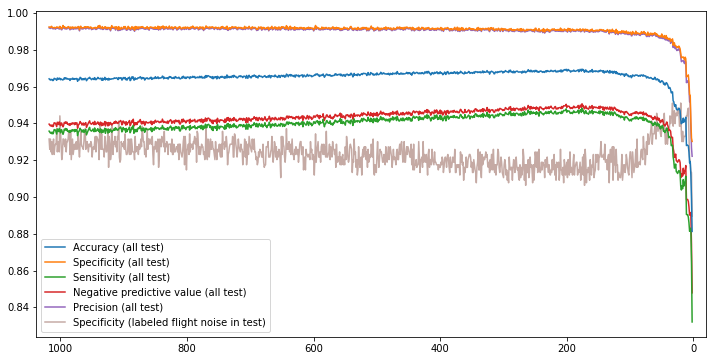

In [100]:
plt.figure(figsize=(12,6))
for i, (dataset_mask, prop_name, label, alpha) in enumerate([
        ('all', 'accuracy', 'Accuracy (all test)', 1),
        ('all', 'specificity', 'Specificity (all test)', 1),
        ('all', 'sensitivity', 'Sensitivity (all test)', 1),
        ('all', 'negative_predictive_value', 'Negative predictive value (all test)', 1),
        ('all', 'precision', 'Precision (all test)', 1),
        ('lbl_noise_flight', 'specificity', 'Specificity (labeled flight noise in test)', 0.5)]):
    plt.plot(
        rfe_selectors_on_extra_tree_scores[1], 
        [ds['test'][dataset_mask][prop_name] for ds in rfe_selectors_on_extra_tree_scores[0]],
        marker='', linestyle='-', zorder=90-i, alpha=alpha, label=label
    )
plt.legend()
plt.xlim(20+max(rfe_selectors_on_extra_tree_scores[1]), 0-20)
# plt.savefig(os.path.join(data_snippets_dir, 'figures', 'rfe_selectors_on_extra_tree_scores_plot.svg'))
plt.show()

In [101]:
len(rfe_selectors_on_extra_tree_scores[0])

1017

The number should be 1018 - requires further investigation

RFECV does this but with mutiple folds of train-test data.

#### Performance on test set

In [102]:
n_features_list = []
rfe_test_numbers_stats_list = []
rfe_test_lbl_noise_numbers_stats_list = []

for n_features_to_select, rfe_selector_on_extra_trees_cls in rfe_selector_on_extra_trees_cls_dict.items():
    print('RFE: n_features_to_select={:d}'.format(n_features_to_select))
    print('-' * 60)
    
    y_test = learning_data__y_test
    y_test_pred = rfe_selector_on_extra_trees_cls.predict(learning_data__var_th_X_test)

    print('Confusion matrix:')
    print_confusion_matrix(y_test, y_test_pred, output_format='ipython_html_styled')

    print_accuracy_cls_report(y_test, y_test_pred)

    print('Labeled flight noise (lbl_noise_flight):')
    
    print_labeled_data_cls_stats(
        mask_arr_test=learning_data__lbl_noise_flight_mask_arr_test,
        y_test=y_test, y_test_pred=y_test_pred)
    
    n_features_list.append(n_features_to_select)
    rfe_test_numbers_stats_list.append(calc_cls_numbers_stats(y_test, y_test_pred))
    rfe_test_lbl_noise_numbers_stats_list.append(calc_cls_numbers_stats(y_test[learning_data__lbl_noise_flight_mask_arr_test], y_test_pred[learning_data__lbl_noise_flight_mask_arr_test]))
    
#     rfe_numbers_stats_list.append(calc_cls_numbers_stats(y_test, y_test_pred))
    
    print('=' * 60)

RFE: n_features_to_select=1
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.88

Classification report:
             precision    recall  f1-score   support

      noise       0.84      0.92      0.88     12770
 air shower       0.91      0.83      0.87     12688

avg / total       0.88      0.88      0.88     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.82
Num. negative               715
Num. true negative          589
Num. false positive         126
Specificity                 0.82
Fallout                     0.18
RFE: n_features_to_select=5
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.92

Classification report:
             precision    recall  f1-score   support

      noise       0.89      0.96      0.92     12770
 air shower       0.95      0.88      0.92     12688

avg / total       0.92      0.92      0.92     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          657
Num. false positive         58
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=10
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.93

Classification report:
             precision    recall  f1-score   support

      noise       0.90      0.97      0.93     12770
 air shower       0.96      0.89      0.93     12688

avg / total       0.93      0.93      0.93     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.94
Num. negative               715
Num. true negative          675
Num. false positive         40
Specificity                 0.94
Fallout                     0.06
RFE: n_features_to_select=15
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.94

Classification report:
             precision    recall  f1-score   support

      noise       0.91      0.98      0.94     12770
 air shower       0.97      0.91      0.94     12688

avg / total       0.94      0.94      0.94     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.93
Num. negative               715
Num. true negative          667
Num. false positive         48
Specificity                 0.93
Fallout                     0.07
RFE: n_features_to_select=20
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.94

Classification report:
             precision    recall  f1-score   support

      noise       0.91      0.98      0.94     12770
 air shower       0.98      0.91      0.94     12688

avg / total       0.94      0.94      0.94     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.95
Num. negative               715
Num. true negative          680
Num. false positive         35
Specificity                 0.95
Fallout                     0.05
RFE: n_features_to_select=25
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.95

Classification report:
             precision    recall  f1-score   support

      noise       0.92      0.98      0.95     12770
 air shower       0.98      0.91      0.95     12688

avg / total       0.95      0.95      0.95     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.95
Num. negative               715
Num. true negative          678
Num. false positive         37
Specificity                 0.95
Fallout                     0.05
RFE: n_features_to_select=30
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.95

Classification report:
             precision    recall  f1-score   support

      noise       0.92      0.98      0.95     12770
 air shower       0.98      0.92      0.95     12688

avg / total       0.95      0.95      0.95     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.95
Num. negative               715
Num. true negative          677
Num. false positive         38
Specificity                 0.95
Fallout                     0.05
RFE: n_features_to_select=40
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.96

Classification report:
             precision    recall  f1-score   support

      noise       0.94      0.99      0.96     12770
 air shower       0.98      0.93      0.96     12688

avg / total       0.96      0.96      0.96     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.93
Num. negative               715
Num. true negative          667
Num. false positive         48
Specificity                 0.93
Fallout                     0.07
RFE: n_features_to_select=50
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.96

Classification report:
             precision    recall  f1-score   support

      noise       0.94      0.99      0.96     12770
 air shower       0.99      0.94      0.96     12688

avg / total       0.96      0.96      0.96     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.94
Num. negative               715
Num. true negative          670
Num. false positive         45
Specificity                 0.94
Fallout                     0.06
RFE: n_features_to_select=60
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.96

Classification report:
             precision    recall  f1-score   support

      noise       0.94      0.99      0.97     12770
 air shower       0.99      0.94      0.96     12688

avg / total       0.97      0.96      0.96     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.94
Num. negative               715
Num. true negative          669
Num. false positive         46
Specificity                 0.94
Fallout                     0.06
RFE: n_features_to_select=70
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.96

Classification report:
             precision    recall  f1-score   support

      noise       0.94      0.99      0.97     12770
 air shower       0.99      0.94      0.96     12688

avg / total       0.97      0.96      0.96     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.93
Num. negative               715
Num. true negative          664
Num. false positive         51
Specificity                 0.93
Fallout                     0.07
RFE: n_features_to_select=80
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.94      0.99      0.97     12770
 air shower       0.99      0.94      0.96     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          658
Num. false positive         57
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=90
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.94      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          655
Num. false positive         60
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=100
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.94      0.99      0.97     12770
 air shower       0.99      0.94      0.96     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          661
Num. false positive         54
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=110
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.94      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          656
Num. false positive         59
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=120
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.94      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          656
Num. false positive         59
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=130
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.95      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          657
Num. false positive         58
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=140
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.95      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.93
Num. negative               715
Num. true negative          664
Num. false positive         51
Specificity                 0.93
Fallout                     0.07
RFE: n_features_to_select=150
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.95      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.91
Num. negative               715
Num. true negative          654
Num. false positive         61
Specificity                 0.91
Fallout                     0.09
RFE: n_features_to_select=160
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.95      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          656
Num. false positive         59
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=170
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.95      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          658
Num. false positive         57
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=180
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.95      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          655
Num. false positive         60
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=190
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.95      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          657
Num. false positive         58
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=200
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.95      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          657
Num. false positive         58
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=210
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.95      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.93
Num. negative               715
Num. true negative          662
Num. false positive         53
Specificity                 0.93
Fallout                     0.07
RFE: n_features_to_select=220
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.95      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          660
Num. false positive         55
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=230
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.95      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          655
Num. false positive         60
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=240
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.95      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          657
Num. false positive         58
Specificity                 0.92
Fallout                     0.08
RFE: n_features_to_select=250
------------------------------------------------------------
Confusion matrix:


Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.95      0.97     12688

avg / total       0.97      0.97      0.97     25458

Labeled flight noise (lbl_noise_flight):
Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          661
Num. false positive         54
Specificity                 0.92
Fallout                     0.08


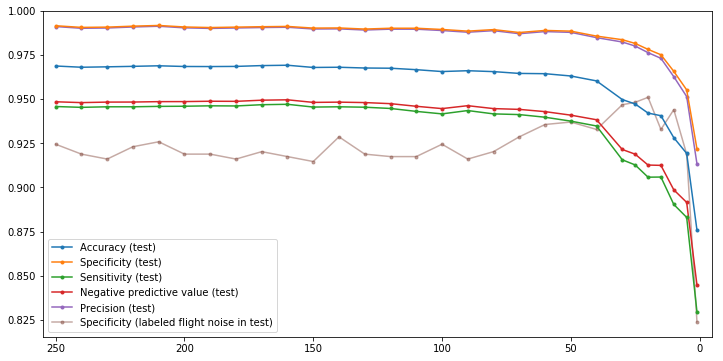

In [103]:
plt.figure(figsize=(12,6))
for i, (dataset, prop_name, label, alpha) in enumerate([
        (rfe_test_numbers_stats_list, 'accuracy', 'Accuracy (test)', 1),
        (rfe_test_numbers_stats_list, 'specificity', 'Specificity (test)', 1),
        (rfe_test_numbers_stats_list, 'sensitivity', 'Sensitivity (test)', 1),
        (rfe_test_numbers_stats_list, 'negative_predictive_value', 'Negative predictive value (test)', 1),
        (rfe_test_numbers_stats_list, 'precision', 'Precision (test)', 1),
        (rfe_test_lbl_noise_numbers_stats_list, 'specificity', 'Specificity (labeled flight noise in test)', 0.5)]):
    plt.plot(
        n_features_list, 
        [entry[prop_name] for entry in dataset],
        marker='.', linestyle='-', zorder=90-i, alpha=alpha, label=label
    )
plt.legend()
plt.xlim(5+max(n_features_list), 0-5)
# plt.savefig(os.path.join(data_snippets_dir, 'figures', 'rfe_selectors_on_extra_tree_scores_plot__feat_from_200_to_1.svg'))
plt.show()

#### Cross-validation

In [104]:
n_features_list = []
mean_accuracy_list = []
std_accuracy_list = []
mean_accuracy_lbl_noise_list = []
std_accuracy_lbl_noise_list = []

for n_features_to_select, rfe_selector_on_extra_trees_cls in rfe_selector_on_extra_trees_cls_dict.items():
    print('RFE: n_features_to_select={:d}'.format(n_features_to_select))
    print('-' * 30)
        
    extra_trees_cls_on_train_rfe_for_crossvalidation = sklearn.ensemble.ExtraTreesClassifier(**rfe_extra_trees_params)

    # not entirely correct, feature selection should be also included in crossvalidation training

    learning_data__rfe_var_th_X = \
        rfe_selector_on_extra_trees_cls.transform(
            var_th_selector_on_scaled_train.transform(
        #TODO 
                learning_data__X
            )
        )

    extra_trees_cls_on_train_rfe_for_crossvalidation_crv_results = \
        sklearn.model_selection.cross_val_score(
            extra_trees_cls_on_train_rfe_for_crossvalidation, 
            learning_data__rfe_var_th_X, learning_data__y, 
            n_jobs=-1, cv=5)
    
    print('Cross-validation accuracy:', extra_trees_cls_on_train_rfe_for_crossvalidation_crv_results)
    print('Mean accuracy:            ', np.mean(extra_trees_cls_on_train_rfe_for_crossvalidation_crv_results))
    print('Std accuracy:             ', np.std(extra_trees_cls_on_train_rfe_for_crossvalidation_crv_results))
    
    extra_trees_cls_on_train_rfe_for_crossvalidation_lbl_noise_flight_crv_results = \
    cross_val_score_meta_scored(
        extra_trees_cls_on_train_rfe_for_crossvalidation,
        learning_data__rfe_var_th_X, learning_data__y, 
        score_masked_using_indices_lbl_noise_flight_mask_arr_all,
        cv=5, 
        random_state=32, verbose=1
    )
    
    print('Cross-validation accuracy (lbl_noise):', extra_trees_cls_on_train_rfe_for_crossvalidation_lbl_noise_flight_crv_results)
    print('Mean accuracy (lbl_noise):            ', np.mean(extra_trees_cls_on_train_rfe_for_crossvalidation_lbl_noise_flight_crv_results))
    print('Std accuracy (lbl_noise):             ', np.std(extra_trees_cls_on_train_rfe_for_crossvalidation_lbl_noise_flight_crv_results))
    
    print('=' * 30)
    
    if n_features_to_select > 90:
        break

RFE: n_features_to_select=1
------------------------------
Cross-validation accuracy: [0.84972506 0.89583661 0.86651477 0.90226273 0.86329353]
Mean accuracy:             0.8755265379740615
Std accuracy:              0.020119133097055732
0/5
len(X_train): 50915
len(X_test): 12729
1/5
len(X_train): 50915
len(X_test): 12729
2/5
len(X_train): 50915
len(X_test): 12729
3/5
len(X_train): 50915
len(X_test): 12729
4/5
len(X_train): 50916
len(X_test): 12728
Cross-validation accuracy (lbl_noise): [0.8202247191011236, 0.8591160220994475, 0.8171091445427728, 0.8028169014084507, 0.8195876288659794]
Mean accuracy (lbl_noise):             0.8237708832035547
Std accuracy (lbl_noise):              0.018776591039473968
RFE: n_features_to_select=5
------------------------------
Cross-validation accuracy: [0.90023566 0.88641005 0.91271213 0.94767442 0.92214016]
Mean accuracy:             0.9138344863067639
Std accuracy:              0.020748071618050295
0/5
len(X_train): 50915
len(X_test): 12729
1/5
len(X_

Cross-validation accuracy: [0.94642577 0.96944226 0.96433061 0.97682275 0.9619736 ]
Mean accuracy:             0.9637989984906259
Std accuracy:              0.010068848031182917
0/5
len(X_train): 50915
len(X_test): 12729
1/5
len(X_train): 50915
len(X_test): 12729
2/5
len(X_train): 50915
len(X_test): 12729
3/5
len(X_train): 50915
len(X_test): 12729
4/5
len(X_train): 50916
len(X_test): 12728
Cross-validation accuracy (lbl_noise): [0.9325842696629213, 0.9281767955801105, 0.9144542772861357, 0.9154929577464789, 0.9123711340206185]
Mean accuracy (lbl_noise):             0.920615886859253
Std accuracy (lbl_noise):              0.008155921924791724
RFE: n_features_to_select=90
------------------------------
Cross-validation accuracy: [0.945326   0.96975648 0.96425204 0.97627278 0.96165933]
Mean accuracy:             0.9634533286460615
Std accuracy:              0.010358808053115934
0/5
len(X_train): 50915
len(X_test): 12729
1/5
len(X_train): 50915
len(X_test): 12729
2/5
len(X_train): 50915
le

(TODO plot, maybe also compared to version without crossvalidation)

### Recursive Feature Elimination with cross-validation (RFECV)

The recursive feature elimination with cross-validation should find the optimal list of features achieving the best classification accuracy. 
Using standard recursive feature elimination method, this method tests all possible feature counts by decreasing number of features from whole feature set to a single feature (this can be limited by a configuration). Then this test is performed several times with different train-test splits of data. Then the final number of features is decided by a maximum summed score of models fitted with same number of features but different train-test splits. Then the final run of the recursive feature elimination algorithm with number of features from the previous step finds the most optimal features.

Model trained in this step will be saved and used for classification of triggered (bgf=1) and flight events. Also sensitivity of this model will be later plotted as a function of various simulated attributes (energy, arrival angles).

In [105]:
load_rfecv_from_file = True
overwrite_existing_rfecv_model_files = False
recreate_rfecv_pipline_object = False

In [106]:
extra_trees_cls_on_train_rfecv__model_pkl_pathname = \
    os.path.join(data_snippets_dir, 'extra_trees_cls_on_train_rfecv.pkl')
pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname = \
    os.path.join(data_snippets_dir, 'pipeline_from_trained_models__extr_rfecv_vth.pkl')

In [107]:
# standard_scaler_on_train, var_th_selector_on_scaled_train, 
# k400best_f_classif_selector_on_var_th_sc_train, rfecv_selector_on_extra_trees_cls,
# extra_trees_cls_on_train_kbest400_128_est

In [108]:
# not in the report
load_rfecv_from_file and os.path.exists(pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname)

True

#### Training or loading the model

In [109]:
len(learning_data__var_th_X_train)

38186

In [110]:
pipeline_from_trained_models__extr_rfecv_vth_scale  = None

if load_rfecv_from_file and os.path.exists(pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname):
    print('Loading existing model pipeline:', pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname)
    pipeline_from_trained_models__extr_rfecv_vth = \
        joblib.load(pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname)
    
    rfecv_selector_on_extra_trees_cls = pipeline_from_trained_models__extr_rfecv_vth.steps[-1][1]
    extra_trees_cls_on_train_rfecv = rfecv_selector_on_extra_trees_cls.estimator_
    
else:
    X_train = learning_data__var_th_X_train
    y_train = learning_data__y_train

    X_test = learning_data__var_th_X_test
    y_test = learning_data__y_test

    extra_trees_cls_for_rfecv = sklearn.ensemble.ExtraTreesClassifier(**rfe_extra_trees_params)

    rfecv_selector_on_extra_trees_cls = sklearn.feature_selection.RFECV(
        estimator=extra_trees_cls_for_rfecv, 
        step=1, verbose=1, n_jobs=-1)

    rfecv_selector_on_extra_trees_cls.fit(X_train, y_train)

Loading existing model pipeline: ver4_machine_learning_w_labeled_flight_20190217/pipeline_from_trained_models__extr_rfecv_vth.pkl


In [111]:
rfecv_selector_on_extra_trees__column_names = \
    [n for n, m in zip(learning_data__var_th_scaled_columns, rfecv_selector_on_extra_trees_cls.get_support()) if m]

In [112]:
print(len(rfecv_selector_on_extra_trees__column_names))

232


#### Saving the model

In [113]:
if overwrite_existing_rfecv_model_files or not os.path.exists(extra_trees_cls_on_train_rfecv__model_pkl_pathname):
    print(extra_trees_cls_on_train_rfecv__model_pkl_pathname)
    joblib.dump(rfecv_selector_on_extra_trees_cls.estimator_, 
                extra_trees_cls_on_train_rfecv__model_pkl_pathname, 
                compress=1)
else:
    print("(Already exists)\t{}".format(extra_trees_cls_on_train_rfecv__model_pkl_pathname))

(Already exists)	ver4_machine_learning_w_labeled_flight_20190217/extra_trees_cls_on_train_rfecv.pkl


In [114]:
rfecv_selector_on_extra_trees_cls.estimator_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

##### Whole pipeline

In [115]:
if pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname is None or recreate_rfecv_pipline_object:
    pipeline_from_trained_models__extr_rfecv_vth = \
        sklearn.pipeline.make_pipeline(
            #standard_scaler_on_train, 
            var_th_selector_on_scaled_train, 
#             k400best_f_classif_selector_on_var_th_sc_train, 
            rfecv_selector_on_extra_trees_cls
        )
    print(pipeline_from_trained_models__extr_rfecv_vth)

In [116]:
if pipeline_from_trained_models__extr_rfecv_vth is not None and \
        (overwrite_existing_rfecv_model_files or \
         not os.path.exists(pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname)):
    print('Saving pipeline', pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname)
    joblib.dump(pipeline_from_trained_models__extr_rfecv_vth, 
                pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname,
                compress=1)
else:
    print("(Already exists)\t{}".format(pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname))

(Already exists)	ver4_machine_learning_w_labeled_flight_20190217/pipeline_from_trained_models__extr_rfecv_vth.pkl


##### Creating a list of selected columns and a scaler for the columns

In [117]:
columns_list_file_pathname = os.path.join(data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names.txt')
if not os.path.exists(columns_list_file_pathname) or recreate_rfecv_pipline_object:
    print('Writing columns list into:', columns_list_file_pathname)
    with open(columns_list_file_pathname, 'w') as columns_list_file:
        for col_name in rfecv_selector_on_extra_trees__column_names:
            if col_name in common_df_columns:
                print(col_name, file=columns_list_file)
else:
    print('(Already exists) ', columns_list_file_pathname)

(Already exists)  ver4_machine_learning_w_labeled_flight_20190217/rfecv_selector_on_extra_trees__column_names.txt


In [118]:
special_columns_list_file_pathname = os.path.join(data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names__special.txt')
if not os.path.exists(special_columns_list_file_pathname) or recreate_rfecv_pipline_object:
    print('Writing special columns list into:', special_columns_list_file_pathname)
    with open(special_columns_list_file_pathname, 'w') as special_columns_list_file:
        for col_name in rfecv_selector_on_extra_trees__column_names:
            if col_name not in common_df_columns:
                print(col_name, file=special_columns_list_file)
else:
    print('(Already exists) ', special_columns_list_file_pathname)

(Already exists)  ver4_machine_learning_w_labeled_flight_20190217/rfecv_selector_on_extra_trees__column_names__special.txt


In [119]:
np.count_nonzero(~np.isin(rfecv_selector_on_extra_trees__column_names, common_df_columns))

0

##### StandardScaler on columns selected by RFECV

In [120]:
# column_indices_rfecv_in_analyzed_common = [analyzed_common_df_columns.index(attr) for attr in rfecv_selector_on_extra_trees__column_names]

In [121]:
# standard_scaler_on_train_rfecv_columns = sklearn.preprocessing.StandardScaler()
# standard_scaler_on_train_rfecv_columns.fit(learning_data__X_train.T[column_indices_rfecv_in_analyzed_common].T)

##### Consistency check
(not in the report)

Check if both scalers produce same resuls.

###### StandardScaler on columns selected by RFECV

In [122]:
# np.sum(np.round(
#     standard_scaler_on_train_rfecv_columns.transform(
#         learning_data__X_train.T[column_indices_rfecv_in_analyzed_common].T)*10000))

###### StandardScaler on all columns

In [123]:
# np.sum(np.round(
#     rfecv_selector_on_extra_trees_cls.transform(
#         k400best_f_classif_selector_on_var_th_sc_train.transform(
#             var_th_selector_on_scaled_train.transform(
#                 standard_scaler_on_train.transform(learning_data__X_train)
#             )
#         )
#     )*10000))

##### Check of columns count of the scaler 

In [124]:
# len(standard_scaler_on_train_rfecv_columns.scale_)

##### Saving the scaler into a file
All data should be scaled with it before classification.

In [125]:
# standard_scaler_on_train_rfecv_columns_pathname = os.path.join(data_snippets_dir, 'standard_scaler_on_train_rfecv_columns.pkl')

# if standard_scaler_on_train_rfecv_columns is not None and \
#         (overwrite_existing_rfecv_model_files or \
#          not os.path.exists(standard_scaler_on_train_rfecv_columns_pathname)):
#     print(standard_scaler_on_train_rfecv_columns_pathname)
#     joblib.dump(standard_scaler_on_train_rfecv_columns, 
#                 standard_scaler_on_train_rfecv_columns_pathname,
#                 compress=1)
# else:
#     print("(Already exists)\t{}".format(standard_scaler_on_train_rfecv_columns_pathname))

#### Columns selected by RFECV

(cell not in the report)

In each iteration, the RFE.ranking_ attribute item (representing a feature) is increased if the feature is dropped -number of iterations + 1 in whitch feature was rejected - first beacause of having low importance (or coeficient), then because of not being considered.

In [126]:
# not in the report
for n, m, sc in \
        sorted(
            zip(
                learning_data__var_th_scaled_columns, 
                rfecv_selector_on_extra_trees_cls.get_support(), 
                rfecv_selector_on_extra_trees_cls.ranking_
            ), 
            key=lambda x: x[2]) :
    if m:
        print("{:<100} {:<}".format(n,sc))

trg_box_per_gtu_max                                                                                  1
trg_box_per_gtu_sum                                                                                  1
trg_box_per_gtu_mean                                                                                 1
trg_pmt_per_gtu_sum                                                                                  1
trg_pmt_per_gtu_mean                                                                                 1
trg_ec_per_gtu_sum                                                                                   1
trg_ec_per_gtu_mean                                                                                  1
trg_x_y_clusters_sizes_min                                                                           1
trg_x_y_clusters_sizes_max                                                                           1
trg_x_y_clusters_clu_areas_max                                           

proc3_x_y_hough_peak_thr1_line_clusters_max_peak_clu_size                                            1
proc3_x_y_hough_peak_thr1_line_clusters_max_sum_clu_size                                             1
proc3_x_y_hough_peak_thr2_major_line_phi                                                             1
proc3_x_y_hough_peak_thr2_line_clusters_count                                                        1
proc3_x_y_hough_peak_thr2_line_clusters_clu_heights_max                                              1
proc3_x_y_hough_peak_thr3_major_line_coord_1_x                                                       1
proc3_x_y_hough_peak_thr3_line_clusters_count                                                        1
proc3_x_y_hough_peak_thr3_line_clusters_clu_heights_max                                              1
proc1_gtu_x_hough_peak_thr1_major_line_rho                                                           1
proc1_gtu_x_hough_peak_thr2_major_line_rho                               

The following listing shows feature importances from an extra trees classifier trained with the features selected by the RFECV procedure.

In [127]:
# creating sorted list of columns
# learning_data__var_th_scaled_columns
importances = rfecv_selector_on_extra_trees_cls.estimator_.feature_importances_  #232
indices = np.argsort(importances)[::-1]

rfecv_selector_on_extra_trees__column_names_indices_importances__sorted = \
    sorted(
        [
            (rfecv_selector_on_extra_trees__column_names[indices[f]], indices[f], importances[indices[f]]) \
            for f in range(
                rfecv_selector_on_extra_trees_cls.transform(learning_data__var_th_X_train).shape[1]
            ) 
        ], 
        key=lambda e: e[2],
        reverse=True
    )

for i, (column_name, column_indice, column_importance) in \
        enumerate(rfecv_selector_on_extra_trees__column_names_indices_importances__sorted):
    print('{:<5d} {:<70}{:.4f}   {:.6f}  {}'.format(
        i+1, column_name,column_importance, 
        rfecv_selector_on_extra_trees_cls.grid_scores_[i],
        '|'*int(np.round((rfecv_selector_on_extra_trees_cls.grid_scores_[i]/np.max(rfecv_selector_on_extra_trees_cls.grid_scores_))*100 -80))
    ))


rfecv_selector_on_extra_trees__column_names__sorted = \
    [e[0] for e in rfecv_selector_on_extra_trees__column_names_indices_importances__sorted]

rfecv_selector_on_extra_trees__column_indices__sorted = \
    [e[1] for e in rfecv_selector_on_extra_trees__column_names_indices_importances__sorted]

1     proc2_x_y_hough_peak_thr1_line_clusters_count                         0.0223   0.875321  |||||||||||
2     trg_x_y_hough_peak_thr1_line_clusters_max_size_clu_width              0.0217   0.880480  |||||||||||
3     trg_x_y_hough_peak_thr1_line_clusters_clu_widths_max                  0.0212   0.890745  ||||||||||||
4     trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_width              0.0201   0.908841  ||||||||||||||
5     proc2_x_y_hough_peak_thr1_line_clusters_clu_widths_max                0.0170   0.918949  |||||||||||||||
6     proc3_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width             0.0168   0.921961  |||||||||||||||
7     proc3_x_y_hough_peak_thr2_line_clusters_count                         0.0167   0.924842  ||||||||||||||||
8     proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width            0.0167   0.923873  ||||||||||||||||
9     alt1_x_y_hough_peak_thr1_line_clusters_max_area_clu_width             0.0156   0.923532  ||||||||||||||||
10    trg_

197   trg_gtu_x_hough_peak_thr1_major_line_rho                              0.0018   0.965904  ||||||||||||||||||||
198   proc1_gtu_x_hough_peak_thr1_major_line_rho                            0.0018   0.965380  ||||||||||||||||||||
199   proc2_x_y_hough_peak_thr3_major_line_coord_1_x                        0.0018   0.965432  ||||||||||||||||||||
200   proc2_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_size           0.0018   0.965066  ||||||||||||||||||||
201   proc2_gtu_y_clusters_sizes_min                                        0.0018   0.965511  ||||||||||||||||||||
202   trg_gtu_x_hough_peak_thr3_major_line_rho                              0.0018   0.964935  ||||||||||||||||||||
203   proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_height           0.0018   0.965406  ||||||||||||||||||||
204   proc3_gtu_y_clusters_max_peak_clu_width                               0.0017   0.965039  ||||||||||||||||||||
205   trg_x_y_hough_peak_thr1_line_clusters_max_size_clu_height         

#### Checking consistency
(not in the report)

In [128]:
rfecv_selector_on_extra_trees_cls.transform(learning_data__var_th_X_train).shape[1]

232

In [129]:
len(rfecv_selector_on_extra_trees_cls.estimator_.feature_importances_)

232

In [130]:
len(rfecv_selector_on_extra_trees_cls.support_)

1018

In [131]:
max(rfecv_selector_on_extra_trees__column_names)

'trg_x_y_hough_peak_thr3_major_line_rho'

In [132]:
max(rfecv_selector_on_extra_trees__column_indices__sorted)

231

In [133]:
len(rfecv_selector_on_extra_trees__column_names)

232

In [134]:
np.sum(rfecv_selector_on_extra_trees_cls.support_)

232

In [135]:
len(learning_data__var_th_scaled_columns)

1018

In [136]:
# learning_data__rfecv_selector_on_extra_trees_cls_columns_sorted_table = \
#     make_feature_importance_table_df(rfecv_selector_on_extra_trees_cls.estimator_, rfecv_selector_on_extra_trees__column_names)

# learning_data__rfecv_var_th_sc_columns_sorted_table = merge_feature_score_table_dfs(
#     learning_data__all_var_th_sc_columns_sorted_table,
#     learning_data__rfecv_selector_on_extra_trees_cls_columns_sorted_table,
#     'rfecv_extr_tr'
# ).sort_values('score_rfecv_extr_tr', ascending=[False])

In [137]:
# pd.set_option("display.max_rows", 2000)
# pd.set_option("display.max_colwidth", -1)

In [138]:
# learning_data__rfecv_var_th_sc_columns_sorted_table

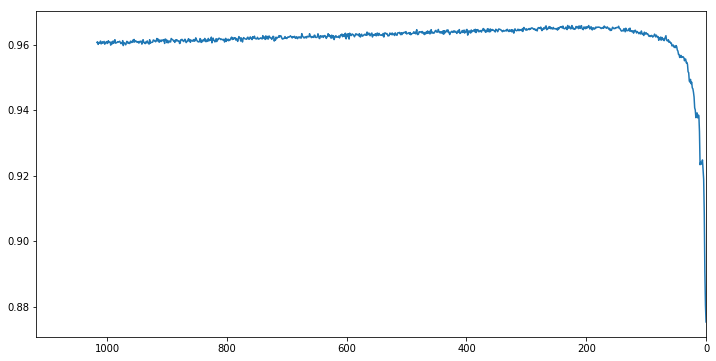

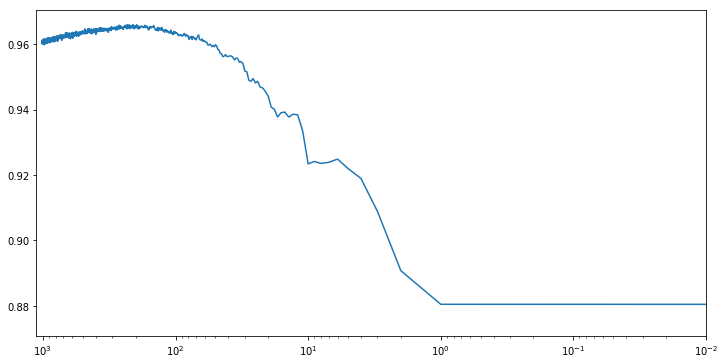

In [139]:
for xscale in ('linear', 'log'):
    fig = plt.figure(figsize=(12,6))
    plt.plot(
        range(len(rfecv_selector_on_extra_trees_cls.grid_scores_)), 
        rfecv_selector_on_extra_trees_cls.grid_scores_,
        marker='', linestyle='-', 
    )
    plt.gca().set_xscale(xscale)
    # plt.legend()
    plt.xlim(100+len(rfecv_selector_on_extra_trees_cls.grid_scores_), 0.01)
#     plt.savefig(os.path.join(data_snippets_dir, 'figures', 'rfecv_selectors_on_extra_tree_scores_plot_{}.svg'.format(xscale)), dpi=150)
    plt.show()

#### Comparison of scores as function of feature number

part of ver4_machine_learning_w_labeled_flight_20190217.ipynb notebook

#### Importances of interesting features

part of ver4_machine_learning_w_labeled_flight_20190217.ipynb notebook

### T-SNE (RFECV features)
*T-SNE visualization of the learning data (both training and testing)*

Moved to ver4_machine_learning_w_labeled_flight_20190217_dimensionality_reduction.ipynb notebook

### Performance of the ExtraTreesClassifier model with RFECV features

In [140]:
y_test = learning_data__y_test
y_test_pred = rfecv_selector_on_extra_trees_cls.predict(learning_data__var_th_X_test)

print(sklearn.metrics.confusion_matrix(
    y_test, 
    y_test_pred))

print_accuracy_cls_report(
    y_test, 
    y_test_pred)

labeled_data_cls_stats = \
    print_labeled_data_cls_stats(
        mask_arr_test=learning_data__lbl_noise_flight_mask_arr_test,
        y_test=y_test,
        y_test_pred=y_test_pred)

[[12648   122]
 [  694 11994]]
Accuracy score:
0.97

Classification report:
             precision    recall  f1-score   support

      noise       0.95      0.99      0.97     12770
 air shower       0.99      0.95      0.97     12688

avg / total       0.97      0.97      0.97     25458

Accuracy score (specificity)0.92
Num. negative               715
Num. true negative          656
Num. false positive         59
Specificity                 0.92
Fallout                     0.08


#### Cross-validation

In [141]:
extra_trees_cls_on_train_rfecv_for_crossvalidation = sklearn.ensemble.ExtraTreesClassifier(**rfe_extra_trees_params)

# not entirely correct, feature selection should be also included in crossvalidation training

learning_data__rfecv_var_th_X = \
    rfecv_selector_on_extra_trees_cls.transform(
#         k400best_f_classif_selector_on_var_th_sc_train.transform(
            var_th_selector_on_scaled_train.transform(
#                 standard_scaler_on_train.transform(
                    learning_data__X
#                 )
            )
#         )
    )

# print(learning_data__rfecv_var_th_X.shape)

extra_trees_cls_on_train_rfecv_for_crossvalidation_crv_results = \
    sklearn.model_selection.cross_val_score(
        extra_trees_cls_on_train_rfecv_for_crossvalidation, 
        learning_data__rfecv_var_th_X, learning_data__y, 
        n_jobs=-1, cv=5)

In [142]:
print('Cross-validation accuracy:', extra_trees_cls_on_train_rfecv_for_crossvalidation_crv_results)
print('Mean accuracy:            ', np.mean(extra_trees_cls_on_train_rfecv_for_crossvalidation_crv_results))
print('Std accuracy:             ', np.std(extra_trees_cls_on_train_rfecv_for_crossvalidation_crv_results))

Cross-validation accuracy: [0.93880597 0.97203456 0.96613765 0.97870836 0.96378064]
Mean accuracy:             0.9638934368153936
Std accuracy:              0.013566061205644115


#### Cross-validation of labeled noise data

##### random_state = 32

In [143]:
extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results = \
    cross_val_score_meta_scored(
        extra_trees_cls_on_train_rfecv_for_crossvalidation,
        learning_data__rfecv_var_th_X, learning_data__y, 
        score_masked_using_indices_lbl_noise_flight_mask_arr_all,
        cv=5, 
        random_state=32, verbose=1
    )

0/5
len(X_train): 50915
len(X_test): 12729
1/5
len(X_train): 50915
len(X_test): 12729
2/5
len(X_train): 50915
len(X_test): 12729
3/5
len(X_train): 50915
len(X_test): 12729
4/5
len(X_train): 50916
len(X_test): 12728


In [144]:
print('Cross-validation accuracy (lbl_noise):', extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results)
print('Mean accuracy (lbl_noise):            ', np.mean(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results))
print('Std accuracy (lbl_noise):             ', np.std(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results))

Cross-validation accuracy (lbl_noise): [0.9213483146067416, 0.9337016574585635, 0.9203539823008849, 0.9070422535211268, 0.8969072164948454]
Mean accuracy (lbl_noise):             0.9158706848764325
Std accuracy (lbl_noise):              0.012693323439808616


##### random_state = 123

In [145]:
extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_2 = \
    cross_val_score_meta_scored(
        extra_trees_cls_on_train_rfecv_for_crossvalidation,
        learning_data__rfecv_var_th_X, learning_data__y, 
        score_masked_using_indices_lbl_noise_flight_mask_arr_all,
        cv=5, 
        random_state=123, verbose=1
    )

0/5
len(X_train): 50915
len(X_test): 12729
1/5
len(X_train): 50915
len(X_test): 12729
2/5
len(X_train): 50915
len(X_test): 12729
3/5
len(X_train): 50915
len(X_test): 12729
4/5
len(X_train): 50916
len(X_test): 12728


In [146]:
print('Cross-validation accuracy (lbl_noise, seed=123):', extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_2)
print('Mean accuracy (lbl_noise, seed=123):            ', np.mean(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_2))
print('Std accuracy (lbl_noise, seed=123):             ', np.std(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_2))

Cross-validation accuracy (lbl_noise, seed=123): [0.9041095890410958, 0.92, 0.9187675070028011, 0.924119241192412, 0.9025069637883009]
Mean accuracy (lbl_noise, seed=123):             0.913900660204922
Std accuracy (lbl_noise, seed=123):              0.008842951245562457


##### Repeated K-Fold, random_state=123

In [147]:
extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_3 = \
    cross_val_score_meta_scored(
        extra_trees_cls_on_train_rfecv_for_crossvalidation,
        learning_data__rfecv_var_th_X, learning_data__y, 
        score_masked_using_indices_lbl_noise_flight_mask_arr_all,
        cv=sklearn.model_selection.RepeatedKFold(n_splits=5, n_repeats=5, random_state=123), verbose=1
    )

0
len(X_train): 50915
len(X_test): 12729
1
len(X_train): 50915
len(X_test): 12729
2
len(X_train): 50915
len(X_test): 12729
3
len(X_train): 50915
len(X_test): 12729
4
len(X_train): 50916
len(X_test): 12728
5
len(X_train): 50915
len(X_test): 12729
6
len(X_train): 50915
len(X_test): 12729
7
len(X_train): 50915
len(X_test): 12729
8
len(X_train): 50915
len(X_test): 12729
9
len(X_train): 50916
len(X_test): 12728
10
len(X_train): 50915
len(X_test): 12729
11
len(X_train): 50915
len(X_test): 12729
12
len(X_train): 50915
len(X_test): 12729
13
len(X_train): 50915
len(X_test): 12729
14
len(X_train): 50916
len(X_test): 12728
15
len(X_train): 50915
len(X_test): 12729
16
len(X_train): 50915
len(X_test): 12729
17
len(X_train): 50915
len(X_test): 12729
18
len(X_train): 50915
len(X_test): 12729
19
len(X_train): 50916
len(X_test): 12728
20
len(X_train): 50915
len(X_test): 12729
21
len(X_train): 50915
len(X_test): 12729
22
len(X_train): 50915
len(X_test): 12729
23
len(X_train): 50915
len(X_test): 12729
24

In [148]:
print('Cross-validation accuracy (lbl_noise):', extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_3)
print('Mean accuracy (lbl_noise):            ', np.mean(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_3))
print('Std accuracy (lbl_noise):             ', np.std(extra_trees_cls_on_train_rfecv_for_crossvalidation_lbl_noise_flight_crv_results_3))

Cross-validation accuracy (lbl_noise): [0.9041095890410958, 0.92, 0.9187675070028011, 0.924119241192412, 0.9025069637883009, 0.9, 0.8839779005524862, 0.94, 0.919889502762431, 0.9375, 0.8935064935064935, 0.9266304347826086, 0.9166666666666666, 0.9357798165137615, 0.9220430107526881, 0.9138888888888889, 0.9026548672566371, 0.918918918918919, 0.9189944134078212, 0.9088471849865952, 0.9051490514905149, 0.9453551912568307, 0.8815028901734104, 0.940379403794038, 0.9171428571428571]
Mean accuracy (lbl_noise):             0.9159332317551303
Std accuracy (lbl_noise):              0.016506065969279716


## Recognition efficiency (RFECV model)

### Comparison of confidence interval approaches

positive_sm_confint_normal_95
--------------------------------------------------
[0.10705582 0.04984152 0.03512578 0.02484526 0.01939401 0.01361225
 0.01479227 0.01558679 0.01528634 0.01717132 0.01232612 0.01455156
 0.01307507 0.00912109 0.01811306 0.01081991 0.01421383 0.01467652]
**************************************************
[0.10705582 0.04984152 0.03512578 0.02484526 0.01939401 0.01361225
 0.01479227 0.01558679 0.01528634 0.01717132 0.01232612 0.01455156
 0.01307507 0.00912109 0.01811306 0.01081991 0.01030928 0.01467652]
**************************************************
[0.21411163 0.09968304 0.07025155 0.04969052 0.03878802 0.02722449
 0.02958454 0.03117357 0.03057268 0.03434264 0.02465223 0.02910311
 0.02615013 0.01824217 0.03622611 0.02163983 0.02452311 0.02935305]


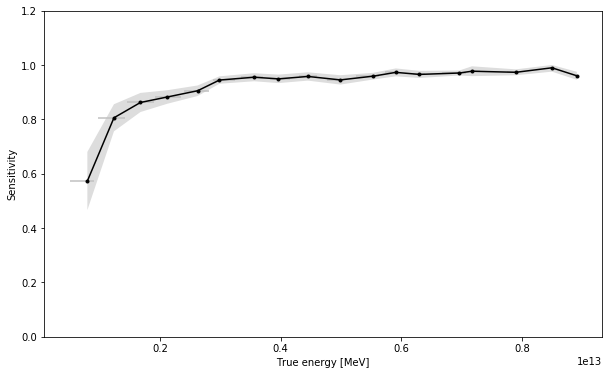

positive_sm_confint_beta_95
--------------------------------------------------
[0.1141167  0.05554358 0.03938188 0.02738284 0.02135155 0.01532561
 0.0173303  0.01805548 0.01820242 0.01995169 0.01425399 0.01882301
 0.01569686 0.01060865 0.02627556 0.01316112 0.02643327 0.0175405 ]
**************************************************
[0.10867353 0.04788361 0.03345693 0.02382573 0.01857552 0.01284995
 0.01364794 0.01448065 0.01396803 0.01593011 0.01145371 0.01261161
 0.011883   0.00844053 0.01445128 0.00975055 0.00905833 0.01337924]
**************************************************
[0.22279024 0.10342719 0.07283881 0.05120857 0.03992707 0.02817556
 0.03097824 0.03253613 0.03217045 0.0358818  0.0257077  0.03143462
 0.02757986 0.01904918 0.04072684 0.02291167 0.03549159 0.03091974]


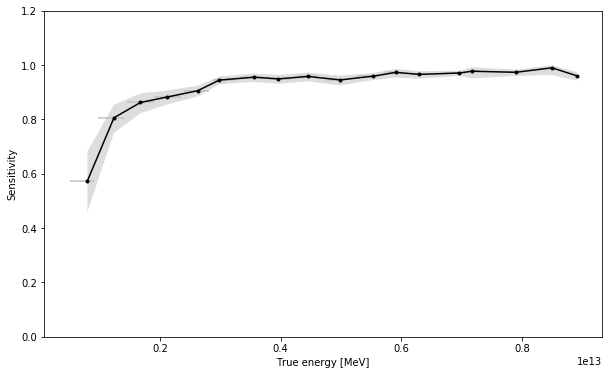

positive_sm_confint_agresti_coull_95
--------------------------------------------------
[0.10800756 0.05468468 0.03905837 0.02723672 0.02128174 0.0153383
 0.01741229 0.01811092 0.01832291 0.0200076  0.01431286 0.01919761
 0.01583228 0.01067259 0.02733224 0.01331167 0.02892908 0.0176696 ]
**************************************************
[0.10145869 0.04512843 0.03161547 0.02271626 0.01774302 0.01219794
 0.01280596 0.01362394 0.01305597 0.01496913 0.01079031 0.01167351
 0.01109556 0.00794616 0.01354389 0.00908875 0.00991257 0.01249822]
**************************************************
[0.20946625 0.09981311 0.07067384 0.04995298 0.03902476 0.02753624
 0.03021826 0.03173486 0.03137888 0.03497672 0.02510317 0.03087112
 0.02692783 0.01861875 0.04087613 0.02240042 0.03884165 0.03016782]


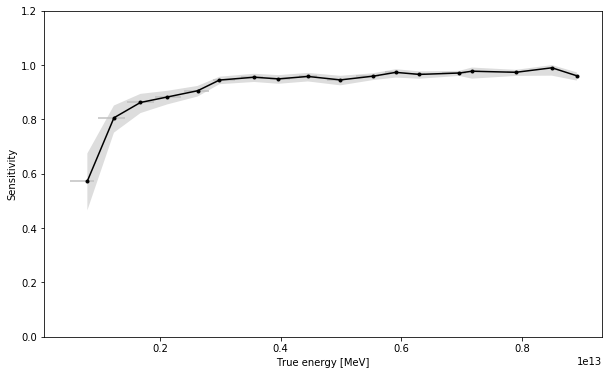

positive_sm_confint_wilson_95
--------------------------------------------------
[0.10795865 0.05445901 0.03886389 0.02713485 0.0212017  0.01524879
 0.01723662 0.01795232 0.01810161 0.01982623 0.01418915 0.0187359
 0.01562341 0.01057253 0.0261522  0.01311175 0.02649404 0.01744759]
**************************************************
[0.10140978 0.04490276 0.03142099 0.02261438 0.01766298 0.01210843
 0.01263029 0.01346533 0.01283467 0.01478776 0.0106666  0.0112118
 0.01088669 0.0078461  0.01236385 0.00888883 0.00747753 0.01227621]
**************************************************
[0.20936843 0.09936177 0.07028488 0.04974923 0.03886469 0.02735722
 0.02986691 0.03141766 0.03093628 0.034614   0.02485575 0.0299477
 0.02651011 0.01841863 0.03851605 0.02200058 0.03397158 0.0297238 ]


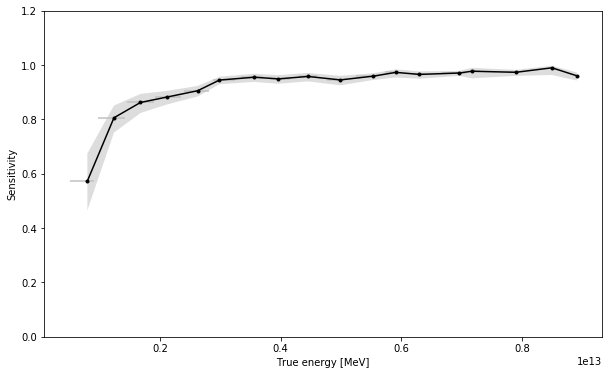

positive_sm_confint_jeffreys_95
--------------------------------------------------
[0.10804888 0.05330421 0.03789818 0.02654201 0.02073068 0.01481256
 0.01656811 0.01731077 0.01732395 0.01910603 0.01368265 0.01752029
 0.01491408 0.01017508 0.02368835 0.01246695 0.02234794 0.01667982]
**************************************************
[0.10298435 0.04604188 0.03226003 0.02312582 0.01805881 0.0124432
 0.01309148 0.01392375 0.0133482  0.01530142 0.01102539 0.01184387
 0.01134049 0.00811969 0.01328687 0.00928296 0.00816096 0.01277678]
**************************************************
[0.21103323 0.09934609 0.07015822 0.04966782 0.03878949 0.02725575
 0.02965959 0.03123452 0.03067215 0.03440744 0.02470805 0.02936416
 0.02625456 0.01829476 0.03697522 0.02174991 0.0305089  0.0294566 ]


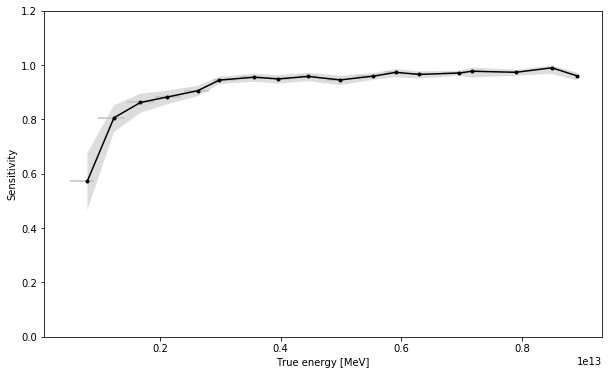

positive_sm_confint_binom_test_95
--------------------------------------------------
[0.12214633 0.05543327 0.03892518 0.02767333 0.02154162 0.01554374
 0.01705397 0.01811468 0.01857484 0.01980743 0.0143906  0.0185046
 0.01577552 0.01048917 0.02611748 0.01323554 0.02724168 0.01744299]
**************************************************
[0.0921014  0.04592156 0.03284198 0.02344762 0.01783373 0.01261137
 0.0128164  0.01393876 0.01300559 0.01501752 0.01118111 0.01191935
 0.01155323 0.00806227 0.01288157 0.00920045 0.00847446 0.01275008]
**************************************************
[0.21424773 0.10135482 0.07176716 0.05112095 0.03937534 0.02815511
 0.02987037 0.03205344 0.03158043 0.03482495 0.02557171 0.03042395
 0.02732876 0.01855144 0.03899906 0.02243599 0.03571614 0.03019307]


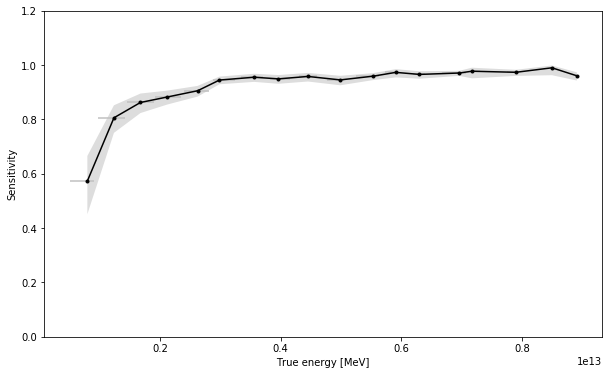

sensitivity_err_mario
--------------------------------------------------
[0.08360554 0.05770347 0.04827181 0.0369577  0.03214641 0.0295203
 0.03556483 0.03522142 0.03798048 0.03742024 0.03101229 0.04506688
 0.03585329 0.02709455 0.0610687  0.03369785 0.07142478 0.03757921]
**************************************************
[0.08360554 0.05770347 0.04827181 0.0369577  0.03214641 0.0295203
 0.03556483 0.03522142 0.03798048 0.03742024 0.03101229 0.04506688
 0.03585329 0.02709455 0.0610687  0.03369785 0.07142478 0.03757921]
**************************************************
[0.16721109 0.11540694 0.09654363 0.0739154  0.06429282 0.05904059
 0.07112965 0.07044284 0.07596097 0.07484048 0.06202457 0.09013375
 0.07170659 0.05418909 0.1221374  0.0673957  0.14284955 0.07515843]


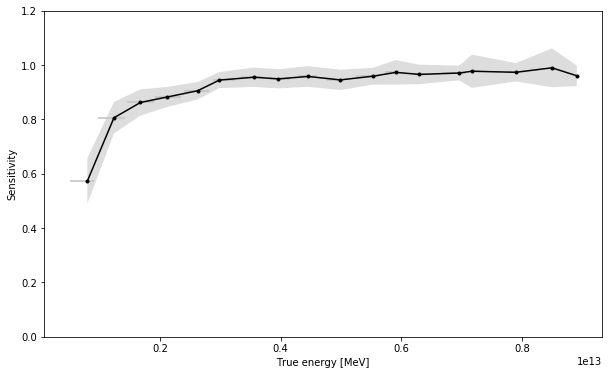

In [149]:
t_extra_trees_cls_on_train_rfecv__test__numbers_by_energy = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls, 
        learning_data__var_th_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_trueenergy')

xscale = 'linear'

for plotted_yerr_stat, method in [
        ('positive_sm_confint_{}_95'.format(tm), tm) for tm in [
        'normal', 'beta', 'agresti_coull', 'wilson', 'jeffreys', 'binom_test']
        ] + [('sensitivity_err_mario', None)]:
    
    print(plotted_yerr_stat)
    print('-'*50)
    
    if method is not None:
        calc_cls_stats_from_numbers_func = \
            lambda n,method=method: \
                calc_cls_stats_from_numbers_with_sm_proportion_confint(n,methods=[method])
    else:
        calc_cls_stats_from_numbers_func = calc_cls_stats_from_numbers
        
    plot_x, plot_y, plot_xerr, plot_yerr = \
        get_efficiency_stat_plot_data(
            t_extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
            plotted_stat='sensitivity', plotted_yerr_stat=plotted_yerr_stat, 
            num_steps=20, xscale=xscale,
            calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_func
        )
    
    print(np.array(plot_yerr)[0])
    print('*'*50)
    print(np.array(plot_yerr)[1])
    print('*'*50)
    print(np.abs(np.array(plot_y) - plot_yerr[0] - (np.array(plot_y) + plot_yerr[1])))

    plot_efficiency_stat(
        t_extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
        plotted_stat='sensitivity', plotted_yerr_stat=plotted_yerr_stat, 
        num_steps=20, xscale=xscale,
        xlabel='True energy [MeV]', ylabel='Sensitivity', 
        figsize=(10,6), ylim=(0,1.2),
        calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_func
    )
    
    print('='*50)

### Test set sensitivity as function of the energy (no binning)

In [150]:
extra_trees_cls_on_train_rfecv__test__accuracy_by_energy = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls,
        learning_data__var_th_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        sklearn.metrics.accuracy_score, 
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_trueenergy')

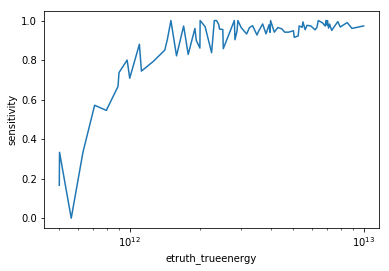

In [151]:
# extra_trees_cls_on_train_rfecv__test__accuracy_by_energy

plt.close('all')
fig, ax = plt.subplots()
ax.plot(extra_trees_cls_on_train_rfecv__test__accuracy_by_energy.keys(), 
        extra_trees_cls_on_train_rfecv__test__accuracy_by_energy.values())
ax.set_xlabel('etruth_trueenergy')
ax.set_ylabel('sensitivity')
ax.set_xscale('log')
plt.show()

### Test set sensitivity as function of the energy

In [152]:
extra_trees_cls_on_train_rfecv__test__numbers_by_energy = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls, 
        learning_data__var_th_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_trueenergy')

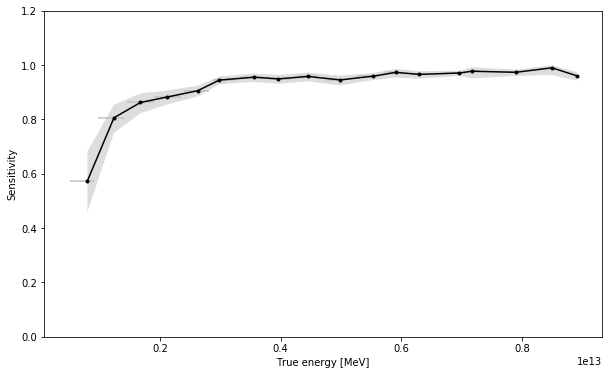

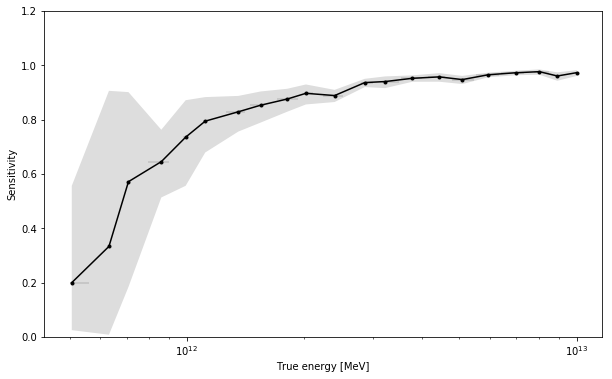

In [153]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax, errbr = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
            plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
            calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
            figsize = (10,6), ylim=(0,1.2), show=False)
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Test set sensitivity as function of the energy - {}.svg'.format(xscale)), dpi=150)
    plt.show()

### Sensitivity as function of $E_{truth}$ partitioned by $R_{max}$

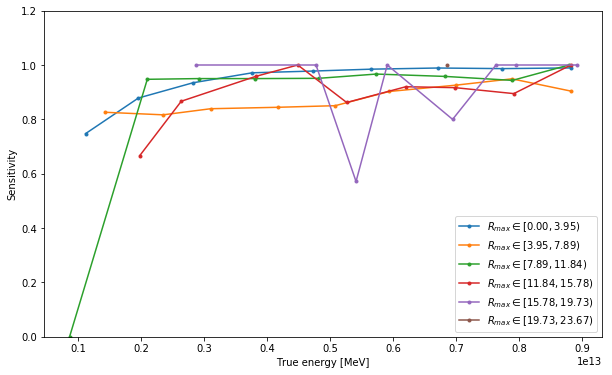

In [154]:
plot_partitioned_efficiency_stat(
    data_X=learning_data__var_th_X_test[learning_data__simu_shower_track_mask_arr_test],
    data_y=learning_data__y_test[learning_data__simu_shower_track_mask_arr_test],
    data_event_id=learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test],
    combined_simu_df=combined_simu_df,
    num_prop_bins=5, plot_num_steps=10,
    classifier = rfecv_selector_on_extra_trees_cls,
    prop_name='calc_etruth_trueshower_rmax',
    prop_label='$R_{max}$',
    plot_prop_name = 'etruth_trueenergy',
    plot_xlabel = 'True energy [MeV]',
    format_prop_value_func=lambda v: '{:.2f}'.format(v/1e6),
    single_fig=True,
);

### Sensitivity as function of $E_{truth}$ partitioned by mean background counts

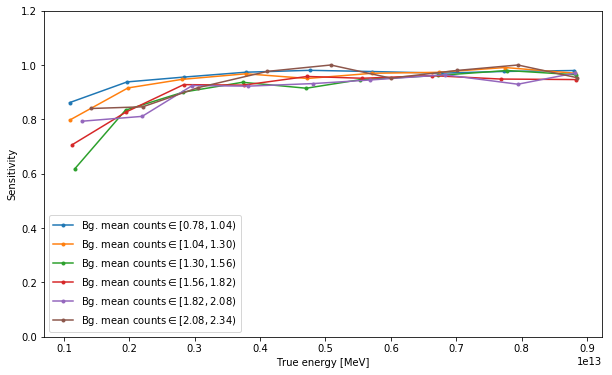

In [155]:
plot_partitioned_efficiency_stat(
    data_X=learning_data__var_th_X_test[learning_data__simu_shower_track_mask_arr_test],
    data_y=learning_data__y_test[learning_data__simu_shower_track_mask_arr_test],
    data_event_id=learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test],
    combined_simu_df=combined_simu_df,
    num_prop_bins=5, plot_num_steps=10,
    classifier = rfecv_selector_on_extra_trees_cls,
    prop_name='bg_mean',
    prop_label='Bg. mean counts',
    plot_prop_name = 'etruth_trueenergy',
    plot_xlabel = 'True energy [MeV]',
    format_prop_value_func=lambda v: '{:.2f}'.format(v),
    single_fig=True,
);

### Number of true positivie and positive samples as function of the energy

#### Number of positive samples as function of the energy

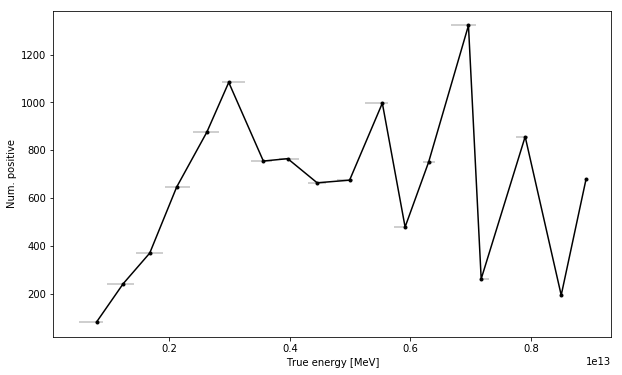

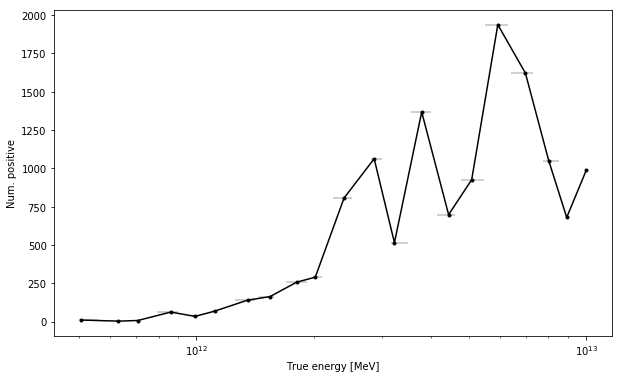

In [156]:
for xscale in ('linear', 'log'):
    fig, ax, errbr = \
        plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
                             plotted_stat='num_positive', num_steps = 20, xscale=xscale,
                             xlabel = 'True energy [MeV]', ylabel = 'Num. positive', 
                             figsize = (10,6))
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Number of positive samples as function of the energy - {}.svg'.format(xscale)), dpi=150)
    

##### Number of true positive samples as function of the energy

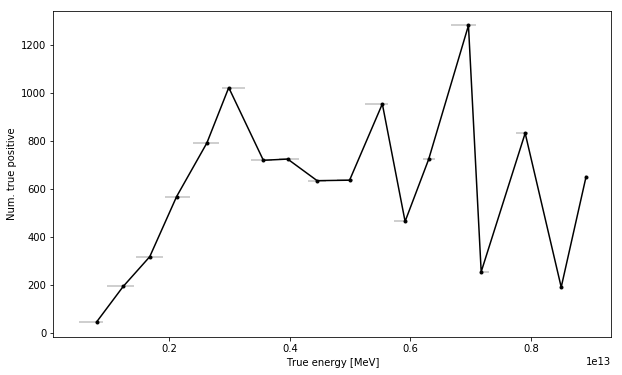

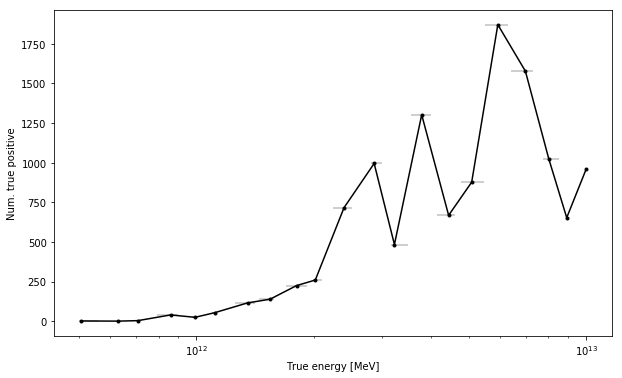

In [157]:
for xscale in ('linear', 'log'):
    fig, ax, errbr = \
        plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
                             plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
                             xlabel = 'True energy [MeV]', ylabel = 'Num. true positive', 
                             figsize = (10,6), show=False)
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Number of true positive samples as function of the energy - {}.svg'.format(xscale)), dpi=150)
    plt.show()

##### Number of true positive or positive samples as function of the energy - comparison

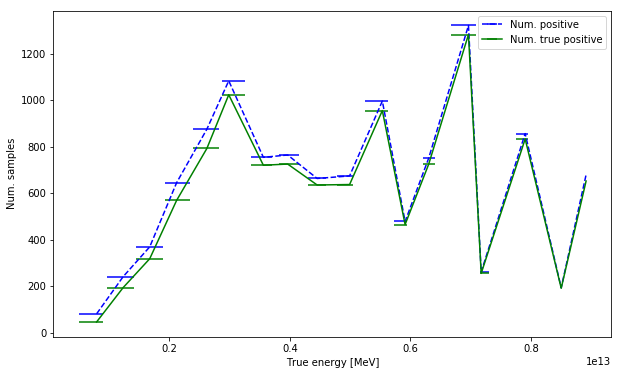

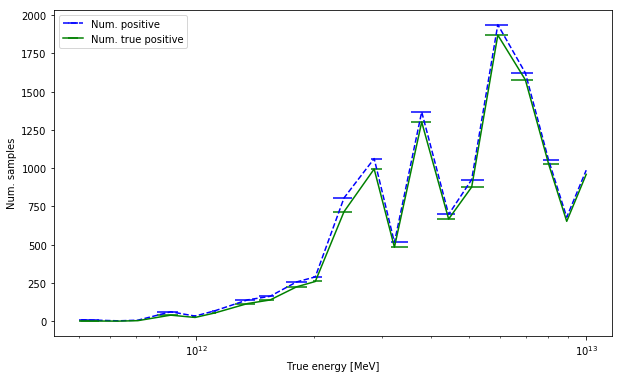

In [158]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__test__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Number of true positive or positive samples as function of the energy - comparison - {}.svg'.format(xscale)), dpi=150)
    plt.show()

#### Test set sensitivity as function of theta (zenith angle)

In [159]:
extra_trees_cls_on_train_rfecv__test__numbers_by_theta = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls, 
        learning_data__var_th_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers,
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_truetheta')

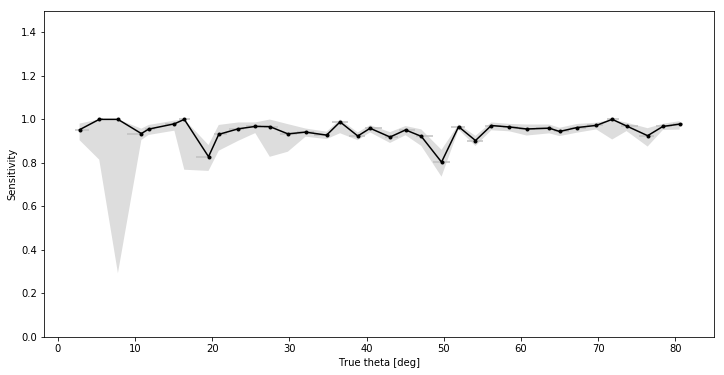

In [160]:
fig, ax, errbr = \
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_theta, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 90/2.5, 
                         xtranslate_func=np.rad2deg,
                         xlabel ='True theta [deg]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (12,6), ylim=(0,1.5), show=False)
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'Test set sensitivity as function of the theta (zenith angle).svg'), dpi=150)
plt.show()

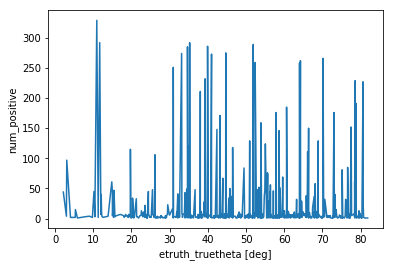

In [161]:
plt.close('all')
fig, ax = plt.subplots()
ax.plot([np.rad2deg(v) for v in extra_trees_cls_on_train_rfecv__test__numbers_by_theta.keys()], 
        [d['num_positive'] for d in extra_trees_cls_on_train_rfecv__test__numbers_by_theta.values() if d['num_positive'] is not None])
ax.set_xlabel('etruth_truetheta [deg]')
ax.set_ylabel('num_positive')
# ax.set_xscale('log')
plt.show()

#### Test set sensitivity as function of phi (azimuth angle)

In [162]:
extra_trees_cls_on_train_rfecv__test__numbers_by_phi = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls, 
        learning_data__var_th_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers,
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'etruth_truephi')

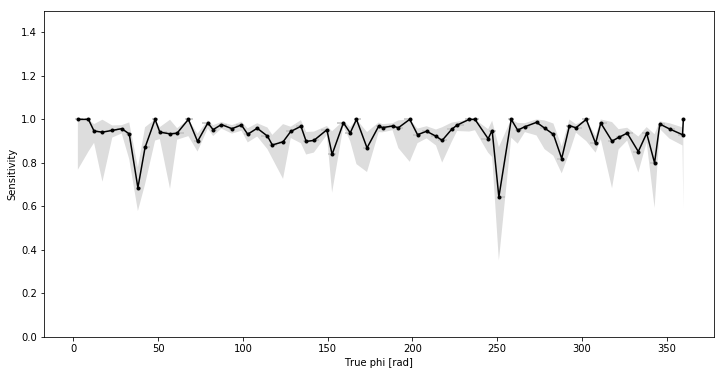

In [163]:
fig, ax, errbr = \
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_phi, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 360/5, 
                         xtranslate_func=np.rad2deg,
                         xlabel = 'True phi [rad]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (12,6), ylim=(0,1.5), show=False)
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'Test set sensitivity as function of the phi (azimuth angle).svg'), dpi=150)
plt.show()

#### Test set sensitivity as function of $R_{max}$

In [164]:
extra_trees_cls_on_train_rfecv__test__numbers_by_rmax = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls, 
        learning_data__var_th_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers,
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'calc_etruth_trueshower_rmax')

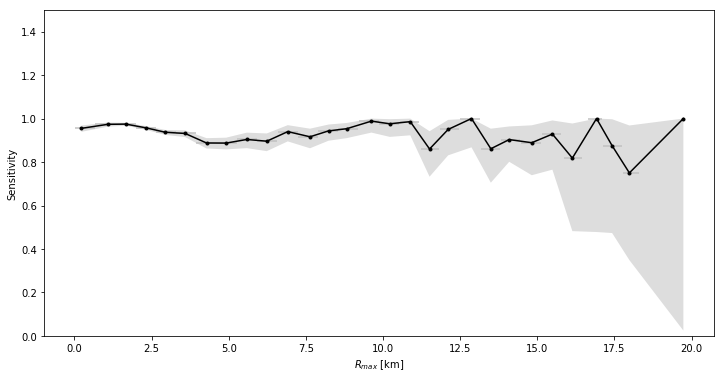

In [165]:
fig, ax, errbr = \
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_rmax, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 30, 
                         xtranslate_func=lambda v: np.array(v)/1e6,
                         xlabel = '$R_{max}$ [km]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (12,6), ylim=(0,1.5), show=False)
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'Test set sensitivity as function of r_max.svg'), dpi=150)
plt.show()

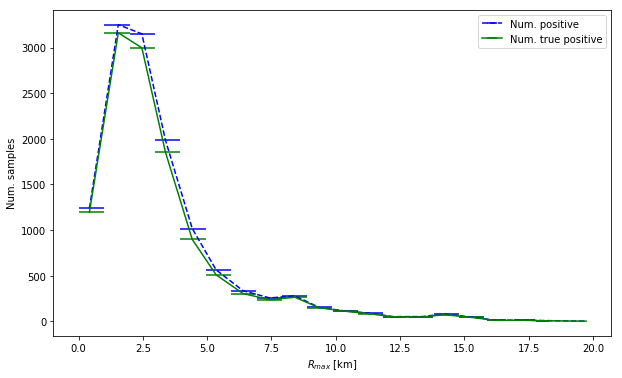

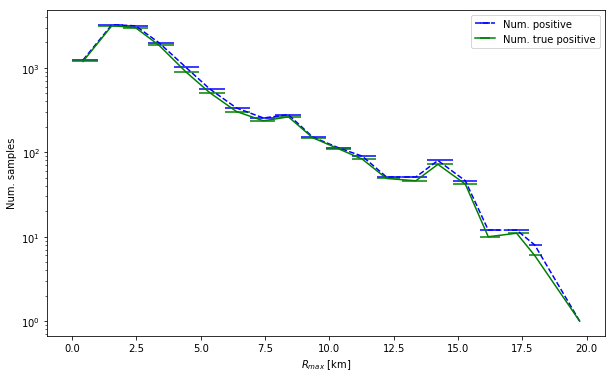

In [166]:
for yscale in ['linear', 'log']:
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__test__numbers_by_rmax, 
            plotted_stat='num_positive', num_steps = 20, xscale='linear',
            show_fill_between=False, plotted_yerr_stat=None,
            xtranslate_func=lambda v: np.array(v)/1e6, xlabel = '$R_{max}$ [km]',
            ylabel = 'Num. positive', label='Num. positive',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__test__numbers_by_rmax, 
            plotted_stat='num_true_positive', num_steps = 20, 
            show_fill_between=False, plotted_yerr_stat=None, xscale='linear',
            xtranslate_func=lambda v: np.array(v)/1e6, xlabel = '$R_{max}$ [km]',
            ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.set_yscale(yscale)
    ax.legend()
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Number of true positive or positive samples as function of r_max - yscale {}.svg'.format(yscale)), dpi=150)
    plt.show()

#### Test set sensitivity as function of mean background

In [167]:
extra_trees_cls_on_train_rfecv__test__numbers_by_bg_mean = \
    score_by_column(
        rfecv_selector_on_extra_trees_cls, 
        learning_data__var_th_X_test[learning_data__simu_shower_track_mask_arr_test], 
        learning_data__y_test[learning_data__simu_shower_track_mask_arr_test], 
        calc_cls_numbers,
        learning_data__event_id_test[learning_data__simu_shower_track_mask_arr_test], 
        combined_simu_df, 'bg_mean')

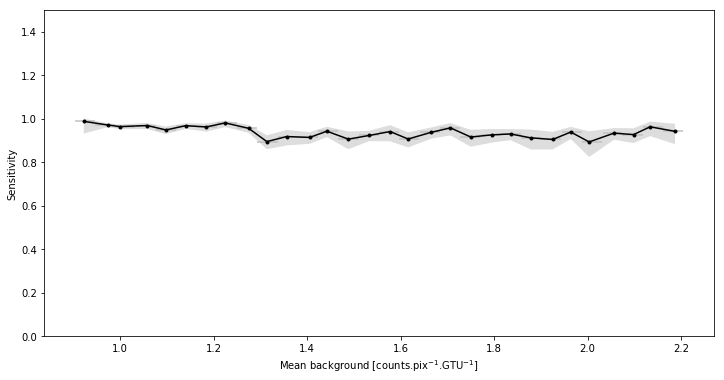

In [168]:
fig, ax, errbr = \
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__test__numbers_by_bg_mean, 
                         plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 30, 
                         xlabel = 'Mean background [counts.pix$^{-1}$.GTU$^{-1}$]', ylabel = 'Sensitivity', 
                         calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                         figsize = (12,6), ylim=(0,1.5), show=False)
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'Test set sensitivity as function of mean background.svg'), dpi=150)
plt.show()

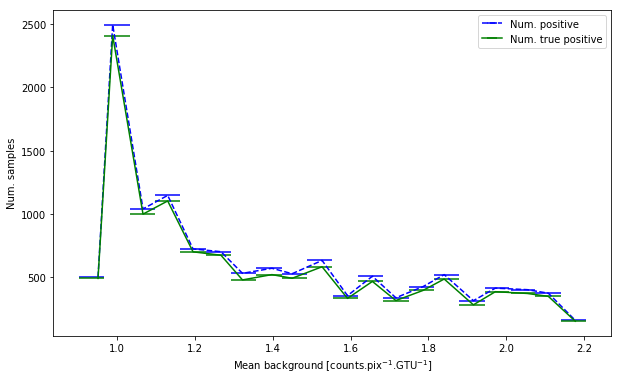

In [169]:
fig, ax = plt.subplots()
fig, ax, errbr_num_positive = \
    plot_efficiency_stat(
        extra_trees_cls_on_train_rfecv__test__numbers_by_bg_mean, 
        plotted_stat='num_positive', num_steps = 20, xscale='linear',
        show_fill_between=False, plotted_yerr_stat=None,
        xlabel = 'Mean background [counts.pix$^{-1}$.GTU$^{-1}$]',
        ylabel = 'Num. positive', label='Num. positive',
        figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
        ax=ax, show=False)
fig, ax, errbr_num_true_positive = \
    plot_efficiency_stat(
        extra_trees_cls_on_train_rfecv__test__numbers_by_bg_mean, 
        plotted_stat='num_true_positive', num_steps = 20, 
        show_fill_between=False, plotted_yerr_stat=None, xscale='linear',
        xlabel = 'Mean background [counts.pix$^{-1}$.GTU$^{-1}$]',
        ylabel = 'Num. true positive', label='Num. true positive',
        figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
        ax=ax, show=False)
ax.set_ylabel('Num. samples')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                         'Number of true positive or positive samples as function of mean background.svg'), dpi=150)
plt.show()

### Cross-validated recognition performance

In [170]:
rerun_extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results = False
overwrite_extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results = True

In [171]:
extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results_pathname = \
    os.path.join(data_snippets_dir, 'extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results__simu_event_ids_{}.pkl'.format(simu_event_ids_md5))

if rerun_extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results or \
        not os.path.exists(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results_pathname):
    
    extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results = \
        cross_val_score_meta_scored(
            extra_trees_cls_on_train_rfecv_for_crossvalidation,
            learning_data__rfecv_var_th_X, learning_data__y,
            get_func_score_by_column_using_indices(None, learning_data__event_id, combined_simu_df, 'etruth_trueenergy'),
            score_func=calc_cls_numbers,
            cv=sklearn.model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=123), verbose=1
        )
    
    if overwrite_extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results or \
            not os.path.exists(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results_pathname):
        print('Saving...', extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results_pathname)
        joblib.dump(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
                    extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results_pathname)

else:
    print('Loading...', extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results_pathname)
    extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results = \
        joblib.load(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results_pathname)    
    

Loading... ver4_machine_learning_w_labeled_flight_20190217/extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results__simu_event_ids_771a6a452a651f419ec12b94ac5eb28d.pkl


#### Considering all samples from cross-validations (not very correct)
All results from the cross-validations are joined into a single set (list) and then this set is used to calculate error - this multiplies size of the dataset by number of cross-validation folds.

Functions are not using any results reduce function - parameter `dict_stats_yerr_reduce` is not set.

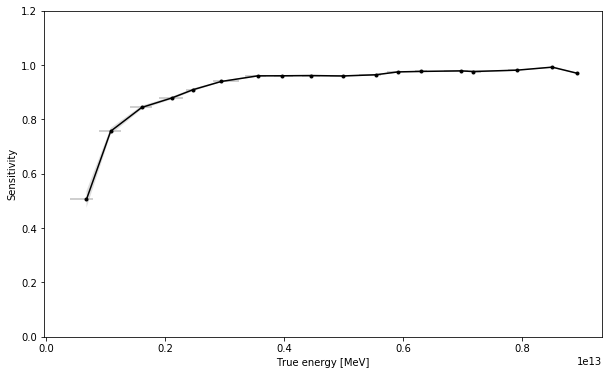

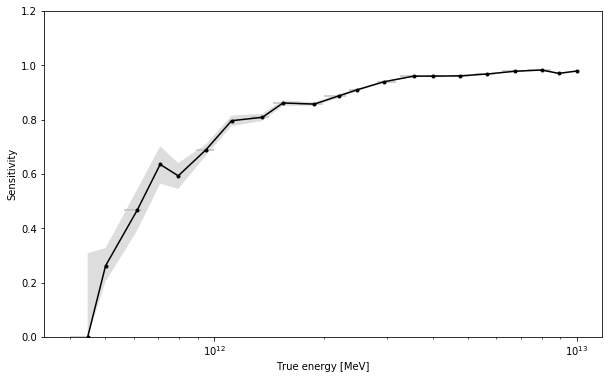

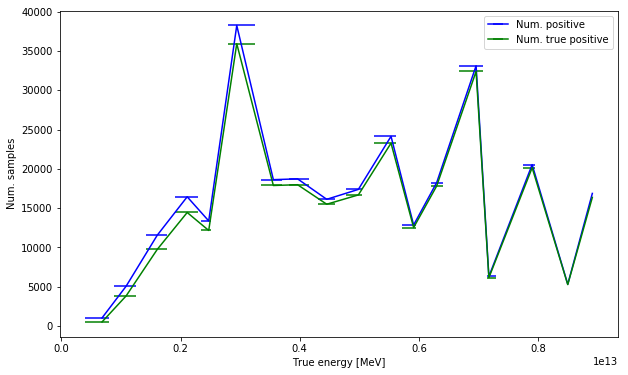

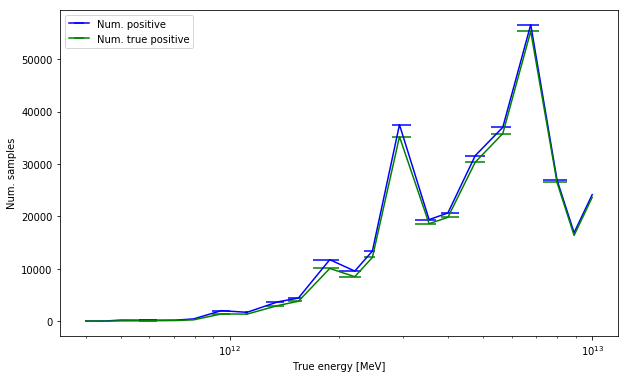

In [172]:
plt.close('all')
for xscale in ['linear', 'log']:
    fig, ax, errbr = \
        plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
                             plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', num_steps = 20, xscale=xscale,
                             calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                             xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                             figsize = (10,6), ylim=(0,1.2), show=False)
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Cross-validated - Considering all samples from cross-validations (not very correct) - sensitivity - {}.svg'.format(xscale)), dpi=150)
for xscale in ['linear', 'log']: 
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (10,6), errorbar_attrs=dict(linestyle='-', color='blue'),
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Cross-validated - Considering all samples from cross-validations (not very correct) - num samples - {}.svg'.format(xscale)), dpi=150)
    plt.show()

#### Averaging sensitivities, error is standard deviation
Parameter `dict_stats_yerr_reduce` is set to compute standard deviation of different cross-validation results.

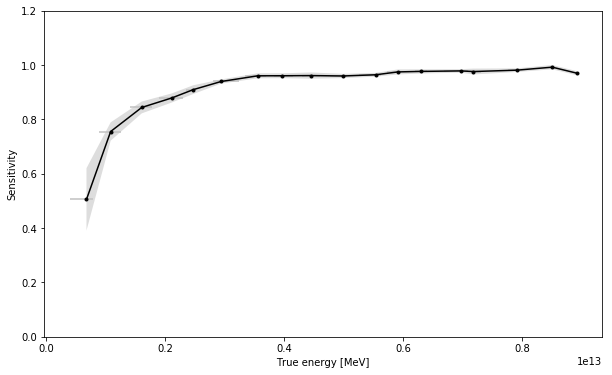

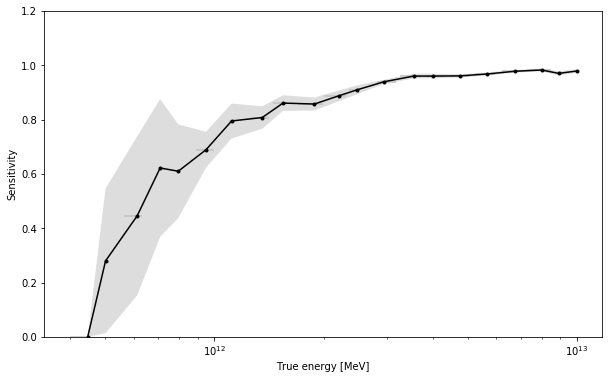

In [173]:
plt.close('all')
for xscale in ['linear', 'log']:
    fig, ax, errbr = \
        plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
                             concat_dicts=False, dict_stats_yerr_reduce='std_y',
                             plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_95', 
                             calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                             num_steps = 20, xscale=xscale,
                             xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                             figsize = (10,6), ylim=(0,1.2), show=False)
    fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                             'Cross-validated - Averaging sensitivities, error is standard deviation - sensitivity - {}.svg'.format(xscale)), dpi=150)
    plt.show()

#### Averaging sensitivities, error is min-max range

Confidence: 68


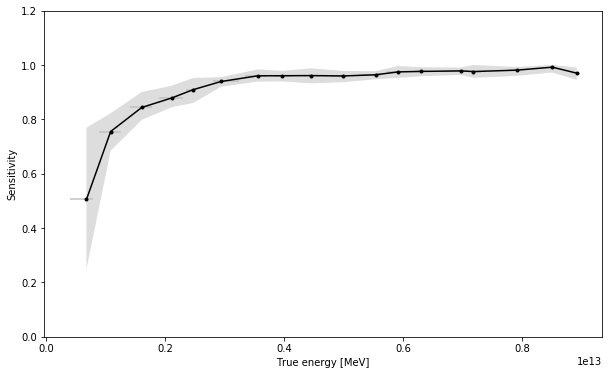

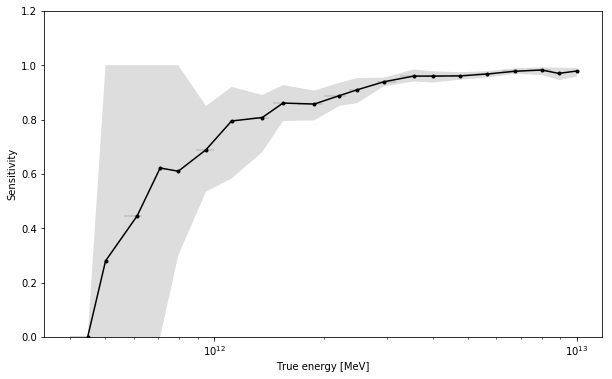

Confidence: 95


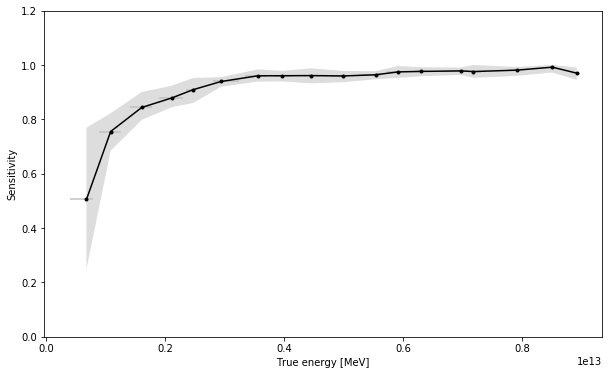

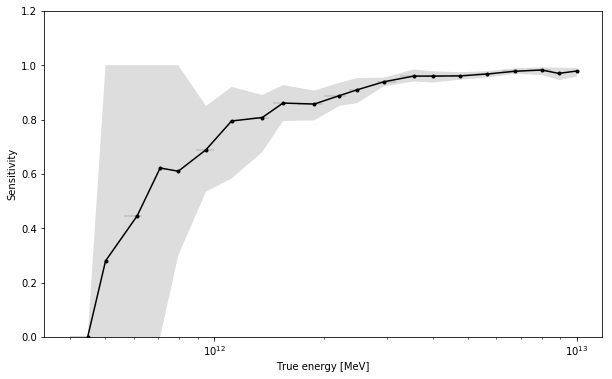

Confidence: 100


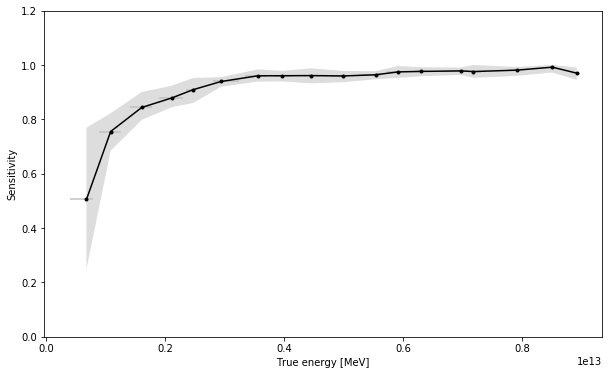

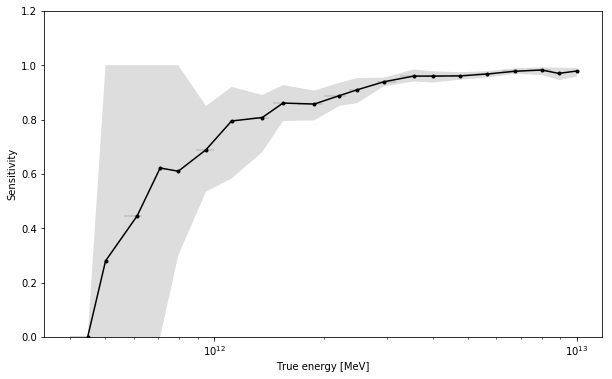

In [174]:
for confidence in [68, 95, 100]:
    print('Confidence:', confidence)
    for xscale in ['linear', 'log']:
        fig, ax, errbr = \
            plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
                                 concat_dicts=False, dict_stats_yerr_reduce='minmax_y',
                                 plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_'+str(confidence), 
                                 num_steps = 20, xscale=xscale,
                                 calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                                 xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                                 figsize = (10,6), ylim=(0,1.2), show=False)
        fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                                 'Cross-validated - Averaging sensitivities, error is min-max range - sensitivity - {}.svg'.format(xscale)), dpi=150)
        plt.show()

#### Averaging sensitivities, error is avg_yerr_weighted

Error should be an average of errors for cross-validated sets

Confidence: 68


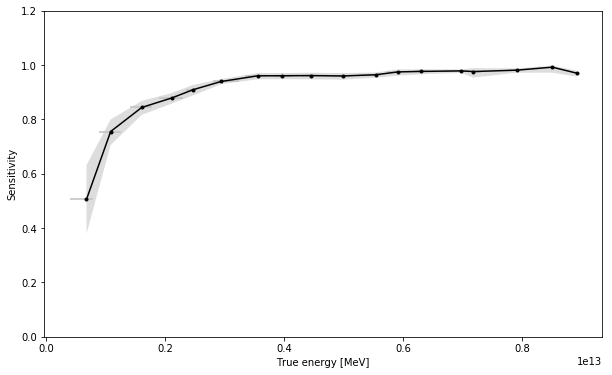

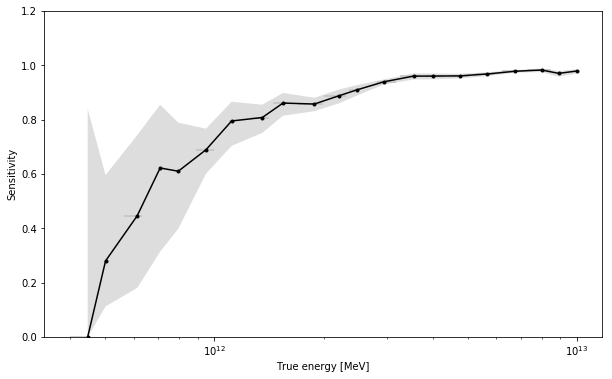

Confidence: 95


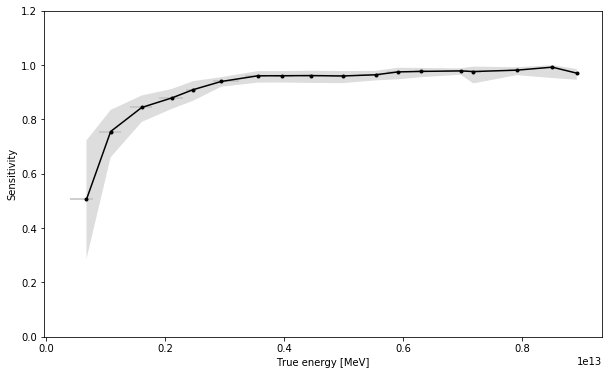

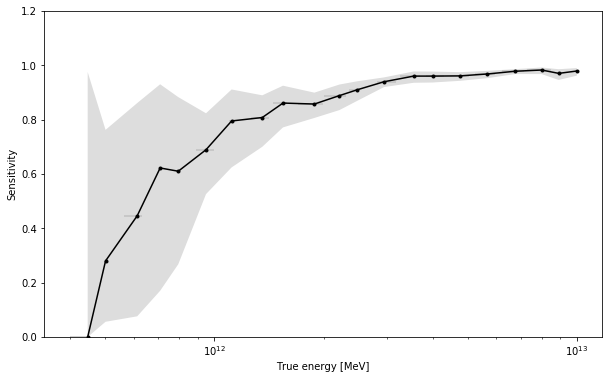

Confidence: 100


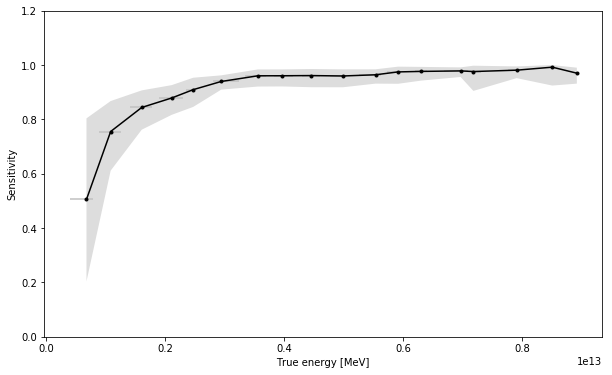

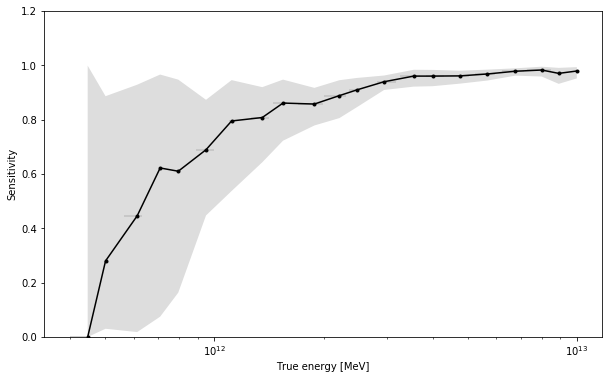

In [175]:
for confidence in [68, 95, 100]:
    print('Confidence:', confidence)
    for xscale in ['linear', 'log']:
        fig, ax, errbr = \
            plot_efficiency_stat(extra_trees_cls_on_train_rfecv_for_crossvalidation_per_trueenergy_results, 
                                 concat_dicts=False, dict_stats_yerr_reduce='avg_yerr_weighted',
                                 plotted_stat='sensitivity', plotted_yerr_stat='positive_sm_confint_beta_'+str(confidence), 
                                 calc_cls_stats_from_numbers_func=calc_cls_stats_from_numbers_with_sm_proportion_confint,
                                 num_steps = 20, xscale=xscale,
                                 xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                                 figsize = (10,6), ylim=(0,1.2))
        fig.savefig(os.path.join(data_snippets_dir, 'figures', 
                                 'Cross-validated - Averaging sensitivities, error is avg_yerr_weighted - sensitivity - {}.svg'.format(xscale)), dpi=150)
        plt.show()

## TODO
- investigate sensitivity(background), use bg_mean column
- investigate sensitivity(shower_max_pos)

# Flight data classification

In [176]:
pipeline_from_trained_models__extr_rfecv_vth__y_pred = \
    pipeline_from_trained_models__extr_rfecv_vth.predict(
        unl_flight_df[analyzed_common_df_columns].dropna().values)

In [177]:
num_non_shower = np.count_nonzero(pipeline_from_trained_models__extr_rfecv_vth__y_pred == 0)
num_shower = np.count_nonzero(pipeline_from_trained_models__extr_rfecv_vth__y_pred == 1)
tot_entries = len(unl_flight_df[analyzed_common_df_columns].dropna().values)

print("Num. non-shower", num_non_shower)
print("Num. shower", num_shower)
print("All entries", tot_entries)
print("-"*30)
print("Fraction non-shower: {:.3f}".format(num_non_shower/tot_entries))
print("Fraction shower: {:.3f}".format(num_shower/tot_entries))

Num. non-shower 9529
Num. shower 471
All entries 10000
------------------------------
Fraction non-shower: 0.953
Fraction shower: 0.047


In [178]:
# tsne_on_learning_data_60_rfecv_column_names_hexdigest = hashlib.md5((','.join(rfecv_selector_on_extra_trees__column_names__sorted[0:60])).encode()).hexdigest()

# tsne_on_learning_data_60_rfecv_columns_alldata_pathname = \
#     os.path.join(data_snippets_dir, 'tsne_on_learning_data_60_rfecv_columns_alldata_{}.pkl'.format(
#         tsne_on_learning_data_60_rfecv_column_names_hexdigest))
# tsne_on_learning_data_60_rfecv_columns_scaler_alldata_pathname = \
#     os.path.join(data_snippets_dir, 'tsne_on_learning_data_60_rfecv_columns_{}_scale_alldatar.pkl'.format(
#         tsne_on_learning_data_60_rfecv_column_names_hexdigest))

# if refit_tsne_model or not os.path.exists(tsne_on_learning_data_60_rfecv_columns_alldata_pathname):
#     tsne_on_learning_data_60_rfecv_columns_alldata = sklearn.manifold.TSNE(learning_rate=100, verbose=10, n_iter=5000)
#     tsne_on_learning_data_60_rfecv_columns_scaler_alldata = sklearn.preprocessing.StandardScaler()
    
#     learning_data__X__tsne_learning_data_60_rfecv_columns_alldata = \
#         tsne_on_learning_data_60_rfecv_columns_alldata.fit_transform(
#             tsne_on_learning_data_60_rfecv_columns_scaler_alldata.fit_transform(
#                 rfecv_selector_on_extra_trees_cls.transform(learning_data__var_th_X_train).T[   # 232.T[
#                     rfecv_selector_on_extra_trees__column_indices__sorted[0:60]].T              #       232[0:60]].T
#             )
#         )
    
#     if dump_tsne_model: 
#         print(tsne_on_learning_data_60_rfecv_columns_alldata_pathname)
#         joblib.dump(tsne_on_learning_data_60_rfecv_columns_alldata, 
#                     tsne_on_learning_data_60_rfecv_columns_alldata_pathname, compress=1)
        
#         print(tsne_on_learning_data_60_rfecv_columns_scaler_alldata_pathname)
#         joblib.dump(tsne_on_learning_data_60_rfecv_columns_scaler_alldata, 
#                     tsne_on_learning_data_60_rfecv_columns_scaler_alldata_pathname, compress=1)
# else:
#     tsne_on_learning_data_60_rfecv_columns = joblib.load(tsne_on_learning_data_60_rfecv_columns_alldata_pathname)

#     learning_data__X__tsne_learning_data_60_rfecv_columns_alldata = \
#         tsne_on_learning_data_60_rfecv_columns.embedding_

In [179]:
# joblib.dump(learning_data__X__tsne_learning_data_60_rfecv_columns_alldata, 
#                     tsne_on_learning_data_60_rfecv_columns_alldata_pathname, compress=1)

In [180]:
# tsne_on_learning_data_60_rfecv_columns_alldata